Text(0, 0.5, 'Cycle life')

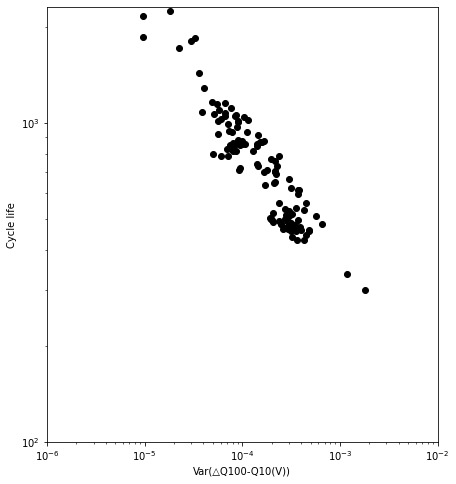

In [18]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

In [202]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [203]:
np.random.seed(42)
threshold = 550

In [204]:
imax=120
jmax=120

def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,imax+1): # 
        for j in range(1,jmax+1): # j
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_

In [205]:
i_, j_ =i_j_make()

In [206]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        if cycle_test[0][0]>=threshold:
            test_label.append(1)
        else:
            test_label.append(0)
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        if cycle_train[0][0]>=threshold:
            train_label.append(1)
        else:
            train_label.append(0)
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        if cycle_sec[0][0]>=threshold:
            sec_label.append(1)
        else:
            sec_label.append(0)

In [207]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)

In [208]:
train_label.shape

(41,)

In [209]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
def logistic_auc(Train_data_standard, train_label,Test_data_standard, test_label, Sec_data_standard, sec_label,
                 random_trainX,random_trainY, random_testX, random_testY): 
    #학습은 train data 로 진행 하고 predict는 랜덤 데이터 얻기
    
    Log_reg = LogisticRegressionCV(cv=4,penalty='l1',solver='liblinear')
    Log_reg.fit(Train_data_standard,train_label)

    AUC_train=roc_auc_score(random_trainY, Log_reg.decision_function(random_trainX))
    AUC_test=roc_auc_score(random_testY, Log_reg.decision_function(random_testX))
    
    coef_info=Log_reg.coef_
    
    pred_train=Log_reg.predict(Train_data_standard)
    at=accuracy_score(train_label,pred_train)
    pred_test=Log_reg.predict(Test_data_standard)
    apt=accuracy_score(test_label,pred_test)
    pred_sec=Log_reg.predict(Sec_data_standard)
    ast=accuracy_score(sec_label,pred_sec)
    
    conf_train=confusion_matrix(train_label,pred_train)
    conf_test=confusion_matrix(test_label,pred_test)
    conf_sec=confusion_matrix(sec_label,pred_sec)
    
    return AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast

In [210]:
mx_train=np.zeros((jmax+1,imax+1))
mx_test=np.zeros((jmax+1,imax+1))
mx_acc_at=np.zeros((jmax+1,imax+1))
mx_acc_apt=np.zeros((jmax+1,imax+1))
mx_acc_ast=np.zeros((jmax+1,imax+1))
from sklearn.linear_model import LinearRegression
from scipy import integrate
from scipy.stats import skew
from scipy.stats import kurtosis
def Averagetime(i,k):
    if i < 5:
        sumtime=0
        for j in range(i):
            time=bat_dict[k]['summary']['chargetime'][j+1]
            sumtime+=time
        ACT=sumtime/i
    else:
        t1=bat_dict[k]['summary']['chargetime'][1]
        t2=bat_dict[k]['summary']['chargetime'][2]
        t3=bat_dict[k]['summary']['chargetime'][3]
        t4=bat_dict[k]['summary']['chargetime'][4]
        t5=bat_dict[k]['summary']['chargetime'][5]
        ACT=(t1+t2+t3+t4+t5)/5
    return ACT

def searchmaxQ_cycle2(k):
    x=bat_dict[k]['summary']['QD']
    cycle2=bat_dict[k]['summary']['QD'][2]
    while True:
        if np.max(x)>1.2:
            delete=np.where(np.max(x)==x)[0][0]
            x=np.delete(x, delete)
        if np.max(x)<=1.2:
            break
    return np.max(x)-cycle2
    
for i,j in zip(i_,j_):
    # 1. min
    min_=np.array([])
    min_test_=np.array([])
    min_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_=np.hstack([min_,np.min(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_test_=np.hstack([min_test_,np.min(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        min_sec_=np.hstack([min_sec_,np.min(diff)])
        
    # 2. mean
    mean_=np.array([])
    mean_test_=np.array([])
    mean_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_=np.hstack([mean_,np.mean(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_test_=np.hstack([mean_test_,np.mean(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        mean_sec_=np.hstack([mean_sec_,np.mean(diff)])       
        
    # 3. var
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])
        
    # 4. Skewness
    skew_=np.array([])
    skew_test_=np.array([])
    skew_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_=np.hstack([skew_,skew(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_test_=np.hstack([skew_test_,skew(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        skew_sec_=np.hstack([skew_sec_,skew(diff)])

    # 5. Kurtosis
    kurt_=np.array([])
    kurt_test_=np.array([])
    kurt_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_=np.hstack([kurt_,kurtosis(diff,fisher=True)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_test_=np.hstack([kurt_test_,kurtosis(diff,fisher=True)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        kurt_sec_=np.hstack([kurt_sec_,kurtosis(diff,fisher=True)])
        
    # 6. Value at 2V
    Value2V_=np.array([])
    Value2V_test_=np.array([])
    Value2V_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_=np.hstack([Value2V_,diff[-1]])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_test_=np.hstack([Value2V_test_,diff[-1]])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        Value2V_sec_=np.hstack([Value2V_sec_,diff[-1]])

       
    # 7. j to i slope, 8. intercept
    slope_=np.array([])
    slope_test_=np.array([])
    slope_sec_=np.array([])
    
    intercept_=np.array([])
    intercept_test_=np.array([])
    intercept_sec_=np.array([])
    
    Train=np.array(range(j,i+1)).reshape(-1,1)
    for k in train_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()
        
        reg = LinearRegression()
        reg.fit(Train,label)
        
        slope_=np.hstack([slope_,reg.coef_])
        intercept_=np.hstack([intercept_,reg.intercept_])
        
    for k in test_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()
        
        reg = LinearRegression()
        reg.fit(Train,label)
        
        slope_test_=np.hstack([slope_test_,reg.coef_])
        intercept_test_=np.hstack([intercept_test_,reg.intercept_])
    for k in sec_data:
        QD_data=bat_dict[k]['summary']['QD'][j:i+1]
        label=np.array(QD_data).ravel()
        
        reg = LinearRegression()
        reg.fit(Train,label)
        
        slope_sec_=np.hstack([slope_sec_,reg.coef_])
        intercept_sec_=np.hstack([intercept_sec_,reg.intercept_])

    # 9. Discharge Capacity, Cycle2
    cycle2_=np.array([])
    cycle2_test_=np.array([])
    cycle2_sec_=np.array([])
    for k in train_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_=np.hstack([cycle2_,Cycle2])
    for k in test_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_test_=np.hstack([cycle2_test_,Cycle2])
    for k in sec_data:
        Cycle2=bat_dict[k]['summary']['QD'][2]
        cycle2_sec_=np.hstack([cycle2_sec_,Cycle2])
        
    # 10. Difference between max discharge capacity and cycle 2
    cyclemax_2_=np.array([])
    cyclemax_2_test_=np.array([])
    cyclemax_2_sec_=np.array([])
    for k in train_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_=np.hstack([cyclemax_2_,cyclemax_2])
    for k in test_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_test_=np.hstack([cyclemax_2_test_,cyclemax_2])
    for k in sec_data:
        cyclemax_2=searchmaxQ_cycle2(k)
        cyclemax_2_sec_=np.hstack([cyclemax_2_sec_,cyclemax_2])

    # 11. Discharge capacity, cycle i (cycle i에 따른 값변경)
    cycle_i_=np.array([])
    cycle_i_test_=np.array([])
    cycle_i_sec_=np.array([])
    for k in train_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_=np.hstack([cycle_i_,Cycle100])
    for k in test_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_test_=np.hstack([cycle_i_test_,Cycle100])
    for k in sec_data:
        Cycle100=bat_dict[k]['summary']['QD'][i]
        cycle_i_sec_=np.hstack([cycle_i_sec_,Cycle100])        
        
    # 12. Average charge time, first 5 cycles -> 5 cycle이 안되는 data는 최대 cycle
    Average_=np.array([])
    Average_test_=np.array([])
    Average_sec_=np.array([])
        
    for k in train_data:
        Average_time=Averagetime(i,k)
        Average_=np.hstack([Average_,Average_time])
    for k in test_data:
        Average_time=Averagetime(i,k)
        Average_test_=np.hstack([Average_test_,Average_time])
    for k in sec_data:
        Average_time=Averagetime(i,k)
        Average_sec_=np.hstack([Average_sec_,Average_time])
        
    # 13. Maximum temperature, cycles 2 to i 
    Max_cycleT_=np.array([])
    Max_cycleT_test_=np.array([])
    Max_cycleT_sec_=np.array([])
    for k in train_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_=np.hstack([Max_cycleT_,max_cycle_T])
    for k in test_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_test_=np.hstack([Max_cycleT_test_,max_cycle_T])
    for k in sec_data:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        max_cycle_T=np.max(maxt)
        Max_cycleT_sec_=np.hstack([Max_cycleT_sec_,max_cycle_T])   
        

    # 14. Minimum temperature, cycles 2 to 100 
    Min_cycleT_=np.array([])
    Min_cycleT_test_=np.array([])
    Min_cycleT_sec_=np.array([])
    for k in train_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_=np.hstack([Min_cycleT_,min_cycle_T])
    for k in test_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_test_=np.hstack([Min_cycleT_test_,min_cycle_T])
    for k in sec_data:
        mint=[]
        for k_ in range(2,i+1):
            c=np.min(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            mint.append(c)  
        min_cycle_T=np.min(mint)
        Min_cycleT_sec_=np.hstack([Min_cycleT_sec_,min_cycle_T])  
        
    #15. Integral of temperature over time, cycles 2 to i
    integralT_=np.array([])
    integralT_test_=np.array([])
    integralT_sec_=np.array([])
    
    for k in train_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_=np.hstack([integralT_,intg])
        
        
        
    for k in test_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_test_=np.hstack([integralT_test_,intg])
        
        
        
    for k in sec_data:
        integral=[]
        for k_ in range(2,i+1):
            y=bat_dict[k]['cycles']['{}'.format(k_)]['T'].tolist()
            x=bat_dict[k]['cycles']['{}'.format(k_)]['t'].tolist()        
            integral.append(integrate.trapz(y,x))
        intg=sum(integral)
        integralT_sec_=np.hstack([integralT_sec_,intg])
        
    # 16. internal resistance, cycle2 
    cycle2IR_=np.array([])
    cycle2IR_test_=np.array([])
    cycle2IR_sec_=np.array([])
    for k in train_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_=np.hstack([cycle2IR_,Cycle2])
    for k in test_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_test_=np.hstack([cycle2IR_test_,Cycle2])
    for k in sec_data:
        Cycle2=bat_dict[k]['summary']['IR'][2]
        cycle2IR_sec_=np.hstack([cycle2IR_sec_,Cycle2])  

    # 17, Minimum internal resistance, cycles 2  to i      
    minR_=np.array([])
    minR_test_=np.array([])
    minR_sec_=np.array([])
    
    for k in train_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_=np.hstack([minR_,minIR_])
    for k in test_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_test_=np.hstack([minR_test_,minIR_])
    for k in sec_data:
        minIR=[]
        for k_ in range(2,i+1):
            IR=bat_dict[k]['summary']['IR'][k_]
            if IR==0:
                continue
            minIR.append(IR)
        minIR_=min(minIR)
        minR_sec_=np.hstack([minR_sec_,minIR_])   

    
    # 18  Internal resistance, difference between cycle i and cycle 1    
    IRi_2_=np.array([])
    IRi_2_test_=np.array([])
    IRi_2_sec_=np.array([])
    
    for k in train_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_=np.hstack([IRi_2_,IRi_2])
    for k in test_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_test_=np.hstack([IRi_2_test_,IRi_2])
    for k in sec_data:
        IR2=bat_dict[k]['summary']['IR'][1]
        IR_i=bat_dict[k]['summary']['IR'][i]
        IRi_2=IR_i-IR2
        IRi_2_sec_=np.hstack([IRi_2_sec_,IRi_2])
    
    
    #데이터 특성별 정규화 과정 (18개의 feature를 합친 후 각 열을 정규화)
    # 1. Train, Test, Sec
    # min, mean, var, skew, kurt, Value 2V 는 log(abs)를 한다.
    Train_data=np.hstack([np.log(np.abs(min_)).reshape(-1,1),np.log(np.abs(mean_)).reshape(-1,1),np.log(np.abs(var_)).reshape(-1,1),
                         np.log(np.abs(skew_)).reshape(-1,1),np.log(np.abs(kurt_)).reshape(-1,1),np.log(np.abs(Value2V_)).reshape(-1,1),
                         slope_.reshape(-1,1),intercept_.reshape(-1,1),cycle2_.reshape(-1,1),cyclemax_2_.reshape(-1,1),
                         cycle_i_.reshape(-1,1),Average_.reshape(-1,1),Max_cycleT_.reshape(-1,1),Min_cycleT_.reshape(-1,1),
                         integralT_.reshape(-1,1),cycle2IR_.reshape(-1,1),minR_.reshape(-1,1),IRi_2_.reshape(-1,1)])
    Test_data=np.hstack([np.log(np.abs(min_test_)).reshape(-1,1),np.log(np.abs(mean_test_)).reshape(-1,1),np.log(np.abs(var_test_)).reshape(-1,1),
                         np.log(np.abs(skew_test_)).reshape(-1,1),np.log(np.abs(kurt_test_)).reshape(-1,1),np.log(np.abs(Value2V_test_)).reshape(-1,1),
                         slope_test_.reshape(-1,1),intercept_test_.reshape(-1,1),cycle2_test_.reshape(-1,1),cyclemax_2_test_.reshape(-1,1),
                         cycle_i_test_.reshape(-1,1),Average_test_.reshape(-1,1),Max_cycleT_test_.reshape(-1,1),Min_cycleT_test_.reshape(-1,1),
                         integralT_test_.reshape(-1,1),cycle2IR_test_.reshape(-1,1),minR_test_.reshape(-1,1),IRi_2_test_.reshape(-1,1)])    
    Sec_data=np.hstack([np.log(np.abs(min_sec_)).reshape(-1,1),np.log(np.abs(mean_sec_)).reshape(-1,1),np.log(np.abs(var_sec_)).reshape(-1,1),
                         np.log(np.abs(skew_sec_)).reshape(-1,1),np.log(np.abs(kurt_sec_)).reshape(-1,1),np.log(np.abs(Value2V_sec_)).reshape(-1,1),
                         slope_sec_.reshape(-1,1),intercept_sec_.reshape(-1,1),cycle2_sec_.reshape(-1,1),cyclemax_2_sec_.reshape(-1,1),
                         cycle_i_sec_.reshape(-1,1),Average_sec_.reshape(-1,1),Max_cycleT_sec_.reshape(-1,1),Min_cycleT_sec_.reshape(-1,1),
                         integralT_sec_.reshape(-1,1),cycle2IR_sec_.reshape(-1,1),minR_sec_.reshape(-1,1),IRi_2_sec_.reshape(-1,1)])  
    Train_data_standard=(Train_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    Test_data_standard=(Test_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    Sec_data_standard=(Sec_data-np.mean(Train_data,axis=0))/np.std(Train_data,axis=0)
    
    boot_select_train=len(Train_data_standard)
    boot_select_test=len(Test_data_standard)
    boot_sample=20
    train_range= range(0,boot_select_train) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,boot_select_test)
    AUC_mean_train=[]
    AUC_mean_test=[]

    #부트스트랩 랜덤하게 같은 행을 각 데이터 수만큼 선택하여 데이터를 얻어냄.
    
    for _ in range(boot_sample):
        np.random.seed(42)
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=Train_data_standard[sample_n[0],:]
        random_trainY=train_label[sample_n[0]]
        random_testX=Test_data_standard[sample_test[0],:]
        random_testY=test_label[sample_test[0]]
        
        for n in sample_n[1:]:
            random_trainX=np.vstack([random_trainX,Train_data_standard[n,:]])
            random_trainY=np.hstack([random_trainY,train_label[n]])

        for n in sample_test[1:]:
            random_testX=np.vstack([random_testX,Test_data_standard[n,:]])
            random_testY=np.hstack([random_testY,test_label[n]])
            
        auc_train,auc_test,coef_,conf_train,conf_test,conf_sec, at , apt, ast=logistic_auc(Train_data_standard, train_label,Test_data_standard, test_label,Sec_data_standard, sec_label,random_trainX,random_trainY,random_testX, random_testY)
        AUC_mean_train.append(auc_train)
        AUC_mean_test.append(auc_test)
    print('i={},j={}   AUC_train= '.format(i,j),np.mean(AUC_mean_train))
    print('i={},j={}   AUC_test= '.format(i,j),np.mean(AUC_mean_test))
    print('coef_info=',coef_)
    print('\n')
    mx_train[j,i]= np.mean(AUC_mean_train)
    mx_test[j,i]= np.mean(AUC_mean_test)

    #최적의 i,j값을 구해야함----------------------------------------

    mx_acc_at[j,i] = at
    mx_acc_apt[j,i] = apt
    mx_acc_ast[j,i] = ast
    
    

i=2,j=1   AUC_train=  1.0
i=2,j=1   AUC_test=  0.8263888888888887
coef_info= [[ 0.          0.         -0.79496985  0.          0.          0.
   0.          0.          0.          0.          0.          0.37703768
   0.          0.34093707 -3.93256249 -0.44177704  0.          0.        ]]


i=3,j=1   AUC_train=  1.0
i=3,j=1   AUC_test=  0.8333333333333333
coef_info= [[ 0.          0.         -0.53644319  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.22835004 -0.01806069  0.          0.        ]]


i=3,j=2   AUC_train=  1.0
i=3,j=2   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.         -0.46655985  0.          0.          0.
   0.          0.          0.          0.          0.          0.02287685
   0.          0.         -2.1874054  -0.09120587  0.          0.        ]]


i=4,j=1   AUC_train=  1.0
i=4,j=1   AUC_test=  0.8101851851851853
coef_info= [[ 0.          0.          0.          0.     

i=9,j=2   AUC_train=  1.0
i=9,j=2   AUC_test=  0.826388888888889
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.37315039 -2.40025667 -0.07101572  0.          0.        ]]


i=9,j=3   AUC_train=  1.0
i=9,j=3   AUC_test=  0.8333333333333334
coef_info= [[-0.25644302  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.2809704  -2.24371765 -0.05217439  0.          0.        ]]


i=9,j=4   AUC_train=  1.0
i=9,j=4   AUC_test=  0.826388888888889
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.37312085 -2.40017887 -0.07028091  0.          0.        ]]


i=9,j=5   AUC_train=  1.0
i=9,j=5   AUC_test=  0.826388888888889
coef_info= [[ 0.          0.          0.          0.          0.          0.

i=12,j=3   AUC_train=  0.9927536231884059
i=12,j=3   AUC_test=  0.8194444444444444
coef_info= [[-0.07688253  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.66186691
   0.          0.          0.         -1.65494634  0.          0.        ]]


i=12,j=4   AUC_train=  0.9782608695652175
i=12,j=4   AUC_test=  0.8171296296296295
coef_info= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.66076368e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  6.82779275e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.68027538e+00
   0.00000000e+00  0.00000000e+00]]


i=12,j=5   AUC_train=  0.9782608695652175
i=12,j=5   AUC_test=  0.8194444444444444
coef_info= [[ 0.          0.          0.         -0.1591776   0.          0.
   0.          0.          0.          0.          0.          0.64542883
   0.          0.          0.         -1.69222143  0.     

i=14,j=7   AUC_train=  1.0
i=14,j=7   AUC_test=  0.7986111111111109
coef_info= [[ 0.          0.19385317 -2.96718426  0.19266037 -5.83085586 -0.99081835
  -4.94466361  0.46733783 -0.333648    2.12605155  0.          5.8187761
  -5.10845081 -0.80019429  0.         -3.29717438 -1.34977001  3.65573786]]


i=14,j=8   AUC_train=  1.0
i=14,j=8   AUC_test=  0.7916666666666666
coef_info= [[ 0.07637898  0.         -0.40551068  0.         -0.20270737  0.
   0.          0.          0.          0.          0.          0.51576079
   0.          0.          0.         -1.36321664  0.          0.37025143]]


i=14,j=9   AUC_train=  1.0
i=14,j=9   AUC_test=  0.8541666666666667
coef_info= [[ 0.          0.         -0.65282154  0.         -1.97538362  0.
  -0.37495172  0.          0.          0.          0.          1.74712974
  -0.16362308  0.          0.         -1.96924476  0.          1.26595275]]


i=14,j=10   AUC_train=  1.0
i=14,j=10   AUC_test=  0.8472222222222221
coef_info= [[ 1.44440874  0.9350

i=16,j=8   AUC_train=  1.0
i=16,j=8   AUC_test=  0.8171296296296295
coef_info= [[ 0.          0.          0.          0.         -0.07930689  0.
   0.          0.          0.          0.          0.          0.61980029
   0.          0.          0.         -1.62945277  0.          0.41973519]]


i=16,j=9   AUC_train=  1.0
i=16,j=9   AUC_test=  0.8171296296296298
coef_info= [[ 0.          0.          0.         -0.03859223  0.          0.
   0.          0.          0.          0.          0.          0.62154987
   0.          0.          0.         -1.62781982  0.          0.43171127]]


i=16,j=10   AUC_train=  1.0
i=16,j=10   AUC_test=  0.8310185185185187
coef_info= [[ 0.2296252   0.          0.          0.         -1.53055402 -0.15354014
   0.          0.          0.          0.0587901   0.          1.37781659
  -0.4063425   0.          0.         -2.83581051  0.          2.03555324]]


i=16,j=11   AUC_train=  1.0
i=16,j=11   AUC_test=  0.8171296296296295
coef_info= [[ 0.          0. 

i=18,j=5   AUC_train=  1.0
i=18,j=5   AUC_test=  0.8240740740740741
coef_info= [[ 0.          0.         -0.39788965  0.          0.          0.
   0.          0.          0.          0.          0.          0.44822426
   0.          0.          0.         -1.37795399  0.          0.63186451]]


i=18,j=6   AUC_train=  1.0
i=18,j=6   AUC_test=  0.8171296296296295
coef_info= [[ 0.          0.         -0.65946827  0.          0.          0.
   0.          0.          0.          0.          0.          0.38490355
   0.          0.          0.         -1.23837139  0.          0.61263415]]


i=18,j=7   AUC_train=  1.0
i=18,j=7   AUC_test=  0.9212962962962964
coef_info= [[ 2.21800506  0.31422417 -6.28387019  1.83355965  1.40793786  0.37581187
  -6.52251578  0.57009513 -0.61134716  0.82596625  1.39433089  8.91921538
  -1.42689325 -1.05151744  0.40119646 -3.23700139 -1.86099112  7.29764721]]


i=18,j=8   AUC_train=  1.0
i=18,j=8   AUC_test=  0.8171296296296295
coef_info= [[ 0.          0.     

i=19,j=16   AUC_train=  1.0
i=19,j=16   AUC_test=  0.8032407407407408
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.56092889
   0.          0.          0.         -1.62064776  0.          0.57432034]]


i=19,j=17   AUC_train=  1.0
i=19,j=17   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.12998034 -2.56272495 -0.71672628  0.          0.
   0.          0.          0.          0.          0.          1.08559929
  -0.45025333  0.          0.         -2.71178454  0.          0.76399934]]


i=19,j=18   AUC_train=  1.0
i=19,j=18   AUC_test=  0.8055555555555556
coef_info= [[ 0.          0.         -1.01518304 -0.03231146  0.          0.
   0.          0.          0.          0.          0.          0.36273812
   0.          0.          0.         -1.08523501  0.          0.43325214]]


i=20,j=1   AUC_train=  1.0
i=20,j=1   AUC_test=  0.8032407407407407
coef_info= [[ 0.          0.       

i=21,j=7   AUC_train=  1.0
i=21,j=7   AUC_test=  0.8425925925925923
coef_info= [[ 2.21235063 -2.111859   -3.23350736 -3.48772879  1.10969251  0.86885177
  -5.80760949  0.93221827 -1.11299204  1.64834195  1.40604178 12.94292739
  -2.46317784 -0.64006776  1.86674132 -8.08440516 -0.61837612 10.37730558]]


i=21,j=8   AUC_train=  1.0
i=21,j=8   AUC_test=  0.8819444444444444
coef_info= [[ 0.         -2.28386473 -5.84794379 -2.5106599  -3.81411765  3.35737062
  -4.73277854  0.52776518 -0.79939333  0.77582957  1.36964548 12.0720525
  -5.44774621 -1.92148729  1.34800047 -8.59376687 -2.70968208 11.69953319]]


i=21,j=9   AUC_train=  1.0
i=21,j=9   AUC_test=  0.8171296296296298
coef_info= [[ 0.          0.         -0.01158399  0.          0.          0.
   0.          0.          0.          0.          0.          0.4991776
   0.          0.          0.         -1.5703469   0.          0.72583424]]


i=21,j=10   AUC_train=  1.0
i=21,j=10   AUC_test=  0.8055555555555556
coef_info= [[ 0.07997747 

i=22,j=15   AUC_train=  1.0
i=22,j=15   AUC_test=  0.8425925925925923
coef_info= [[-3.26407726  1.40251585 -2.83049327 -3.70753143 -0.89644328  2.27052603
   2.01646247  0.08397865 -0.05605754 -1.31511989  2.57238872  3.40079503
  -5.1087746   2.35809705 -1.1189858  -5.16746005 -2.31536943  3.14802769]]


i=22,j=16   AUC_train=  1.0
i=22,j=16   AUC_test=  0.8287037037037038
coef_info= [[-0.11152565  0.         -0.54528118  0.          0.          0.
   0.          0.          0.          0.          0.          0.4485273
   0.          0.          0.         -1.42077154  0.          0.42368124]]


i=22,j=17   AUC_train=  1.0
i=22,j=17   AUC_test=  0.8796296296296295
coef_info= [[-0.51503494  0.         -1.09677862  0.          0.          0.
   0.          0.          0.          0.          0.          0.1098005
   0.          0.          0.         -1.02663505  0.          0.12335232]]


i=22,j=18   AUC_train=  1.0
i=22,j=18   AUC_test=  0.8402777777777779
coef_info= [[ 0.         -4

i=23,j=22   AUC_train=  1.0
i=23,j=22   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.         -2.07194554  0.          0.          0.
   0.          0.25561072  0.          0.          0.          1.663047
  -0.38964422  0.         -0.31656626 -2.12064027  0.          1.70467218]]


i=24,j=1   AUC_train=  1.0
i=24,j=1   AUC_test=  0.8171296296296295
coef_info= [[-0.08742221  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.48531774
   0.          0.          0.         -1.68209147  0.          0.56062322]]


i=24,j=2   AUC_train=  1.0
i=24,j=2   AUC_test=  0.8310185185185185
coef_info= [[-6.39161336  5.46353694 -2.91263049 -0.16809532  0.36448006 -0.17090576
  -1.31117527  0.55294899  0.13567465  0.          2.75422775  3.77260867
  -2.42290569  0.         -1.09909855 -5.14137143 -1.71123479  5.67802016]]


i=24,j=3   AUC_train=  1.0
i=24,j=3   AUC_test=  0.8541666666666666
coef_info= [[-5.07506186  1.79100

i=25,j=5   AUC_train=  1.0
i=25,j=5   AUC_test=  0.8171296296296295
coef_info= [[-3.76303079  0.75483964 -0.40741155  2.45954873  5.72039383  1.76032776
  -1.56807719  0.59319735 -0.26070518  1.11891545  2.16869137  4.70683811
  -4.42846894  0.52836563 -1.48293782 -6.52402363 -3.23835202  7.92083725]]


i=25,j=6   AUC_train=  1.0
i=25,j=6   AUC_test=  0.8032407407407408
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.55044604
   0.          0.          0.         -1.6304932   0.          0.58073588]]


i=25,j=7   AUC_train=  1.0
i=25,j=7   AUC_test=  0.8032407407407408
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.54961567
   0.          0.          0.         -1.63035211  0.          0.58070957]]


i=25,j=8   AUC_train=  1.0
i=25,j=8   AUC_test=  0.8032407407407408
coef_info= [[ 0.          0.     

i=26,j=8   AUC_train=  1.0
i=26,j=8   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.          0.          0.         -0.2229991   0.87853853
   0.          0.          0.          0.          0.          2.30889551
  -0.59729926  0.          0.         -3.08966239  0.          2.185736  ]]


i=26,j=9   AUC_train=  1.0
i=26,j=9   AUC_test=  0.7314814814814815
coef_info= [[ 4.06245658  0.08255048 -0.11958132 -0.45909526 -0.41072324  5.68233712
   2.68583139 -0.04117871  0.          0.37151621  0.         10.9014386
  -3.21819971  0.         -0.01283994 -6.99251506 -1.83351219  8.30164291]]


i=26,j=10   AUC_train=  1.0
i=26,j=10   AUC_test=  0.8078703703703705
coef_info= [[ 4.59312861e+00  1.22016726e+00 -1.46750534e+00  2.60051736e+00
  -1.50685170e+00  6.90350172e+00  3.50958261e+00 -3.09298053e-01
   2.82563099e-01 -2.43057859e-03  8.56929284e-01  1.19360277e+01
  -6.43831779e+00  9.02340904e-01 -1.24151094e+00 -7.61372693e+00
  -2.11555676e+00  5.58785055e+00]]


i=26,j=1

i=27,j=10   AUC_train=  1.0
i=27,j=10   AUC_test=  0.8310185185185187
coef_info= [[ 0.87339329  0.          0.87482327  4.41096697  5.26602794  5.10708362
   3.0074448   0.13902162  0.          0.          1.24365213  9.57597481
  -5.18290517  0.29711333 -0.15245344 -6.58433676 -2.30531264  5.66595957]]


i=27,j=11   AUC_train=  1.0
i=27,j=11   AUC_test=  0.8009259259259258
coef_info= [[ 0.          0.          0.         -0.11553608  0.          6.00095042
   7.19163114  0.          1.64833727 -1.30579168  0.57308228  7.83840025
  -0.46675654  0.         -4.31358074 -5.022189    0.          0.66300372]]


i=27,j=12   AUC_train=  1.0
i=27,j=12   AUC_test=  0.8541666666666667
coef_info= [[-2.76149953  0.          0.          0.          0.          3.1064425
   1.39081603  0.          0.          0.          0.          1.8181828
   0.          0.02423627 -3.0623114  -3.13675541  0.          1.86219176]]


i=27,j=13   AUC_train=  1.0
i=27,j=13   AUC_test=  0.8773148148148145
coef_info= 

i=28,j=12   AUC_train=  1.0
i=28,j=12   AUC_test=  0.8425925925925923
coef_info= [[-2.61821906  2.81607774 -1.42855574 -3.01663318  1.60543608  2.70986276
   2.71622378  0.01900998  0.0760173  -0.05551792  2.24203547  6.17222135
  -4.53783216  0.22613184 -2.24416781 -4.39631695 -1.94579264  5.15044275]]


i=28,j=13   AUC_train=  1.0
i=28,j=13   AUC_test=  0.8449074074074072
coef_info= [[ 0.06369898  0.          0.          0.         -0.33039483  0.77235613
   1.27030085  0.          0.04275289  0.          0.          1.98558983
  -0.18627995  0.         -1.16776198 -2.69645702  0.          1.04797048]]


i=28,j=14   AUC_train=  1.0
i=28,j=14   AUC_test=  0.8472222222222221
coef_info= [[ 0.         -1.09218188  0.          0.          0.63296759  0.72502337
   0.          0.          0.          0.          0.          0.90475967
  -0.60336553  0.         -0.29594793 -2.94491076  0.          2.04963439]]


i=28,j=15   AUC_train=  1.0
i=28,j=15   AUC_test=  0.8194444444444444
coef_info

i=29,j=13   AUC_train=  1.0
i=29,j=13   AUC_test=  0.8425925925925923
coef_info= [[ 0.         -2.97648365  0.          0.         -1.1936522   3.47588057
   1.08266335  0.84361772  0.05114091  0.          1.57468824  4.63210916
  -4.97375543  1.99132054 -2.53010743 -5.31467275 -1.89792823  4.96628371]]


i=29,j=14   AUC_train=  1.0
i=29,j=14   AUC_test=  0.8194444444444444
coef_info= [[ 0.          0.         -0.38850994  0.          0.          0.
   0.          0.          0.          0.          0.          0.36998887
   0.          0.          0.         -1.46502053  0.          0.61082838]]


i=29,j=15   AUC_train=  1.0
i=29,j=15   AUC_test=  0.8587962962962964
coef_info= [[-4.58352104 -1.91350454 -3.41161877 -3.16166438 -3.77497237  3.17430325
   1.64512791  0.51372813  0.         -1.24531346  2.86258113  3.8607949
  -2.26981705  1.3150577  -2.03309152 -4.71995172 -2.24592641  3.77724557]]


i=29,j=16   AUC_train=  1.0
i=29,j=16   AUC_test=  0.8263888888888891
coef_info= [[-0.01

i=30,j=13   AUC_train=  1.0
i=30,j=13   AUC_test=  0.8425925925925923
coef_info= [[-1.4293186  -7.65294812  1.24455758 -1.18740465 -0.53299336  4.90055021
   3.46004738  1.16970442  0.37418525 -0.8982972   1.87314938  4.3737971
  -3.74132324  3.28949069 -4.52105476 -5.59691665 -2.38724096  2.64850267]]


i=30,j=14   AUC_train=  1.0
i=30,j=14   AUC_test=  0.8773148148148147
coef_info= [[ 0.         -0.09863894 -1.49205667  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -1.12614861  0.          0.        ]]


i=30,j=15   AUC_train=  1.0
i=30,j=15   AUC_test=  0.847222222222222
coef_info= [[ 0.          0.         -1.22462     0.          0.          0.
   0.          0.          0.          0.          0.          0.09839563
   0.          0.         -0.18431383 -1.32835708  0.          0.        ]]


i=30,j=16   AUC_train=  1.0
i=30,j=16   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.       

i=31,j=12   AUC_train=  1.0
i=31,j=12   AUC_test=  0.8194444444444444
coef_info= [[-4.1449961   0.          0.         -0.12455753  0.26966259  6.68735202
   3.94635675  0.          0.64666002  0.          1.60514403  4.54054612
  -3.41649218  1.02879136 -3.86089663 -5.40535696  0.          1.57492727]]


i=31,j=13   AUC_train=  1.0
i=31,j=13   AUC_test=  0.8449074074074077
coef_info= [[ 0.42068296 -1.6623386  -1.03838345 -0.05189029 -0.79982466  5.28065502
   3.62998013  0.87133103  0.63348303  0.50746087  1.97875026  7.77361542
  -5.30896058  2.05725002 -2.17374366 -6.79818854 -2.05441242  3.69289041]]


i=31,j=14   AUC_train=  1.0
i=31,j=14   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -2.42098936  0.          0.          0.          0.38194934
   0.          0.          0.61112478  0.          0.          0.44045612
  -0.19021248  0.         -1.48284652 -2.77830971  0.          0.45157684]]


i=31,j=15   AUC_train=  1.0
i=31,j=15   AUC_test=  0.8125
coef_info= [[ 0.     

i=32,j=9   AUC_train=  1.0
i=32,j=9   AUC_test=  0.840277777777778
coef_info= [[-2.61448365 -3.08878706 -2.80535703  0.02416193  0.79070422  8.03366278
   1.30098619  0.89805512  0.14853755  0.          1.60476076  6.28419496
  -6.70508004  0.         -1.31208667 -5.51359099 -3.29190411  5.31084167]]


i=32,j=10   AUC_train=  1.0
i=32,j=10   AUC_test=  0.7893518518518517
coef_info= [[-1.71939176  1.71869081 -4.7019153   0.          4.51257961  5.06868487
   3.03841062  0.31134017  0.46692676  0.          2.03868603  8.34306727
  -7.79348957  0.04002907 -1.1129779  -7.26779415 -3.29638095  4.32401841]]


i=32,j=11   AUC_train=  1.0
i=32,j=11   AUC_test=  0.7476851851851851
coef_info= [[-2.63384755 -0.15072821  0.          0.          3.47812549 11.66852147
   5.30047956  0.          0.          0.          0.22442971  7.01074333
  -5.36357796  0.30266459 -1.46835458 -5.41059744 -1.80139973  5.28282035]]


i=32,j=12   AUC_train=  1.0
i=32,j=12   AUC_test=  0.8240740740740741
coef_info= [

i=33,j=6   AUC_train=  1.0
i=33,j=6   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -5.109848    0.          0.          0.          1.52545246
   0.          0.48510451  0.          0.          1.34151162  0.18081798
  -1.74377798  0.         -3.23642716 -4.61309458  0.          0.        ]]


i=33,j=7   AUC_train=  1.0
i=33,j=7   AUC_test=  0.8078703703703705
coef_info= [[ 0.          0.         -0.07958855  0.01941882  0.          0.
   0.          0.          0.          0.          0.          0.58871996
   0.          0.         -0.20841067 -1.62393832  0.          0.24871791]]


i=33,j=8   AUC_train=  1.0
i=33,j=8   AUC_test=  0.8032407407407407
coef_info= [[-0.56171046  0.          0.          0.          0.          1.02040553
   0.98325092  0.          0.          0.          0.30315821  1.76259107
  -0.74081347  0.         -0.86000494 -2.78412366  0.          0.41562361]]


i=33,j=9   AUC_train=  1.0
i=33,j=9   AUC_test=  0.798611111111111
coef_info= [[-4.04779065  

i=34,j=1   AUC_train=  1.0
i=34,j=1   AUC_test=  0.8657407407407408
coef_info= [[-3.7861908   0.          0.          0.          0.         -1.49194054
   0.          0.17314048  0.00712852  0.          0.18324263  2.88146137
  -1.10500063  0.         -1.28008375 -5.01167824  0.          1.32108318]]


i=34,j=2   AUC_train=  1.0
i=34,j=2   AUC_test=  0.8449074074074072
coef_info= [[-3.21633289  0.          0.          0.9196844   0.          0.
   0.          0.          0.49358187  0.          0.          0.14947904
   0.          0.         -1.74193556 -2.43527647  0.          0.37956849]]


i=34,j=3   AUC_train=  1.0
i=34,j=3   AUC_test=  0.8518518518518517
coef_info= [[-3.12882672  0.          0.          0.72352369  0.08860001  0.
   0.          0.          0.6596121   0.          0.          0.
   0.          0.         -1.78079564 -2.40076547  0.          0.        ]]


i=34,j=4   AUC_train=  1.0
i=34,j=4   AUC_test=  0.8518518518518519
coef_info= [[-0.8430915   0.          0. 

i=34,j=29   AUC_train=  1.0
i=34,j=29   AUC_test=  0.8773148148148147
coef_info= [[ 0.          0.         -1.78117305  0.          0.          0.
   0.          0.          0.          0.          0.          0.00487766
   0.          0.         -0.07858792 -0.81233236  0.          0.        ]]


i=34,j=30   AUC_train=  1.0
i=34,j=30   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.         -1.2597801   0.         -1.35261526 -0.21674184
   0.          0.          0.          0.          0.          1.00645668
  -0.31837002  0.         -0.94835293 -2.00534756  0.          0.88069462]]


i=34,j=31   AUC_train=  1.0
i=34,j=31   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.         -1.51920676  0.          0.          0.
   0.          0.          0.          0.          0.          0.1767934
   0.          0.         -0.07183361 -0.88443681  0.          0.11277383]]


i=34,j=32   AUC_train=  1.0
i=34,j=32   AUC_test=  0.9212962962962964
coef_info= [[ 0.         -

i=35,j=23   AUC_train=  1.0
i=35,j=23   AUC_test=  0.8194444444444444
coef_info= [[-0.51523603  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.46401698
   0.          0.         -0.23969831 -1.35345153  0.          0.30509558]]


i=35,j=24   AUC_train=  1.0
i=35,j=24   AUC_test=  0.8564814814814815
coef_info= [[-0.27841817  0.         -1.4498884   0.         -1.38542006  0.
   0.          0.          0.          0.          0.          0.65449933
  -0.92146796  0.         -0.80531004 -2.34707697  0.          0.95740336]]


i=35,j=25   AUC_train=  1.0
i=35,j=25   AUC_test=  0.826388888888889
coef_info= [[-5.84751961  0.          0.         -0.19264803 -1.57308821  0.
   0.          0.          0.          0.          0.          2.2495588
   0.          0.         -1.6240339  -4.53685337  0.          2.47139311]]


i=35,j=26   AUC_train=  1.0
i=35,j=26   AUC_test=  0.849537037037037
coef_info= [[-0.85976551  0.        

i=36,j=16   AUC_train=  1.0
i=36,j=16   AUC_test=  0.8402777777777779
coef_info= [[ 0.         -3.10093054  0.          0.         -2.48808974  1.02167871
   0.          0.61371592  0.06221881  0.          0.96297349  4.76430571
  -3.51754266  4.83920211 -5.26979614 -6.67776934 -1.72763424  2.05751207]]


i=36,j=17   AUC_train=  1.0
i=36,j=17   AUC_test=  0.875
coef_info= [[ 0.          0.         -1.3732685   0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.37485342 -1.11952412  0.          0.        ]]


i=36,j=18   AUC_train=  1.0
i=36,j=18   AUC_test=  0.8194444444444444
coef_info= [[ 0.          0.         -0.56424318  0.          0.          0.
   0.          0.          0.          0.          0.          0.3662428
   0.          0.         -0.35820521 -1.41236324  0.          0.16477481]]


i=36,j=19   AUC_train=  1.0
i=36,j=19   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.         -1.2059283

i=37,j=9   AUC_train=  1.0
i=37,j=9   AUC_test=  0.8009259259259259
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.53556241
   0.          0.         -0.22407909 -1.52744909  0.          0.60504397]]


i=37,j=10   AUC_train=  1.0
i=37,j=10   AUC_test=  0.8101851851851853
coef_info= [[ 0.          1.72877169 -0.83037594  0.7994466   0.          1.53272527
   4.06205916  0.          0.31497313  0.          0.          4.0806862
   0.          0.01399129 -3.21175052 -4.19942207  0.          0.        ]]


i=37,j=11   AUC_train=  1.0
i=37,j=11   AUC_test=  0.784722222222222
coef_info= [[ 0.          2.06997488 -0.70286452  0.          3.63331493  6.50463456
   3.2285381  -0.73801146 -0.14581864  0.         -0.39060327 10.99986014
  -5.33403567  1.02608955 -1.24229219 -6.96033588 -2.72267105  7.49440986]]


i=37,j=12   AUC_train=  1.0
i=37,j=12   AUC_test=  0.8310185185185187
coef_info= [[-0.43023

i=38,j=1   AUC_train=  1.0
i=38,j=1   AUC_test=  0.861111111111111
coef_info= [[-3.94393599  1.2518112   0.          0.          0.         -0.28944069
   0.          0.4687675   0.1553632   0.          0.          0.70917139
   0.          0.         -2.48645223 -3.90068208  0.          2.21471801]]


i=38,j=2   AUC_train=  1.0
i=38,j=2   AUC_test=  0.8449074074074077
coef_info= [[-2.56043982  0.31924276 -0.34233159  0.16492202  0.          0.
   0.          0.          0.          0.          0.          0.36896895
   0.          0.         -1.24905288 -2.52782033  0.          1.39076895]]


i=38,j=3   AUC_train=  1.0
i=38,j=3   AUC_test=  0.8449074074074077
coef_info= [[-1.99240499  0.          0.          0.          0.          0.18923858
   0.          0.00660753  0.          0.          0.          0.63407372
  -0.17817474  0.         -1.33563172 -2.66378513  0.          1.21229824]]


i=38,j=4   AUC_train=  1.0
i=38,j=4   AUC_test=  0.8263888888888891
coef_info= [[-2.69146452 -

i=38,j=29   AUC_train=  1.0
i=38,j=29   AUC_test=  0.826388888888889
coef_info= [[ 0.          0.         -0.5840859   0.          0.          0.
   0.          0.          0.          0.          0.          0.33322284
   0.          0.         -0.25829389 -1.27068283  0.          0.51432243]]


i=38,j=30   AUC_train=  1.0
i=38,j=30   AUC_test=  0.8055555555555556
coef_info= [[ 0.          0.         -0.67638297  0.          0.          0.
   0.          0.          0.          0.          0.          0.36205061
   0.          0.         -0.30259994 -1.33695448  0.          0.25065481]]


i=38,j=31   AUC_train=  1.0
i=38,j=31   AUC_test=  0.8148148148148147
coef_info= [[-4.45674516 -0.09093081 -1.83984791 -5.07225559  0.          0.
   0.         -0.00589116 -1.42862755  1.65393522  0.          3.23333488
  -2.37147576  0.         -1.6061824  -3.33390886 -1.40414571  5.0310514 ]]


i=38,j=32   AUC_train=  0.9999999999999998
i=38,j=32   AUC_test=  0.8356481481481483
coef_info= [[-1.633

i=39,j=19   AUC_train=  1.0
i=39,j=19   AUC_test=  0.8657407407407407
coef_info= [[-2.09463751  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.84297392
   0.          0.         -1.15742921 -2.73502137  0.          0.89262567]]


i=39,j=20   AUC_train=  1.0
i=39,j=20   AUC_test=  0.875
coef_info= [[ 0.         -2.65477135  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.22542661
   0.          0.         -1.6809347  -2.53525496  0.          0.22086433]]


i=39,j=21   AUC_train=  1.0
i=39,j=21   AUC_test=  0.8217592592592593
coef_info= [[ 0.          0.         -0.15591951  0.          0.          0.
   0.          0.          0.          0.          0.          0.45014486
   0.          0.         -0.29610589 -1.52400289  0.          0.47875813]]


i=39,j=22   AUC_train=  1.0
i=39,j=22   AUC_test=  0.8240740740740742
coef_info= [[-0.02537705  0.          0.      

i=40,j=9   AUC_train=  1.0
i=40,j=9   AUC_test=  0.7800925925925923
coef_info= [[ 0.          0.          0.          0.          0.          0.27480098
   0.54003996  0.          0.          0.          0.          2.0393282
  -0.09231664  0.         -0.77210955 -2.80337741  0.          1.31685754]]


i=40,j=10   AUC_train=  1.0
i=40,j=10   AUC_test=  0.8055555555555556
coef_info= [[ 0.          0.          0.          0.         -0.39773851  0.36584581
   0.98613195  0.          0.          0.          0.          1.74205956
   0.          0.         -1.08528247 -2.62817186  0.          1.00417365]]


i=40,j=11   AUC_train=  1.0
i=40,j=11   AUC_test=  0.7962962962962962
coef_info= [[ 0.          0.          0.          0.2560372   0.          0.
   0.79135804  0.          0.          0.          0.          1.8618724
   0.          0.         -1.05273772 -2.81924303  0.          0.98613756]]


i=40,j=12   AUC_train=  1.0
i=40,j=12   AUC_test=  0.837962962962963
coef_info= [[-0.362259

i=40,j=37   AUC_train=  1.0
i=40,j=37   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.02835541 -2.94524993  0.          0.          0.
   0.          0.          0.          0.          0.          0.60677743
   0.          0.         -0.62994145 -1.71964014  0.          1.03890039]]


i=40,j=38   AUC_train=  1.0
i=40,j=38   AUC_test=  0.8865740740740741
coef_info= [[ 0.          0.         -1.99876634  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.01741752 -0.63991105  0.          0.15062115]]


i=40,j=39   AUC_train=  1.0
i=40,j=39   AUC_test=  0.9745370370370372
coef_info= [[ 0.          0.         -1.76552173  0.          0.          0.
   0.          0.          0.          0.          0.          0.17677832
   0.          0.          0.         -0.54907138  0.          0.39504623]]


i=41,j=1   AUC_train=  1.0
i=41,j=1   AUC_test=  0.8287037037037038
coef_info= [[-3.98616732  1.1481545   0.   

i=41,j=25   AUC_train=  1.0
i=41,j=25   AUC_test=  0.8472222222222221
coef_info= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.00248616e+00 -5.13271752e+00 -5.02811274e-01  2.88132444e-01
   1.38370374e-03  0.00000000e+00  0.00000000e+00  2.36220768e+00
  -2.06628551e+00  0.00000000e+00 -5.44165272e+00 -6.72094246e+00
  -1.44394193e+00  3.04216941e+00]]


i=41,j=26   AUC_train=  1.0
i=41,j=26   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.          0.          0.          0.         -1.80123031
   0.          0.24458993  0.          0.          0.          0.84795942
  -0.44479993  0.         -1.76738308 -2.752115    0.          0.29889635]]


i=41,j=27   AUC_train=  1.0
i=41,j=27   AUC_test=  0.8472222222222221
coef_info= [[ 0.         -1.33268038  0.          0.          0.         -1.84491024
   0.          0.35228068  0.          0.          0.          0.01949924
  -0.1573517   0.         -2.20776798 -2.44674147  0.          0.        ]]


i=4

i=42,j=12   AUC_train=  1.0
i=42,j=12   AUC_test=  0.8356481481481483
coef_info= [[-1.88923423e+00 -6.08156723e-02  7.88919705e-02 -3.51564226e+00
  -1.65625329e+00  3.01078844e+00  3.56739579e+00  4.04169556e-01
   4.98629755e-01  4.70168620e-03  1.57359082e+00  6.63095191e+00
  -1.95078363e+00  0.00000000e+00 -4.51295500e+00 -6.85063120e+00
  -2.57714778e+00  3.63437462e+00]]


i=42,j=13   AUC_train=  1.0
i=42,j=13   AUC_test=  0.840277777777778
coef_info= [[ 0.         -5.97257425  0.          1.72866563  1.35976882  4.34795301
   0.          0.          0.          0.          0.          1.17279621
   0.          1.5480054  -4.82990146 -5.98202073  0.          2.20870082]]


i=42,j=14   AUC_train=  1.0
i=42,j=14   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -2.78560887  0.          0.          0.          0.23558632
   0.          0.          0.          0.          0.          0.00905947
   0.          0.         -2.44639916 -2.52464576  0.          0.20732252]]


i=42

i=42,j=39   AUC_train=  1.0
i=42,j=39   AUC_test=  0.8356481481481483
coef_info= [[-1.4969742  -0.50512088  0.          0.          0.         -0.1132776
   0.          0.          0.          0.          0.          0.63665922
   0.          0.         -2.01981717 -2.57452531  0.          0.70261085]]


i=42,j=40   AUC_train=  1.0
i=42,j=40   AUC_test=  0.8449074074074072
coef_info= [[ 0.          0.         -1.91494932  0.         -0.01365684  0.
   0.          0.          0.          0.          0.          1.46675185
   0.          0.         -1.29012281 -2.23282691  0.          0.8393928 ]]


i=42,j=41   AUC_train=  1.0
i=42,j=41   AUC_test=  0.8425925925925923
coef_info= [[ 0.         -1.65011164  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.9942255
   0.          0.         -1.3469079  -2.36321451  0.          1.45994214]]


i=43,j=1   AUC_train=  1.0
i=43,j=1   AUC_test=  0.8009259259259259
coef_info= [[-1.19417323  0.6

i=43,j=26   AUC_train=  1.0
i=43,j=26   AUC_test=  0.8541666666666667
coef_info= [[-1.43170751  0.          0.          0.          0.         -0.91117242
   0.          0.21057488  0.          0.          0.          0.49207221
   0.          0.         -1.72521862 -2.59184145  0.          0.72356817]]


i=43,j=27   AUC_train=  1.0
i=43,j=27   AUC_test=  0.8217592592592593
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.52389896
   0.          0.         -0.39896573 -1.46421548  0.          0.53837721]]


i=43,j=28   AUC_train=  1.0
i=43,j=28   AUC_test=  0.8333333333333334
coef_info= [[ 0.         -0.48276307 -0.11278684  0.         -0.95778637  0.
   0.          0.          0.          0.          0.          1.55920152
   0.          0.         -1.44911168 -2.80164062  0.          1.26363399]]


i=43,j=29   AUC_train=  1.0
i=43,j=29   AUC_test=  0.8541666666666666
coef_info= [[-4.03655732 

i=44,j=12   AUC_train=  1.0
i=44,j=12   AUC_test=  0.8425925925925923
coef_info= [[-2.24672329 -1.08299351  0.         -2.6488088  -1.98994283  3.96250099
   3.7248842   0.27336622  0.29356209 -0.1182213   1.7581117   6.42189657
  -2.52248833  1.02416915 -4.51854359 -5.65042395 -2.62387303  3.11188564]]


i=44,j=13   AUC_train=  1.0
i=44,j=13   AUC_test=  0.8657407407407408
coef_info= [[-3.01841329 -4.94789184 -0.57469748 -0.59005481 -4.52173403  3.26869262
   0.69517246  0.95816683 -0.28007929 -1.37835597  1.83788891  3.22982028
  -3.34654359  3.35118521 -4.41585343 -4.1844013  -1.5446189   3.24490831]]


i=44,j=14   AUC_train=  1.0
i=44,j=14   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.95134701  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.34791702 -2.04540821  0.          0.        ]]


i=44,j=15   AUC_train=  1.0
i=44,j=15   AUC_test=  0.875
coef_info= [[ 0.         -4.69885697  

i=44,j=39   AUC_train=  1.0
i=44,j=39   AUC_test=  0.8611111111111109
coef_info= [[-4.14537043 -2.01886567  0.         -0.11596815 -0.48340267  0.
   0.          0.          0.          0.20392619  0.          1.13777293
   0.          0.         -5.81181068 -4.34130929  0.          0.14521592]]


i=44,j=40   AUC_train=  1.0
i=44,j=40   AUC_test=  0.8541666666666666
coef_info= [[-0.53014142  0.         -0.91858615  0.          0.          0.
   0.          0.          0.          0.          0.          0.12377869
   0.          0.         -0.69722744 -0.68209794  0.          0.        ]]


i=44,j=41   AUC_train=  1.0
i=44,j=41   AUC_test=  0.8518518518518517
coef_info= [[ 0.         -0.27382769 -1.69017858  0.         -0.32161774  0.
   0.28430307  0.          0.          0.          0.          1.37444903
   0.          0.         -1.89493148 -2.40088834  0.          0.        ]]


i=44,j=42   AUC_train=  1.0
i=44,j=42   AUC_test=  0.847222222222222
coef_info= [[ 0.         -2.837350

i=45,j=23   AUC_train=  1.0
i=45,j=23   AUC_test=  0.826388888888889
coef_info= [[ 0.         -1.13818966  0.          0.         -1.13291935 -0.29270219
   0.          0.          0.          0.          0.          0.27233045
   0.          0.         -2.71495388 -2.3560355   0.          0.16183044]]


i=45,j=24   AUC_train=  1.0
i=45,j=24   AUC_test=  0.8356481481481483
coef_info= [[ 0.          0.09603099  0.          0.         -0.56364965 -1.17670474
   0.          0.          0.          0.          0.          1.28125101
  -0.0895163   0.         -1.85427967 -2.81177322  0.          0.46806861]]


i=45,j=25   AUC_train=  1.0
i=45,j=25   AUC_test=  0.8333333333333334
coef_info= [[ 0.          0.          0.          0.         -0.43087444 -1.92219534
   0.          0.00705639  0.          0.          0.          1.90102273
  -0.13694998  0.         -3.62349755 -4.55437119  0.          1.34880375]]


i=45,j=26   AUC_train=  0.9999999999999998
i=45,j=26   AUC_test=  0.856481481481

i=46,j=7   AUC_train=  1.0
i=46,j=7   AUC_test=  0.7662037037037038
coef_info= [[-1.84505635  0.         -2.41345358  4.96699332  0.22503861  7.87245881
   1.07702038  0.          0.          1.3002311   0.          6.00753955
  -2.91574391  2.31530635 -4.61186621 -5.47324657 -1.9193483   3.78417706]]


i=46,j=8   AUC_train=  1.0
i=46,j=8   AUC_test=  0.8333333333333334
coef_info= [[-0.24237871  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.37281972
   0.          0.         -0.5867159  -1.38352127  0.          0.37340243]]


i=46,j=9   AUC_train=  1.0
i=46,j=9   AUC_test=  0.8587962962962964
coef_info= [[-0.0419688  -1.72466391  0.          0.          0.          0.22969623
   0.          0.          0.          0.          0.          0.61164666
   0.          0.         -1.75942372 -2.54062237  0.          0.79908602]]


i=46,j=10   AUC_train=  1.0
i=46,j=10   AUC_test=  0.7962962962962962
coef_info= [[ 0.       

i=46,j=35   AUC_train=  1.0
i=46,j=35   AUC_test=  0.8333333333333334
coef_info= [[ 0.          0.4277827  -1.15446448 -1.27198565 -0.36086847 -1.92082415
   0.          0.          0.          0.          0.          1.59628808
   0.          0.         -2.46376064 -4.12806081  0.          1.21494346]]


i=46,j=36   AUC_train=  1.0
i=46,j=36   AUC_test=  0.8518518518518517
coef_info= [[-0.47926647  0.         -0.36654484  0.          0.          0.
   0.          0.          0.          0.          0.          0.17937888
   0.          0.         -0.65156603 -1.01578401  0.          0.37867956]]


i=46,j=37   AUC_train=  1.0
i=46,j=37   AUC_test=  0.8657407407407407
coef_info= [[-1.99794755  0.         -0.04531186  0.          0.         -0.91358923
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.24265242 -1.76978544  0.          0.35712323]]


i=46,j=38   AUC_train=  1.0
i=46,j=38   AUC_test=  0.8240740740740741
coef_info= [[ 0.68494409 

i=47,j=18   AUC_train=  1.0
i=47,j=18   AUC_test=  0.8541666666666666
coef_info= [[-2.87071494 -5.20170317 -1.24063597 -0.0303028  -5.80620361 -1.76455181
  -0.93534647  0.715082    0.00632468 -1.41012294  2.77056001  2.7182188
  -3.46548213  4.1104111  -4.64662079 -4.23661495 -1.66902655  1.40829238]]


i=47,j=19   AUC_train=  1.0
i=47,j=19   AUC_test=  0.8749999999999998
coef_info= [[ 0.          0.         -1.37348336  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.71834805 -0.87853775  0.          0.        ]]


i=47,j=20   AUC_train=  1.0
i=47,j=20   AUC_test=  0.8773148148148145
coef_info= [[ 0.         -2.80698648  0.          0.          0.         -0.04405299
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.18671051 -1.90549918  0.          0.        ]]


i=47,j=21   AUC_train=  1.0
i=47,j=21   AUC_test=  0.8703703703703705
coef_info= [[-0.64621859 -2.197368

i=47,j=46   AUC_train=  1.0
i=47,j=46   AUC_test=  0.875
coef_info= [[-0.26470878 -0.23833573 -1.70736782  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.25487847 -0.35948608  0.          0.        ]]


i=48,j=1   AUC_train=  1.0
i=48,j=1   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.         -1.53295039  0.64480364  0.42272086  0.06339442
   0.          0.          0.          0.          0.          0.49560087
   0.          0.         -1.51609368 -2.47656508  0.          0.67968078]]


i=48,j=2   AUC_train=  1.0
i=48,j=2   AUC_test=  0.8587962962962964
coef_info= [[-0.30765387 -2.12302177  0.          0.02995279  0.61729184  0.
   0.          0.          0.11969984  0.          0.07957142  0.
   0.          0.         -2.18993809 -2.58355381  0.          0.35636903]]


i=48,j=3   AUC_train=  1.0
i=48,j=3   AUC_test=  0.849537037037037
coef_info= [[-1.11898672e+00 -3.72316091e+00  0.00000000e+00 

i=48,j=28   AUC_train=  0.9999999999999998
i=48,j=28   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -2.8713021   0.          0.          0.         -0.01307618
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.25142174 -2.1655672   0.          0.        ]]


i=48,j=29   AUC_train=  1.0
i=48,j=29   AUC_test=  0.8657407407407408
coef_info= [[-1.57888615  0.          0.          0.          0.         -1.2033303
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.28222381 -2.28038529  0.          0.0666451 ]]


i=48,j=30   AUC_train=  1.0
i=48,j=30   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.4333925
   0.          0.          0.          0.          0.          0.96376973
   0.          0.         -2.36031027 -2.96230149  0.          0.24168974]]


i=48,j=31   AUC_train=  1.0
i=48,j=31   AUC_test=  0.8680555555555556
coef_info= [

i=49,j=8   AUC_train=  1.0
i=49,j=8   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -2.64133454  0.          0.          0.          0.06711076
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.19716557 -2.43792283  0.          0.45815966]]


i=49,j=9   AUC_train=  1.0
i=49,j=9   AUC_test=  0.8703703703703705
coef_info= [[-2.51445404  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.12847783 -2.44087114  0.          0.46023435]]


i=49,j=10   AUC_train=  1.0
i=49,j=10   AUC_test=  0.8009259259259258
coef_info= [[ 0.          0.         -0.23862949  0.          0.          0.
   1.07308651  0.          0.          0.          0.          1.63601993
   0.          0.         -1.64225227 -2.70236866  0.          0.34798551]]


i=49,j=11   AUC_train=  1.0
i=49,j=11   AUC_test=  0.8009259259259258
coef_info= [[ 0.          0.          0.     

i=49,j=36   AUC_train=  1.0
i=49,j=36   AUC_test=  0.849537037037037
coef_info= [[-1.71655089  0.          0.          0.          0.         -0.96698873
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.97381917 -2.4063281   0.          0.71069538]]


i=49,j=37   AUC_train=  1.0
i=49,j=37   AUC_test=  0.8564814814814815
coef_info= [[-1.02070325  0.         -0.64835766  0.          0.         -1.13472415
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.08302799 -2.02583163  0.          0.44608332]]


i=49,j=38   AUC_train=  1.0
i=49,j=38   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -0.78956423  0.          0.         -1.61772468
   0.          0.          0.          0.          0.          0.06726321
   0.          0.         -2.33160764 -2.56543981  0.          0.20594597]]


i=49,j=39   AUC_train=  1.0
i=49,j=39   AUC_test=  0.8472222222222221
coef_info= [[ 0.         -1

i=50,j=16   AUC_train=  1.0
i=50,j=16   AUC_test=  0.8657407407407408
coef_info= [[-0.0899001  -2.9092357  -0.79201531  0.         -0.94066238  0.
   0.          0.          0.          0.          0.          0.
   0.          0.11157352 -3.73877155 -3.18472044  0.          0.        ]]


i=50,j=17   AUC_train=  1.0
i=50,j=17   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -1.79118326 -1.21790006  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.8842482  -1.95947008  0.          0.        ]]


i=50,j=18   AUC_train=  1.0
i=50,j=18   AUC_test=  0.8657407407407407
coef_info= [[-0.09270134 -0.16763223 -2.0042055   0.         -0.48654932  0.
   0.          0.          0.          0.          0.          0.38510851
   0.          0.         -2.14493592 -2.57287424  0.          0.        ]]


i=50,j=19   AUC_train=  1.0
i=50,j=19   AUC_test=  0.8773148148148145
coef_info= [[ 0.          0.         -2.22589436 

i=50,j=44   AUC_train=  0.9999999999999998
i=50,j=44   AUC_test=  0.8472222222222221
coef_info= [[-4.57152056 -5.02369979 -2.54302585  0.43056675 -3.32276186  1.28367632
   2.7025679  -0.23468992 -0.5406201  -0.25035344  1.90145197  4.16700884
  -2.26890046  0.62563368 -2.87975912 -6.05662672 -2.82954329 -0.00673663]]


i=50,j=45   AUC_train=  1.0
i=50,j=45   AUC_test=  0.8310185185185185
coef_info= [[-0.85802707  0.         -0.35454591  0.          0.         -0.27497739
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.56372194 -1.00740115  0.          0.        ]]


i=50,j=46   AUC_train=  1.0
i=50,j=46   AUC_test=  0.8449074074074072
coef_info= [[-2.50326165  0.         -1.58360708  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.28657035 -1.59225742  0.          0.        ]]


i=50,j=47   AUC_train=  1.0
i=50,j=47   AUC_test=  0.8449074074074077
coef_info= [[ 0.  

i=51,j=23   AUC_train=  1.0
i=51,j=23   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -1.8276046   0.          0.         -1.19084808
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.01725781 -2.23039897  0.          0.        ]]


i=51,j=24   AUC_train=  1.0
i=51,j=24   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.         -0.99703303  0.          0.         -1.17587414
   0.          0.          0.          0.          0.          0.46967839
   0.          0.         -2.2654342  -2.73803828  0.          0.        ]]


i=51,j=25   AUC_train=  1.0
i=51,j=25   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -2.36964184  0.          0.         -2.29489664
   0.          0.          0.          0.          0.          0.
   0.          0.         -3.55869915 -3.84800524  0.          0.        ]]


i=51,j=26   AUC_train=  1.0
i=51,j=26   AUC_test=  0.8634259259259259
coef_info= [[ 0.          

i=51,j=50   AUC_train=  1.0
i=51,j=50   AUC_test=  0.8425925925925928
coef_info= [[ 0.          0.         -1.78295235 -0.10946358 -0.04081697  0.
   0.          0.          0.          0.41747928  0.          0.92615011
   0.          0.12699671 -2.50807884 -2.1242887   0.          0.39174026]]


i=52,j=1   AUC_train=  1.0
i=52,j=1   AUC_test=  0.8703703703703705
coef_info= [[-1.95289019  0.         -1.49891157  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.99644685 -2.2812981   0.          0.        ]]


i=52,j=2   AUC_train=  1.0
i=52,j=2   AUC_test=  0.8773148148148147
coef_info= [[-2.41361901 -6.75816198 -2.3442341  -1.36432141 -0.16394774  0.76333053
   0.38621909  0.52782902  0.          0.          1.18282506  0.
   0.          0.14111446 -4.10178894 -4.77549441 -1.78209917  0.65839221]]


i=52,j=3   AUC_train=  1.0
i=52,j=3   AUC_test=  0.8587962962962964
coef_info= [[-0.17041053 -0.53484845 -0.4041615

i=52,j=27   AUC_train=  1.0
i=52,j=27   AUC_test=  0.8449074074074072
coef_info= [[-3.98015037 -4.17689348 -4.48557516  3.70108488 -6.40535949 -1.13246627
   0.72434977  0.37953194 -0.27004251 -1.56427661  1.91667101  1.01922519
  -2.40016445  1.78158334 -3.30428856 -3.96407851 -2.29877168  0.22372904]]


i=52,j=28   AUC_train=  1.0
i=52,j=28   AUC_test=  0.8518518518518517
coef_info= [[-0.17704257 -0.15748329 -1.00460921  0.01414569  0.         -1.73005378
   0.          0.          0.236014    0.          0.          0.
   0.          0.         -1.78979462 -2.17077719  0.          0.        ]]


i=52,j=29   AUC_train=  1.0
i=52,j=29   AUC_test=  0.847222222222222
coef_info= [[ 0.          0.         -0.91985089  0.          0.         -1.91678603
   0.          0.          0.02496497  0.          0.          0.
   0.          0.         -2.04881969 -2.24568819  0.          0.        ]]


i=52,j=30   AUC_train=  1.0
i=52,j=30   AUC_test=  0.8425925925925923
coef_info= [[ 0.00000000e+

i=53,j=3   AUC_train=  0.9999999999999998
i=53,j=3   AUC_test=  0.8657407407407407
coef_info= [[-0.35926519 -1.74131814 -0.59828024  0.         -0.03964559  0.
   0.          0.          0.          0.          0.14793917  0.
   0.          0.         -1.90423638 -2.15967763  0.          0.        ]]


i=53,j=4   AUC_train=  1.0
i=53,j=4   AUC_test=  0.8657407407407408
coef_info= [[-0.03209038 -2.67024086 -0.52093448  0.         -0.05430537  0.00533144
   0.          0.          0.          0.          0.162408    0.
   0.          0.         -1.79697319 -2.36475033  0.          0.        ]]


i=53,j=5   AUC_train=  1.0
i=53,j=5   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -0.79448468 -0.31849594  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.82340823 -1.07214106  0.          0.        ]]


i=53,j=6   AUC_train=  1.0
i=53,j=6   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -1.07347042 -0.08

i=53,j=31   AUC_train=  1.0
i=53,j=31   AUC_test=  0.8564814814814815
coef_info= [[-0.91124426 -1.20410783 -2.47584658  0.7658012   0.         -2.1133838
   0.          0.          0.          0.          0.23188552  0.
   0.          0.         -3.77397856 -4.13841867 -0.63331026  0.        ]]


i=53,j=32   AUC_train=  1.0
i=53,j=32   AUC_test=  0.8333333333333334
coef_info= [[-0.18507759 -0.8259346   0.          0.          0.         -2.10902024
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.29378141 -2.49347879  0.          0.        ]]


i=53,j=33   AUC_train=  1.0
i=53,j=33   AUC_test=  0.8634259259259259
coef_info= [[-0.22587974 -0.13626711  0.          0.          0.         -1.03074295
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.48718907 -1.15589654  0.          0.        ]]


i=53,j=34   AUC_train=  1.0
i=53,j=34   AUC_test=  0.8518518518518517
coef_info= [[-0.53691707 -0.324512

i=54,j=7   AUC_train=  1.0
i=54,j=7   AUC_test=  0.8657407407407408
coef_info= [[-0.26688596  0.         -2.60883204  0.          0.          0.
   0.08508193  0.          0.          0.          0.          0.
   0.          0.         -2.07785984 -2.6304261   0.          0.        ]]


i=54,j=8   AUC_train=  1.0
i=54,j=8   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -2.96493656 -0.43941151  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.68411066 -2.36661661  0.          0.        ]]


i=54,j=9   AUC_train=  1.0
i=54,j=9   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -3.27858571  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.69963992 -2.33100061  0.          0.        ]]


i=54,j=10   AUC_train=  1.0
i=54,j=10   AUC_test=  0.8634259259259259
coef_info= [[-0.17100594 -0.50299828 -1.93337104  0.          0

i=54,j=35   AUC_train=  1.0
i=54,j=35   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.         -0.11817512  0.          0.         -2.45333188
   0.          0.          0.41146625  0.          0.          1.56527129
   0.          0.         -3.1004914  -4.27483099  0.          0.35817246]]


i=54,j=36   AUC_train=  1.0
i=54,j=36   AUC_test=  0.8518518518518519
coef_info= [[-1.0379839  -0.12346746 -0.20621072  0.          0.         -1.6288623
   0.          0.          0.          0.          0.04871073  0.38138119
   0.          0.         -1.28769664 -2.47796864  0.          0.        ]]


i=54,j=37   AUC_train=  1.0
i=54,j=37   AUC_test=  0.8703703703703702
coef_info= [[-1.10024059 -0.13132122 -0.52713742  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.53331959 -0.74648837  0.          0.        ]]


i=54,j=38   AUC_train=  1.0
i=54,j=38   AUC_test=  0.8518518518518517
coef_info= [[ 0.          

i=55,j=10   AUC_train=  1.0
i=55,j=10   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -2.97670608  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.28398958 -2.25266034  0.          0.        ]]


i=55,j=11   AUC_train=  1.0
i=55,j=11   AUC_test=  0.8032407407407407
coef_info= [[ 0.         -0.55495104  0.          0.05177875  0.          0.
   1.35923776  0.          0.          0.          0.          1.43686372
   0.          0.         -1.88232266 -2.60036255  0.          0.        ]]


i=55,j=12   AUC_train=  1.0
i=55,j=12   AUC_test=  0.8356481481481483
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.26424426  0.          0.          0.          0.          0.53612633
   0.          0.         -0.88107239 -1.30614672  0.          0.        ]]


i=55,j=13   AUC_train=  1.0
i=55,j=13   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -1.10746423  0. 

i=55,j=38   AUC_train=  1.0
i=55,j=38   AUC_test=  0.8634259259259259
coef_info= [[-0.34232171  0.         -0.80115984  0.          0.         -1.62136194
   0.          0.          0.          0.          0.          0.24445563
   0.          0.         -1.79232565 -2.21925658  0.          0.        ]]


i=55,j=39   AUC_train=  1.0
i=55,j=39   AUC_test=  0.861111111111111
coef_info= [[-0.21940543 -0.6116414  -0.34009986  0.          0.         -0.08518055
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.95623251 -0.87516151  0.          0.        ]]


i=55,j=40   AUC_train=  1.0
i=55,j=40   AUC_test=  0.8564814814814813
coef_info= [[-0.22771072 -0.10152067 -0.68598677  0.          0.         -0.29448357
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.95635165 -0.80167423  0.          0.        ]]


i=55,j=41   AUC_train=  1.0
i=55,j=41   AUC_test=  0.861111111111111
coef_info= [[-0.44181884  0

i=56,j=12   AUC_train=  1.0
i=56,j=12   AUC_test=  0.8425925925925923
coef_info= [[ 0.         -3.3504177   0.         -0.19526195 -0.64494466  3.44899242
   2.59463011  0.          0.          0.          0.          2.8290149
   0.          0.91783194 -4.95892543 -3.93097594  0.          0.        ]]


i=56,j=13   AUC_train=  1.0
i=56,j=13   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.47692189  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.38163536 -2.53555094 -1.84212232  0.          0.        ]]


i=56,j=14   AUC_train=  0.9999999999999998
i=56,j=14   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -2.37722853 -0.42588467  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.08887167 -2.34549192 -1.80218893  0.          0.        ]]


i=56,j=15   AUC_train=  1.0
i=56,j=15   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2

i=56,j=40   AUC_train=  1.0
i=56,j=40   AUC_test=  0.8587962962962964
coef_info= [[ 0.         -1.65917058 -0.26606187  0.          0.         -0.96071914
   0.          0.          0.          0.          0.          0.
   0.          0.10932956 -2.25308213 -1.61983166  0.          0.        ]]


i=56,j=41   AUC_train=  1.0
i=56,j=41   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.52004155  0.          0.         -1.32924451
   0.          0.          0.          0.          0.          0.72037088
   0.          0.24312116 -2.3651832  -2.41827796  0.          0.        ]]


i=56,j=42   AUC_train=  1.0
i=56,j=42   AUC_test=  0.8587962962962962
coef_info= [[ 0.         -2.19697705  0.          0.          0.         -0.4514211
   0.          0.          0.          0.          0.          0.
   0.          0.04064229 -2.2492946  -1.65705877  0.          0.        ]]


i=56,j=43   AUC_train=  1.0
i=56,j=43   AUC_test=  0.8680555555555556
coef_info= [[-2.38108037 -

i=57,j=13   AUC_train=  1.0
i=57,j=13   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.23725611  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.2811017
   0.          0.35186691 -2.38252448 -2.07178509  0.          0.12549208]]


i=57,j=14   AUC_train=  1.0
i=57,j=14   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.6109355   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.36251038 -2.39265046 -1.87227478  0.          0.        ]]


i=57,j=15   AUC_train=  1.0
i=57,j=15   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -2.55189504  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.40766379 -2.46544418 -2.03754642  0.          0.        ]]


i=57,j=16   AUC_train=  1.0
i=57,j=16   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.67072952  0.          

i=57,j=40   AUC_train=  1.0
i=57,j=40   AUC_test=  0.8564814814814815
coef_info= [[-0.23985118  0.          0.          0.          0.         -2.16904645
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.54657264 -2.10832861  0.          0.        ]]


i=57,j=41   AUC_train=  1.0
i=57,j=41   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.         -0.47300149  0.          0.          0.
   0.22341156  0.          0.          0.          0.          0.24074868
   0.          0.         -0.88426042 -1.17275409  0.          0.        ]]


i=57,j=42   AUC_train=  1.0
i=57,j=42   AUC_test=  0.8402777777777779
coef_info= [[-0.31515597  0.          0.          0.          0.         -1.92242747
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.39719811 -2.24152525  0.          0.1287787 ]]


i=57,j=43   AUC_train=  1.0
i=57,j=43   AUC_test=  0.849537037037037
coef_info= [[ 0.00000000e+00  0.00

i=58,j=11   AUC_train=  1.0
i=58,j=11   AUC_test=  0.8194444444444444
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.17278564  0.          0.          0.          0.          0.52409776
   0.          0.         -0.90016596 -1.27307482  0.          0.08971758]]


i=58,j=12   AUC_train=  1.0
i=58,j=12   AUC_test=  0.8379629629629631
coef_info= [[ 0.         -1.13977574  0.          0.          0.          0.53582267
   0.85073091  0.          0.          0.          0.          0.68690459
   0.          0.06804979 -2.13694717 -2.59855952  0.          0.16276964]]


i=58,j=13   AUC_train=  1.0
i=58,j=13   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.55869615  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.18348675 -2.51466188 -1.75655469  0.          0.        ]]


i=58,j=14   AUC_train=  1.0
i=58,j=14   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.     

i=58,j=39   AUC_train=  1.0
i=58,j=39   AUC_test=  0.8587962962962964
coef_info= [[-0.28598076 -0.45579137  0.          0.          0.         -0.38839219
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.0513157  -0.85083703  0.          0.        ]]


i=58,j=40   AUC_train=  1.0
i=58,j=40   AUC_test=  0.8634259259259259
coef_info= [[-0.81176321 -0.31871394  0.          0.          0.         -1.6471764
   0.          0.          0.          0.          0.          0.11849429
   0.          0.         -2.30185798 -1.80427243  0.          0.        ]]


i=58,j=41   AUC_train=  1.0
i=58,j=41   AUC_test=  0.8611111111111109
coef_info= [[ 0.          0.         -1.86668936  0.          0.         -0.78571395
   0.          0.          0.          0.          0.          0.07787159
   0.          0.09103503 -2.15099419 -1.92948335  0.          0.18148111]]


i=58,j=42   AUC_train=  1.0
i=58,j=42   AUC_test=  0.8564814814814813
coef_info= [[-0.67

i=59,j=10   AUC_train=  1.0
i=59,j=10   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -2.37513119  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.19504169 -2.58175908 -2.19737805  0.          0.        ]]


i=59,j=11   AUC_train=  1.0
i=59,j=11   AUC_test=  0.8148148148148149
coef_info= [[ 0.          0.          0.          0.16308696  0.         -0.46218176
   1.1176968   0.          0.          0.          0.          1.34580476
   0.          0.         -2.06360233 -2.53036053  0.          0.        ]]


i=59,j=12   AUC_train=  0.9999999999999998
i=59,j=12   AUC_test=  0.8379629629629631
coef_info= [[ 0.         -1.15629554  0.          0.          0.          0.50204617
   0.57620739  0.          0.          0.          0.          0.6784502
   0.          0.         -2.0677453  -2.69128019  0.          0.41284418]]


i=59,j=13   AUC_train=  1.0
i=59,j=13   AUC_test=  0.8703703703703705
coef_info= 

i=59,j=38   AUC_train=  1.0
i=59,j=38   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.81527907
   0.          0.          0.          0.          0.          0.59315129
   0.          0.15472785 -2.32096959 -2.45882536  0.          0.        ]]


i=59,j=39   AUC_train=  1.0
i=59,j=39   AUC_test=  0.8564814814814813
coef_info= [[-0.70187607 -0.33087402  0.          0.          0.         -0.11128777
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.97869051 -0.89868643  0.          0.        ]]


i=59,j=40   AUC_train=  1.0
i=59,j=40   AUC_test=  0.8634259259259259
coef_info= [[-1.2072121  -0.07528503  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.86072167 -0.76570001  0.          0.        ]]


i=59,j=41   AUC_train=  1.0
i=59,j=41   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.     

i=60,j=8   AUC_train=  1.0
i=60,j=8   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2.5353176   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.60232092 -2.16382067  0.          0.11809565]]


i=60,j=9   AUC_train=  1.0
i=60,j=9   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -2.45586996  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.71950521 -2.13539838  0.          0.00805156]]


i=60,j=10   AUC_train=  1.0
i=60,j=10   AUC_test=  0.8310185185185185
coef_info= [[ 0.         -0.24027186  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.31962256
   0.          0.         -0.93358145 -1.221251    0.          0.25451428]]


i=60,j=11   AUC_train=  1.0
i=60,j=11   AUC_test=  0.8287037037037038
coef_info= [[ 0.          0.          0.          0. 

i=60,j=35   AUC_train=  1.0
i=60,j=35   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.         -0.01927313  0.          0.         -1.48354354
   0.          0.          0.          0.          0.          0.63430069
   0.          0.         -2.3224089  -2.61670127  0.          0.36719446]]


i=60,j=36   AUC_train=  1.0
i=60,j=36   AUC_test=  0.8703703703703705
coef_info= [[-1.15667084  0.          0.          0.          0.         -3.29685663
   0.          0.          0.          0.          0.          0.
   0.          0.17426784 -4.46902111 -3.67346034  0.          0.        ]]


i=60,j=37   AUC_train=  1.0
i=60,j=37   AUC_test=  0.861111111111111
coef_info= [[-1.40718617  0.          0.          0.          0.         -1.10186569
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.39710301 -1.93528036  0.          0.        ]]


i=60,j=38   AUC_train=  1.0
i=60,j=38   AUC_test=  0.8518518518518519
coef_info= [[ 0.          

i=61,j=3   AUC_train=  1.0
i=61,j=3   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2.39756868  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.0382594  -2.57237672 -1.8605283   0.          0.17833562]]


i=61,j=4   AUC_train=  1.0
i=61,j=4   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2.46727852  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.12802374 -2.54980745 -1.92379593  0.          0.14703718]]


i=61,j=5   AUC_train=  1.0
i=61,j=5   AUC_test=  0.8680555555555554
coef_info= [[ 0.         -2.43587842  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.06665567 -2.59273405 -1.87974741  0.          0.07797764]]


i=61,j=6   AUC_train=  1.0
i=61,j=6   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2.45846869  0.          0.          0. 

i=61,j=30   AUC_train=  1.0
i=61,j=30   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.07774365  0.          0.          0.         -1.16179876
   0.          0.          0.          0.          0.          0.
   0.          0.00814364 -2.65654019 -2.04237714  0.          0.        ]]


i=61,j=31   AUC_train=  1.0
i=61,j=31   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.         -0.8178187   0.          0.         -1.33101823
   0.          0.          0.          0.          0.          0.12176921
   0.          0.         -2.51043331 -2.01755756  0.          0.08447349]]


i=61,j=32   AUC_train=  1.0
i=61,j=32   AUC_test=  0.8449074074074072
coef_info= [[ 0.          0.         -0.97146567  0.          0.         -1.43767343
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.55873621 -1.94431019  0.          0.        ]]


i=61,j=33   AUC_train=  1.0
i=61,j=33   AUC_test=  0.8634259259259259
coef_info= [[-0.29305473 

i=61,j=57   AUC_train=  1.0
i=61,j=57   AUC_test=  0.8749999999999998
coef_info= [[ 0.          0.         -3.78202146  0.          0.          0.
   0.          0.          0.          1.40719839  0.          0.76612765
   0.          0.         -2.91280953 -2.88656901  0.          1.10885777]]


i=61,j=58   AUC_train=  1.0
i=61,j=58   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.         -3.15633325  0.         -0.45682621 -1.10672663
   0.          0.          0.          0.40021525  0.          0.83920757
   0.          0.         -3.36059953 -3.41643376  0.          0.16305182]]


i=61,j=59   AUC_train=  1.0
i=61,j=59   AUC_test=  0.8449074074074077
coef_info= [[-2.20710608 -2.47355856 -1.79386233 -5.00397612 -1.4176295  -1.54770393
   1.35567082  0.63594219 -0.4306188   0.19461468  1.54488423  6.31362689
   0.20925042 -1.39922064 -2.35819858 -4.34288385 -1.78163844  1.43391434]]


i=61,j=60   AUC_train=  1.0
i=61,j=60   AUC_test=  0.849537037037037
coef_info= [[ 0.  

i=62,j=25   AUC_train=  1.0
i=62,j=25   AUC_test=  0.8703703703703705
coef_info= [[-1.01170113 -0.01305104  0.          0.          0.         -1.29600042
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.52076589 -2.01523937  0.          0.        ]]


i=62,j=26   AUC_train=  1.0
i=62,j=26   AUC_test=  0.8680555555555556
coef_info= [[-3.62369828 -4.43145442 -1.88721458 -0.6957857   0.01961586 -1.72266591
  -0.46743738  0.91145675 -0.43489892 -1.52140473  1.92025653  1.65318922
   0.12321548  3.48260541 -4.51384924 -2.79088917 -1.98843297  1.15955057]]


i=62,j=27   AUC_train=  1.0
i=62,j=27   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.81818908
   0.          0.          0.          0.          0.          0.30992579
   0.          0.0412887  -2.67967827 -2.33182256  0.          0.        ]]


i=62,j=28   AUC_train=  1.0
i=62,j=28   AUC_test=  0.8634259259259259
coef_info= [[ 0.  

i=62,j=52   AUC_train=  1.0
i=62,j=52   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.          0.          0.          0.         -0.14229212
   0.          0.          0.          0.          0.          0.44332165
   0.          0.         -0.98320132 -1.21932938  0.          0.17214732]]


i=62,j=53   AUC_train=  1.0
i=62,j=53   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.          0.          0.13563951  0.          0.
   0.          0.          0.          0.          0.          0.45083363
   0.          0.         -0.84648328 -1.23720324  0.          0.23236814]]


i=62,j=54   AUC_train=  1.0
i=62,j=54   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.          0.          0.25449471  0.          0.
   0.          0.          0.          0.          0.          0.42569253
   0.          0.         -0.85892746 -1.21083961  0.          0.14499252]]


i=62,j=55   AUC_train=  1.0
i=62,j=55   AUC_test=  0.8287037037037038
coef_info= [[ 0.         

i=63,j=19   AUC_train=  1.0
i=63,j=19   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.69523286  0.          0.          0.         -1.38475394
   0.          0.          0.          0.          0.          0.
   0.          0.26514149 -2.68079114 -1.87659536  0.          0.        ]]


i=63,j=20   AUC_train=  1.0
i=63,j=20   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.47581413 -0.23360013  0.          0.         -1.29713541
   0.          0.          0.          0.          0.          0.
   0.          0.24644768 -2.63442694 -1.93662395  0.          0.04260569]]


i=63,j=21   AUC_train=  1.0
i=63,j=21   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.          0.          0.          0.         -1.37748149
   0.          0.          0.          0.          0.          0.41550634
   0.          0.13397922 -2.5693363  -2.19423911  0.          0.29775826]]


i=63,j=22   AUC_train=  1.0
i=63,j=22   AUC_test=  0.8472222222222221
coef_info= [[ 0.         

i=63,j=46   AUC_train=  1.0
i=63,j=46   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.         -0.29848532  0.          0.         -2.01098213
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.33512056 -2.12286642  0.          0.        ]]


i=63,j=47   AUC_train=  1.0
i=63,j=47   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.49836161
   0.          0.         -0.89894365 -1.21699114  0.          0.30172143]]


i=63,j=48   AUC_train=  1.0
i=63,j=48   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -0.49965476  0.43312863  0.58336907 -3.50382314
   0.          0.          0.          0.          0.          0.
   0.          0.         -4.1455558  -3.27887168  0.          0.        ]]


i=63,j=49   AUC_train=  1.0
i=63,j=49   AUC_test=  0.8587962962962964
coef_info= [[-0.09450505  0.     

i=64,j=12   AUC_train=  1.0
i=64,j=12   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.23123945  0.          0.          0.          0.          0.4861287
   0.          0.         -1.04406586 -1.20313601  0.          0.        ]]


i=64,j=13   AUC_train=  1.0
i=64,j=13   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.88055723 -0.20064708  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.2985356  -2.45994907 -1.55769556  0.          0.        ]]


i=64,j=14   AUC_train=  1.0
i=64,j=14   AUC_test=  0.8587962962962964
coef_info= [[-0.1104725   0.         -0.97744691  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.07489492 -0.80766847  0.          0.        ]]


i=64,j=15   AUC_train=  1.0
i=64,j=15   AUC_test=  0.8749999999999998
coef_info= [[-0.16458709 -1.29541588 -1.3848893   

i=64,j=40   AUC_train=  1.0
i=64,j=40   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -1.49056077  0.          0.         -1.39428262
   0.          0.          0.          0.          0.          0.
   0.          0.09992874 -2.33270605 -1.56357498  0.          0.        ]]


i=64,j=41   AUC_train=  1.0
i=64,j=41   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.72679196  0.          0.         -1.68668285
   0.          0.          0.          0.          0.          0.
   0.          0.17604896 -2.46159506 -1.93483329  0.          0.        ]]


i=64,j=42   AUC_train=  1.0
i=64,j=42   AUC_test=  0.8587962962962964
coef_info= [[-1.57734407 -5.07984297 -2.41267857  3.24809046  3.8221648  -0.6474797
   0.          0.61900126 -0.69347184 -1.1901392   1.35889023  1.96935918
   0.07591816  1.27233118 -3.91259451 -2.66394486 -1.33370113  1.51007252]]


i=64,j=43   AUC_train=  1.0
i=64,j=43   AUC_test=  0.8472222222222221
coef_info= [[-3.27784214 -

i=65,j=4   AUC_train=  1.0
i=65,j=4   AUC_test=  0.8680555555555556
coef_info= [[-0.10861355 -1.3953998   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.47970872
   0.          0.28806555 -2.60766336 -2.10755877  0.          0.25385805]]


i=65,j=5   AUC_train=  1.0
i=65,j=5   AUC_test=  0.8680555555555556
coef_info= [[-0.14242645 -1.880247    0.          0.          0.          0.
   0.          0.          0.00511615  0.          0.          0.15678993
   0.          0.26491258 -2.67403037 -1.92632682  0.          0.16580553]]


i=65,j=6   AUC_train=  1.0
i=65,j=6   AUC_test=  0.8495370370370374
coef_info= [[-0.64413888 -3.47657685 -0.15812526  0.         -1.91400424  0.3676679
   0.          0.49273898  0.          0.          1.17303184  2.1341004
   0.          0.74447414 -6.22579629 -3.88487124 -1.02483275  0.98232934]]


i=65,j=7   AUC_train=  1.0
i=65,j=7   AUC_test=  0.8449074074074072
coef_info= [[ 0.          0.       

i=65,j=31   AUC_train=  1.0
i=65,j=31   AUC_test=  0.8379629629629631
coef_info= [[-0.89647731 -2.22414573 -1.09874782  0.         -1.07705871 -1.29499562
   0.          1.2272611   0.         -1.21843935  1.48460029  1.45564174
   0.          0.44957611 -5.23242342 -3.1557682  -1.14085396  0.98563942]]


i=65,j=32   AUC_train=  1.0
i=65,j=32   AUC_test=  0.8680555555555554
coef_info= [[-0.38514382 -0.86704107 -0.68126895  0.         -0.06257397  0.
   0.          0.          0.          0.          0.          0.33781811
   0.          0.1017294  -2.76198584 -1.97988054  0.          0.02469208]]


i=65,j=33   AUC_train=  1.0
i=65,j=33   AUC_test=  0.8541666666666667
coef_info= [[ 0.         -0.93458416  0.          0.          0.         -0.90525664
   0.          0.          0.02188517  0.          0.          0.14607227
   0.          0.347487   -2.73292095 -1.91633219  0.          0.05997051]]


i=65,j=34   AUC_train=  1.0
i=65,j=34   AUC_test=  0.8587962962962964
coef_info= [[ 0. 

i=65,j=58   AUC_train=  1.0
i=65,j=58   AUC_test=  0.8472222222222221
coef_info= [[-1.05888808  0.         -0.56895746  0.         -0.17639876  0.
   0.44523595  0.          0.          0.15712611  0.          0.95215049
   0.          0.         -2.36977171 -2.26963791  0.          0.06586628]]


i=65,j=59   AUC_train=  1.0
i=65,j=59   AUC_test=  0.8310185185185187
coef_info= [[-2.73102315  0.31502199  0.          0.          0.          0.
   0.          0.          0.          0.          0.36220283  0.56799562
   0.          0.26847236 -3.87077992 -3.11088244  0.          1.01017149]]


i=65,j=60   AUC_train=  1.0
i=65,j=60   AUC_test=  0.826388888888889
coef_info= [[-1.84972451  0.          0.          0.          0.         -0.04365849
   0.          0.          0.          0.          0.          0.1591259
   0.          0.38491648 -2.52392361 -1.74089334  0.          0.48185225]]


i=65,j=61   AUC_train=  1.0
i=65,j=61   AUC_test=  0.8333333333333334
coef_info= [[ 0.          0

i=66,j=22   AUC_train=  1.0
i=66,j=22   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.46959548 -0.30816582  0.          0.         -0.09073996
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.31225413 -0.92214715  0.          0.        ]]


i=66,j=23   AUC_train=  1.0
i=66,j=23   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.47617479 -0.41043105  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.31825595 -0.89667629  0.          0.        ]]


i=66,j=24   AUC_train=  1.0
i=66,j=24   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.45964324 -0.0770109   0.          0.         -0.23149948
   0.          0.          0.          0.          0.          0.
   0.          0.4052168  -2.90926323 -1.82250484  0.          0.        ]]


i=66,j=25   AUC_train=  1.0
i=66,j=25   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -0.35512598 -0.5

i=66,j=50   AUC_train=  1.0
i=66,j=50   AUC_test=  0.8564814814814815
coef_info= [[-1.15758678e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.11578397e+00  2.72244433e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.14871299e-01
   0.00000000e+00  1.97899699e-01 -2.88703285e+00 -1.88875711e+00
   0.00000000e+00  0.00000000e+00]]


i=66,j=51   AUC_train=  1.0
i=66,j=51   AUC_test=  0.8541666666666666
coef_info= [[-1.89790248  0.          0.48937583  1.22023838  0.         -3.31915646
   0.          0.          0.          0.          0.84859783  0.
   0.          0.36157559 -5.61275292 -3.57560518  0.          0.        ]]


i=66,j=52   AUC_train=  1.0
i=66,j=52   AUC_test=  0.8634259259259259
coef_info= [[-3.00651231  0.          0.          0.38428586  0.          0.
   0.0100721   0.          0.          0.          0.39104734  0.35936164
   0.          0.92337607 -4.91633964 -2.49399446  0.          0.        ]]


i=66,j=53   AUC_tra

i=67,j=13   AUC_train=  1.0
i=67,j=13   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.         -0.82073826  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.2477204  -0.94315472  0.          0.        ]]


i=67,j=14   AUC_train=  1.0
i=67,j=14   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.90511419 -0.10554464  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.48494813 -2.80317717 -1.56903371  0.          0.        ]]


i=67,j=15   AUC_train=  1.0
i=67,j=15   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -2.01769474  0.          0.          0.04056105  0.
   0.          0.          0.          0.          0.          0.
   0.          0.47467728 -2.76107089 -1.58482821  0.          0.        ]]


i=67,j=16   AUC_train=  1.0
i=67,j=16   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -2.11144124 -0.06613589  0.     

i=67,j=41   AUC_train=  1.0
i=67,j=41   AUC_test=  0.8356481481481483
coef_info= [[-0.84185298 -1.76405067  0.26710535  0.82551864  2.49595229 -0.44994394
   0.          0.83948924  0.         -0.55036603  2.32824496  1.54371453
   0.14648881  0.62908031 -5.02187989 -3.7324007  -1.11963838  0.28542787]]


i=67,j=42   AUC_train=  1.0
i=67,j=42   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.98641596  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.17560959 -0.83415246  0.          0.        ]]


i=67,j=43   AUC_train=  1.0
i=67,j=43   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -0.6468624   0.          0.          0.         -0.31159577
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.18234543 -0.85568091  0.          0.        ]]


i=67,j=44   AUC_train=  1.0
i=67,j=44   AUC_test=  0.8564814814814815
coef_info= [[ 0.         -0.92192

i=68,j=2   AUC_train=  1.0
i=68,j=2   AUC_test=  0.8310185185185187
coef_info= [[-0.25840634 -0.66457099 -0.249413    0.89985966  2.61723281  0.
   0.          0.10885549  0.21368501  0.          0.83023765  0.17644648
   0.47142147  1.20596017 -5.52703925 -2.95203887 -0.08385636  0.        ]]


i=68,j=3   AUC_train=  1.0
i=68,j=3   AUC_test=  0.8379629629629631
coef_info= [[-1.54091219 -3.60224679  0.47365851  0.92924411  2.59903864  0.75613745
   0.29366516  0.90138     0.         -1.04288537  2.84960259  2.26620365
   0.85912701  0.23840826 -5.21429784 -3.31712863 -1.29743423  1.12190986]]


i=68,j=4   AUC_train=  1.0
i=68,j=4   AUC_test=  0.7962962962962961
coef_info= [[-1.2214984  -1.59823059  0.          0.13163777  3.11679569  0.
   0.          0.90360871  0.08198553  0.          1.54538328  1.21734721
   0.44617136  0.75185088 -5.48702319 -3.03446256 -1.2788354   0.55087395]]


i=68,j=5   AUC_train=  1.0
i=68,j=5   AUC_test=  0.8379629629629631
coef_info= [[-1.74543405 -2.76219

i=68,j=29   AUC_train=  1.0
i=68,j=29   AUC_test=  0.8379629629629631
coef_info= [[-1.89200155 -2.93607169  0.46270432  1.22589031  2.34306481 -0.74981676
   0.          1.06440755 -0.09299588 -1.54890116  2.74266067  1.78107061
  -0.04017728  0.31282287 -5.13084986 -3.3300741  -1.65643479  0.76916603]]


i=68,j=30   AUC_train=  1.0
i=68,j=30   AUC_test=  0.8379629629629631
coef_info= [[-1.83912794 -2.27861526  0.30865111  0.87932782  2.81553353 -0.50453527
   0.15721234  0.84378926 -0.18600763 -1.27963235  2.99371886  2.06967265
   0.          0.         -5.1412376  -3.53259676 -1.57047353  0.94028551]]


i=68,j=31   AUC_train=  1.0
i=68,j=31   AUC_test=  0.8356481481481483
coef_info= [[-2.14240822 -2.33993138  0.          0.66464827  2.15997729  0.
   0.          0.54003799  0.07154133 -0.60652438  1.96711839  1.10796944
   0.61548644  0.54727759 -5.57095517 -3.05886057 -1.12683365  0.36688438]]


i=68,j=32   AUC_train=  1.0
i=68,j=32   AUC_test=  0.8680555555555556
coef_info= [[-1.5

i=68,j=56   AUC_train=  1.0
i=68,j=56   AUC_test=  0.8402777777777779
coef_info= [[-0.07835991  0.          0.          0.          0.          0.
   0.14247518  0.          0.          0.          0.          0.44928458
   0.          0.         -1.1656635  -1.12265849  0.          0.        ]]


i=68,j=57   AUC_train=  1.0
i=68,j=57   AUC_test=  0.8425925925925923
coef_info= [[-3.01653264  4.27264761  0.32669474  0.2531834   0.86425229 -0.63216422
   2.25862487  0.36829895 -0.52248032 -0.61369814  2.93299276  3.0575795
   0.14530058  0.42552646 -4.83129329 -3.67697839 -1.8395452   1.31506654]]


i=68,j=58   AUC_train=  1.0
i=68,j=58   AUC_test=  0.8356481481481483
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.24151465  0.          0.          0.          0.          0.44272118
   0.          0.         -1.1292405  -1.145099    0.          0.        ]]


i=68,j=59   AUC_train=  1.0
i=68,j=59   AUC_test=  0.8425925925925923
coef_info= [[-1.63182487  

i=69,j=16   AUC_train=  1.0
i=69,j=16   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -1.07753614  0.          0.          0.45458841 -0.75251156
   0.          0.          0.          0.          0.          0.01253691
   0.          0.50826452 -2.68934395 -1.70053334  0.          0.        ]]


i=69,j=17   AUC_train=  1.0
i=69,j=17   AUC_test=  0.8518518518518519
coef_info= [[-1.96907084 -3.68034442 -0.58840588 -0.28253374  1.30356254 -1.53358638
  -0.08134961  0.617288   -0.69860574 -1.22975044  1.64510004  2.82086243
   0.31073807  3.12274302 -5.55231794 -3.56116528 -1.34619591  1.37288118]]


i=69,j=18   AUC_train=  1.0
i=69,j=18   AUC_test=  0.8634259259259259
coef_info= [[-0.03337254 -1.65375719  0.          0.          0.14482499 -0.32480001
   0.          0.          0.          0.          0.          0.06504072
   0.          0.74346964 -2.72029543 -1.7330912   0.          0.        ]]


i=69,j=19   AUC_train=  1.0
i=69,j=19   AUC_test=  0.8680555555555556
coef_info

i=69,j=43   AUC_train=  1.0
i=69,j=43   AUC_test=  0.8680555555555556
coef_info= [[-0.69527353  0.          0.          0.          0.37848893 -0.96115129
   0.          0.          0.          0.          0.          0.35275087
   0.          0.17197889 -2.56016881 -1.72612285  0.          0.        ]]


i=69,j=44   AUC_train=  1.0
i=69,j=44   AUC_test=  0.8402777777777779
coef_info= [[-0.19910267  0.          0.          0.          0.         -0.26156029
   0.          0.          0.          0.          0.          0.33115113
   0.          0.         -1.21843442 -1.07836451  0.          0.        ]]


i=69,j=45   AUC_train=  1.0
i=69,j=45   AUC_test=  0.8587962962962964
coef_info= [[-1.48792821e+00 -3.92305620e+00  4.39492516e-01  8.61105957e-01
   2.54641179e+00 -1.59467614e+00 -4.75289492e-02  4.19394384e-01
  -7.38800167e-01 -1.02196440e+00  1.09291874e+00  2.40876719e+00
  -5.68777388e-03  2.60645870e+00 -6.09986491e+00 -3.41097803e+00
  -1.31764965e+00  1.46304177e+00]]


i=6

i=70,j=2   AUC_train=  1.0
i=70,j=2   AUC_test=  0.8657407407407407
coef_info= [[-0.24911231 -1.59527111  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00747874
   0.          0.5720444  -2.8505404  -1.4445188   0.          0.        ]]


i=70,j=3   AUC_train=  1.0
i=70,j=3   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.63861873 -0.19997635  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.49326958 -2.82671794 -1.45042119  0.          0.        ]]


i=70,j=4   AUC_train=  1.0
i=70,j=4   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -3.34906884  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.12651758  1.12889785 -4.42054407 -2.1973186   0.          0.        ]]


i=70,j=5   AUC_train=  1.0
i=70,j=5   AUC_test=  0.8657407407407408
coef_info= [[ 0.         -1.61718296  0.          0.     

i=70,j=30   AUC_train=  1.0
i=70,j=30   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -2.56545514 -0.01825996  0.69945856 -0.22122833 -1.79776975
   0.          0.          0.          0.01415765  0.          0.87882616
   0.          2.02077101 -7.51209356 -3.4735843  -0.36855718  0.        ]]


i=70,j=31   AUC_train=  1.0
i=70,j=31   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -0.65953447  0.          0.         -0.32509924
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.24563039 -0.78488205  0.          0.        ]]


i=70,j=32   AUC_train=  1.0
i=70,j=32   AUC_test=  0.849537037037037
coef_info= [[-0.0751506   0.         -0.64174527  0.          0.         -0.22509189
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.29119886 -0.81769576  0.          0.        ]]


i=70,j=33   AUC_train=  1.0
i=70,j=33   AUC_test=  0.8680555555555556
coef_info= [[-0.81344138  0

i=70,j=57   AUC_train=  0.9999999999999998
i=70,j=57   AUC_test=  0.875
coef_info= [[-1.76921207  0.          0.          0.          0.          0.
   0.19886049  0.          0.          0.          0.          0.97609474
   0.          0.0865777  -2.44719354 -1.5236882   0.          0.        ]]


i=70,j=58   AUC_train=  1.0
i=70,j=58   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.          0.          0.          0.37469464  0.
   1.24842085  0.          0.          0.          0.          1.13311594
   0.19471969  0.         -2.29036261 -2.30942691  0.          0.        ]]


i=70,j=59   AUC_train=  1.0
i=70,j=59   AUC_test=  0.8773148148148149
coef_info= [[-0.96265153  0.          0.          0.          1.36092741  0.
   1.9640668   0.          0.          0.23309005  0.          2.4969441
   0.          0.83793201 -5.70724107 -1.8745301  -1.85115432  0.        ]]


i=70,j=60   AUC_train=  1.0
i=70,j=60   AUC_test=  0.8634259259259259
coef_info= [[-0.21729897  0.    

i=71,j=16   AUC_train=  1.0
i=71,j=16   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -0.98441184  0.          0.         -1.23183929
   0.          0.          0.          0.          0.          0.
   0.00501773  0.36771147 -2.76667197 -1.53228576  0.          0.        ]]


i=71,j=17   AUC_train=  1.0
i=71,j=17   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -1.38447596  0.          0.         -0.94880527
   0.          0.          0.          0.          0.          0.
   0.10539312  0.29744654 -2.66124601 -1.41056237  0.          0.        ]]


i=71,j=18   AUC_train=  0.9999999999999998
i=71,j=18   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.00746564  0.          0.          0.         -1.40809077
   0.          0.          0.          0.          0.          0.50702648
   0.          0.33248065 -2.73206665 -1.87497782  0.          0.        ]]


i=71,j=19   AUC_train=  1.0
i=71,j=19   AUC_test=  0.8680555555555557
coef_info=

i=71,j=43   AUC_train=  1.0
i=71,j=43   AUC_test=  0.8657407407407407
coef_info= [[-0.91898281  0.          0.          0.          0.         -1.41583981
   0.          0.          0.          0.          0.          0.
   0.          0.23244147 -2.4514958  -1.53456199  0.          0.        ]]


i=71,j=44   AUC_train=  1.0
i=71,j=44   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.         -0.01175383  0.         -0.11902265 -1.50859466
   0.          0.          0.          0.          0.          0.59427915
   0.19034877  0.09080757 -2.65903683 -2.08350119  0.          0.        ]]


i=71,j=45   AUC_train=  1.0
i=71,j=45   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -0.10942642  0.39291467  0.         -1.75562509
   0.          0.          0.          0.          0.          0.
   0.          0.08050492 -2.66271128 -1.70827436  0.          0.        ]]


i=71,j=46   AUC_train=  1.0
i=71,j=46   AUC_test=  0.8657407407407407
coef_info= [[ 0.         

i=71,j=70   AUC_train=  1.0
i=71,j=70   AUC_test=  0.8356481481481483
coef_info= [[ 0.24920316  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.42405567
   0.          0.         -1.06256527 -1.07281218  0.          0.13596252]]


i=72,j=1   AUC_train=  1.0
i=72,j=1   AUC_test=  0.8703703703703705
coef_info= [[-2.12679033 -3.29423503 -1.60752369 -0.06004021  0.          2.26834131
   0.01450155  1.1349337  -0.75226674 -1.39700593  1.73494237  3.6516238
   0.53376454  0.14251935 -5.53590328 -3.65212542 -1.62878636  2.75840727]]


i=72,j=2   AUC_train=  1.0
i=72,j=2   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -2.03536245  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.40908286 -2.81503292 -1.54598625  0.          0.        ]]


i=72,j=3   AUC_train=  1.0
i=72,j=3   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -2.14925492  0.

i=72,j=28   AUC_train=  1.0
i=72,j=28   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.54891117  0.          0.          0.         -1.48986304
   0.          0.          0.          0.          0.          0.
   0.          0.23295686 -2.70692465 -1.74866094  0.          0.        ]]


i=72,j=29   AUC_train=  1.0
i=72,j=29   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.15448289  0.          0.          0.         -1.89972629
   0.          0.          0.          0.          0.          0.
   0.          0.18614667 -2.75224516 -1.78458385  0.          0.        ]]


i=72,j=30   AUC_train=  1.0
i=72,j=30   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.08831248  0.          0.33253214  0.         -1.70643421
   0.          0.          0.          0.          0.          0.07207316
   0.          0.         -2.87902226 -1.83518142  0.          0.        ]]


i=72,j=31   AUC_train=  1.0
i=72,j=31   AUC_test=  0.861111111111111
coef_info= [[ 0.         -

i=72,j=56   AUC_train=  1.0
i=72,j=56   AUC_test=  0.8703703703703705
coef_info= [[ 0.          0.         -0.99291196  0.          0.         -0.98470045
   3.14880916  0.          0.          1.51261536  0.          1.47669748
   2.55957027  0.         -7.30955145 -1.62356609 -2.90426611  0.        ]]


i=72,j=57   AUC_train=  1.0
i=72,j=57   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.          0.          0.          0.         -0.54346518
   0.          0.          0.          0.          0.          0.23791624
   0.          0.         -1.24826051 -0.93628858  0.          0.        ]]


i=72,j=58   AUC_train=  1.0
i=72,j=58   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.         -0.39269418  0.          0.         -1.35625008
   0.          0.          0.          0.          0.          0.69386425
   0.33886276  0.         -2.78205744 -1.60609753 -0.20557741  0.        ]]


i=72,j=59   AUC_train=  1.0
i=72,j=59   AUC_test=  0.8680555555555556
coef_info

i=73,j=13   AUC_train=  1.0
i=73,j=13   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -2.16814024  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.45015119  0.21308386 -2.76237682 -1.59829058  0.          0.        ]]


i=73,j=14   AUC_train=  1.0
i=73,j=14   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -0.85083605  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.1682819  -0.90324434  0.          0.        ]]


i=73,j=15   AUC_train=  1.0
i=73,j=15   AUC_test=  0.8726851851851851
coef_info= [[-0.44343332  0.         -0.14356493  0.          0.         -1.60286762
   0.          0.          0.          0.          0.          0.
   0.21078342  0.24509366 -2.76107238 -1.64762373  0.          0.        ]]


i=73,j=16   AUC_train=  1.0
i=73,j=16   AUC_test=  0.8703703703703702
coef_info= [[-0.12130345  0.         -0.52424027 

i=73,j=41   AUC_train=  1.0
i=73,j=41   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.         -0.00811388 -1.67115826
   0.          0.          0.          0.          0.          0.34627803
   0.          0.26682309 -2.63092757 -2.06458155  0.          0.        ]]


i=73,j=42   AUC_train=  1.0
i=73,j=42   AUC_test=  0.8541666666666666
coef_info= [[-0.19097442  0.          0.          0.17340617  0.         -1.83880473
   0.          0.          0.          0.          0.          0.
   0.          0.16469901 -2.59801699 -1.75688757  0.          0.        ]]


i=73,j=43   AUC_train=  1.0
i=73,j=43   AUC_test=  0.8680555555555556
coef_info= [[-0.39476478  0.          0.          0.          0.         -1.76308996
   0.          0.          0.          0.          0.          0.
   0.          0.22580572 -2.49596318 -1.74689044  0.          0.        ]]


i=73,j=44   AUC_train=  1.0
i=73,j=44   AUC_test=  0.8518518518518517
coef_info= [[ 0.         

i=73,j=68   AUC_train=  1.0
i=73,j=68   AUC_test=  0.8333333333333334
coef_info= [[ 0.          0.          0.74581003  0.          0.          0.
   0.          0.          0.          0.28551246  0.          1.18723022
   0.41430063  0.31979139 -2.55507265 -1.988297    0.          0.55393776]]


i=73,j=69   AUC_train=  1.0
i=73,j=69   AUC_test=  0.8287037037037038
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.47274554
   0.          0.         -1.08519513 -1.15374219  0.          0.16847993]]


i=73,j=70   AUC_train=  1.0
i=73,j=70   AUC_test=  0.8634259259259258
coef_info= [[ 0.69552155  0.48367239  0.77602287  0.          0.          0.
   0.          0.          0.          1.09402445  0.          2.18376321
   0.19055666  1.13557435 -4.11586659 -2.13212524  0.          0.26144786]]


i=73,j=71   AUC_train=  1.0
i=73,j=71   AUC_test=  0.8379629629629631
coef_info= [[ 1.71063916  0.10829

i=74,j=23   AUC_train=  1.0
i=74,j=23   AUC_test=  0.8703703703703702
coef_info= [[-0.55188519  0.          0.          0.          0.         -1.3202361
   0.          0.          0.          0.          0.          0.18298045
   0.          0.16738398 -2.79977244 -1.87805319  0.          0.        ]]


i=74,j=24   AUC_train=  1.0
i=74,j=24   AUC_test=  0.8657407407407408
coef_info= [[ 0.          0.          0.          0.          0.         -3.20681616
   0.          0.          0.          0.          0.          1.69497525
   1.30413226  0.         -6.53484302 -1.74444242 -2.74000688  1.36758185]]


i=74,j=25   AUC_train=  1.0
i=74,j=25   AUC_test=  0.8703703703703702
coef_info= [[-0.46127414  0.          0.          0.          0.         -1.57388797
   0.          0.          0.          0.          0.          0.04591884
   0.          0.12716807 -2.78743927 -1.87911014  0.          0.        ]]


i=74,j=26   AUC_train=  1.0
i=74,j=26   AUC_test=  0.8703703703703702
coef_info=

i=74,j=50   AUC_train=  1.0
i=74,j=50   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.          0.          0.          0.         -0.31194458
   0.          0.          0.          0.          0.          0.28845386
   0.          0.         -1.18634029 -1.06530734  0.          0.14511613]]


i=74,j=51   AUC_train=  1.0
i=74,j=51   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.          0.          0.          0.         -0.39203856
   0.          0.          0.          0.          0.          0.23936296
   0.          0.         -1.25848324 -1.02131146  0.          0.09390389]]


i=74,j=52   AUC_train=  1.0
i=74,j=52   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -1.94780368
   0.          0.          0.          0.          0.          1.4721519
   1.62155925  0.         -4.56740411 -0.56989335 -2.3886007   1.31275301]]


i=74,j=53   AUC_train=  1.0
i=74,j=53   AUC_test=  0.8287037037037038
coef_info=

i=75,j=4   AUC_train=  1.0
i=75,j=4   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -2.09142094  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.42805783  0.         -2.75206945 -1.6642018   0.          0.26649453]]


i=75,j=5   AUC_train=  1.0
i=75,j=5   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -3.58792775  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.06323715  0.         -4.68178489 -1.02067592 -1.328309    0.55198786]]


i=75,j=6   AUC_train=  0.9999999999999998
i=75,j=6   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -3.16950523  0.          0.          0.         -0.54794109
   0.          0.          0.          0.          0.          0.
   1.02007447  0.         -4.91233883 -0.86156688 -1.59472248  0.41469587]]


i=75,j=7   AUC_train=  1.0
i=75,j=7   AUC_test=  0.8703703703703705
coef_info= [[-0.15523063 -1.12257729  0.  

i=75,j=32   AUC_train=  1.0
i=75,j=32   AUC_test=  0.8657407407407408
coef_info= [[-0.53566106  0.          0.          0.          0.         -1.67074854
   0.          0.          0.          0.          0.          0.
   0.          0.         -2.75924936 -1.82206824  0.          0.        ]]


i=75,j=33   AUC_train=  1.0
i=75,j=33   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -0.15421339  0.          0.          0.         -1.83388272
   0.          0.          0.          0.          0.          0.04526107
   0.          0.12997549 -2.76318355 -1.86567605  0.          0.        ]]


i=75,j=34   AUC_train=  1.0
i=75,j=34   AUC_test=  0.8680555555555557
coef_info= [[-0.45706204  0.          0.          0.          0.         -1.69622203
   0.          0.          0.          0.          0.          0.
   0.          0.04385633 -2.74206774 -1.84018397  0.          0.        ]]


i=75,j=35   AUC_train=  1.0
i=75,j=35   AUC_test=  0.8611111111111113
coef_info= [[-0.17117523 

i=75,j=59   AUC_train=  1.0
i=75,j=59   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.          0.          0.          0.         -1.86442506
   0.          0.          0.          0.          0.          0.39735388
   0.15244871  0.         -2.52092254 -0.51836155 -1.21569863  0.66773701]]


i=75,j=60   AUC_train=  1.0
i=75,j=60   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -2.10829169
   0.          0.          0.          0.          0.          0.2282062
   0.15260526  0.         -2.88294285 -1.2916566  -0.24542706  0.        ]]


i=75,j=61   AUC_train=  1.0
i=75,j=61   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.          0.          0.          0.         -1.09363749
   0.          0.          0.          0.          0.          0.68156973
   0.43872426  0.         -2.37563291 -0.48323467 -1.37416364  0.93988251]]


i=75,j=62   AUC_train=  1.0
i=75,j=62   AUC_test=  0.8472222222222221
coef_info= [

i=76,j=13   AUC_train=  1.0
i=76,j=13   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -2.05270572  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.30223359  0.2995109  -2.78836164 -1.53191159  0.          0.        ]]


i=76,j=14   AUC_train=  1.0
i=76,j=14   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.         -0.81986296  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.21720837 -0.8844363   0.          0.        ]]


i=76,j=15   AUC_train=  1.0
i=76,j=15   AUC_test=  0.8773148148148147
coef_info= [[-1.18012184 -1.07493357  0.          0.          0.         -2.93223364
   0.          0.          0.          0.          0.          0.
   1.85342735  0.2180574  -6.49109787 -2.18958386 -0.77404364  0.        ]]


i=76,j=16   AUC_train=  1.0
i=76,j=16   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -0.82280909 

i=76,j=41   AUC_train=  1.0
i=76,j=41   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.13850186  0.23483672 -1.54642505
   0.          0.          0.          0.          0.          0.42952842
   0.          0.0696983  -2.54966873 -2.07094777  0.          0.        ]]


i=76,j=42   AUC_train=  1.0
i=76,j=42   AUC_test=  0.8703703703703705
coef_info= [[-0.98194127  0.          0.          0.05158818  0.         -1.25238508
   0.          0.          0.          0.          0.          0.
   0.          0.19921232 -2.46412042 -1.64226795  0.          0.        ]]


i=76,j=43   AUC_train=  1.0
i=76,j=43   AUC_test=  0.8703703703703705
coef_info= [[-0.68261145  0.          0.          0.          0.         -1.54827321
   0.          0.          0.          0.          0.          0.
   0.          0.16715851 -2.50194803 -1.67667142  0.          0.        ]]


i=76,j=44   AUC_train=  1.0
i=76,j=44   AUC_test=  0.849537037037037
coef_info= [[ 0.          

i=76,j=68   AUC_train=  1.0
i=76,j=68   AUC_test=  0.8356481481481483
coef_info= [[ 0.7051471   0.          1.13337425  0.          0.          0.
   0.          0.          0.          0.30737829  0.          2.16098607
   0.91081634  0.61360364 -4.16319666 -2.84937119  0.          1.16040406]]


i=76,j=69   AUC_train=  1.0
i=76,j=69   AUC_test=  0.8240740740740741
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.44910755
   0.          0.         -1.09806197 -1.1214289   0.          0.22135777]]


i=76,j=70   AUC_train=  1.0
i=76,j=70   AUC_test=  0.8449074074074077
coef_info= [[ 0.4996137   0.1399747   0.          0.          0.          0.
   0.          0.          0.          0.6681338   0.          1.32467539
   0.07443252  0.48386751 -2.4248039  -1.87796126  0.          0.40377734]]


i=76,j=71   AUC_train=  1.0
i=76,j=71   AUC_test=  0.8425925925925923
coef_info= [[-0.60025334 -1.38281

i=77,j=21   AUC_train=  1.0
i=77,j=21   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.03639808  0.         -1.45636128
   0.          0.          0.          0.          0.          0.35176084
   0.          0.28493535 -2.7445879  -1.86199617  0.          0.10427308]]


i=77,j=22   AUC_train=  1.0
i=77,j=22   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.52061037  0.          0.          0.         -1.22684396
   0.          0.          0.          0.          0.          0.16004519
   0.          0.25106842 -2.81584801 -1.77594104  0.          0.        ]]


i=77,j=23   AUC_train=  1.0
i=77,j=23   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.90901062  0.          0.          0.         -0.97748278
   0.          0.          0.          0.          0.          0.08719173
   0.          0.24568579 -2.80765032 -1.72207759  0.          0.        ]]


i=77,j=24   AUC_train=  1.0
i=77,j=24   AUC_test=  0.8587962962962964
coef_info=

i=77,j=49   AUC_train=  1.0
i=77,j=49   AUC_test=  0.8726851851851851
coef_info= [[-0.51149841 -0.63163735  0.          0.36583386 -0.46153785 -3.17394751
   0.          0.          0.          0.          0.          0.78995446
   1.86940043  0.         -7.01306716 -1.15522098 -2.34388853  0.12205708]]


i=77,j=50   AUC_train=  1.0
i=77,j=50   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.05083372  0.         -1.35761488
   0.          0.          0.          0.          0.          0.53288625
   0.17212181  0.01850431 -2.74062802 -1.97807898  0.          0.2006869 ]]


i=77,j=51   AUC_train=  1.0
i=77,j=51   AUC_test=  0.8773148148148147
coef_info= [[ 0.         -0.88103405  0.          0.          0.         -2.582014
   0.          0.          0.          0.          0.          1.20132221
   2.08214005  0.         -7.1819067  -0.77262826 -2.59225078  0.87746279]]


i=77,j=52   AUC_train=  1.0
i=77,j=52   AUC_test=  0.8657407407407407
coef_info= 

i=78,j=1   AUC_train=  1.0
i=78,j=1   AUC_test=  0.8773148148148147
coef_info= [[-0.59303992 -2.69427416  0.          0.         -1.75438437  1.7953204
   0.          0.52092282  0.         -0.33065998  1.49584292  2.12512888
   0.73009394  0.29535707 -5.24590001 -3.22518075 -0.94280821  1.67871876]]


i=78,j=2   AUC_train=  1.0
i=78,j=2   AUC_test=  0.8310185185185187
coef_info= [[-0.18748647 -3.07858374  0.          0.         -1.94141932  0.
   0.          0.          0.          0.          0.          0.12303895
   0.30740463  1.1450646  -6.59126928 -1.97113929 -0.33762613  0.33145209]]


i=78,j=3   AUC_train=  1.0
i=78,j=3   AUC_test=  0.8703703703703705
coef_info= [[-2.39794301  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.31569749  0.         -2.77177926 -1.58515605  0.          0.01772992]]


i=78,j=4   AUC_train=  1.0
i=78,j=4   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -1.9853726   0.  

i=78,j=29   AUC_train=  1.0
i=78,j=29   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.30486506  0.          0.          0.         -1.64882143
   0.          0.          0.          0.          0.          0.
   0.          0.25173916 -2.73961573 -1.68990793  0.          0.        ]]


i=78,j=30   AUC_train=  1.0
i=78,j=30   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.2716128   0.          0.          0.         -1.56667937
   0.          0.          0.          0.          0.          0.0619534
   0.          0.26988344 -2.76233713 -1.76798754  0.          0.        ]]


i=78,j=31   AUC_train=  1.0
i=78,j=31   AUC_test=  0.861111111111111
coef_info= [[-0.40829327  0.          0.          0.          0.         -1.57903049
   0.          0.          0.          0.          0.          0.
   0.          0.2247315  -2.71462495 -1.6974214   0.          0.        ]]


i=78,j=32   AUC_train=  1.0
i=78,j=32   AUC_test=  0.8680555555555557
coef_info= [[-0.74037577  0

i=78,j=57   AUC_train=  1.0
i=78,j=57   AUC_test=  0.8657407407407407
coef_info= [[-0.10525687  0.          0.         -0.16869391  0.         -3.09411058
   0.          0.          0.          1.71851729  0.          0.74895374
   1.71292302  0.         -7.89903276 -1.76762789 -1.99696497  0.09075168]]


i=78,j=58   AUC_train=  1.0
i=78,j=58   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.          0.          0.          0.         -1.92056077
   0.          0.          0.          0.          0.          0.
   0.17342596  0.07767091 -2.89380687 -1.69775789  0.          0.        ]]


i=78,j=59   AUC_train=  1.0
i=78,j=59   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.          0.          0.11390252 -1.99259233
   0.          0.          0.          0.          0.          0.13445209
   0.33334756  0.         -2.78256026 -1.63697836  0.          0.        ]]


i=78,j=60   AUC_train=  1.0
i=78,j=60   AUC_test=  0.8657407407407407
coef_info= [[ 0. 

i=79,j=8   AUC_train=  1.0
i=79,j=8   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.57992236  0.          0.          0.         -1.18910618
   0.          0.          0.          0.          0.          0.
   0.          0.44208004 -2.90027299 -1.76648944  0.          0.        ]]


i=79,j=9   AUC_train=  1.0
i=79,j=9   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.6953349   0.          0.          0.         -1.05188193
   0.          0.          0.          0.          0.          0.
   0.          0.47793067 -2.88567892 -1.70952676  0.          0.        ]]


i=79,j=10   AUC_train=  1.0
i=79,j=10   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.5698237   0.          0.          0.         -0.87272556
   0.          0.          0.          0.          0.          0.220878
   0.          0.51518122 -2.86645652 -1.78900731  0.          0.        ]]


i=79,j=11   AUC_train=  1.0
i=79,j=11   AUC_test=  0.8356481481481483
coef_info= [[ 0.          0.   

i=79,j=36   AUC_train=  1.0
i=79,j=36   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.46736389  0.          0.          0.         -1.55835054
   0.          0.          0.          0.          0.          0.
   0.          0.3198356  -2.68229045 -1.6621228   0.          0.        ]]


i=79,j=37   AUC_train=  1.0
i=79,j=37   AUC_test=  0.8703703703703702
coef_info= [[-0.63265921  0.          0.          0.          0.         -1.46822811
   0.          0.          0.          0.          0.          0.
   0.          0.28841051 -2.59481067 -1.59763965  0.          0.        ]]


i=79,j=38   AUC_train=  1.0
i=79,j=38   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.          0.          0.          0.         -1.86569448
   0.          0.          0.          0.          0.          0.13384862
   0.          0.27676497 -2.73306484 -1.74394086  0.          0.        ]]


i=79,j=39   AUC_train=  1.0
i=79,j=39   AUC_test=  0.8703703703703702
coef_info= [[ 0.         

i=79,j=64   AUC_train=  1.0
i=79,j=64   AUC_test=  0.8680555555555556
coef_info= [[ 0.79596291  0.11968619 -0.21885499  0.          0.         -2.47612573
   0.          0.          0.          0.          0.          1.29242181
   1.06066155  0.         -4.5252642  -2.75267181  0.          0.19827395]]


i=79,j=65   AUC_train=  1.0
i=79,j=65   AUC_test=  0.8472222222222221
coef_info= [[ 0.         -0.02811492  0.          0.         -1.67218943 -0.42602789
   0.32858393  0.          0.          0.24293804  0.06876518  1.54486901
   0.          0.8785616  -4.41363184 -3.13819439  0.          0.3948662 ]]


i=79,j=66   AUC_train=  1.0
i=79,j=66   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.          0.          0.          0.         -0.20178705
   0.          0.          0.          0.          0.          0.39892422
   0.          0.         -1.19394667 -1.00790519  0.          0.09246237]]


i=79,j=67   AUC_train=  1.0
i=79,j=67   AUC_test=  0.8379629629629631
coef_info

i=80,j=13   AUC_train=  1.0
i=80,j=13   AUC_test=  0.8749999999999998
coef_info= [[ 0.         -1.66057942  0.          0.44802692  0.          0.
   0.          0.          0.          0.          0.          0.
   0.0884105   0.50287319 -3.04989403 -1.21347437  0.          0.        ]]


i=80,j=14   AUC_train=  1.0
i=80,j=14   AUC_test=  0.8726851851851851
coef_info= [[ 0.         -0.63203436  0.          0.          0.         -1.40482379
   0.          0.          0.          0.          0.          0.
   0.          0.46800912 -2.85256459 -1.46483263  0.          0.        ]]


i=80,j=15   AUC_train=  1.0
i=80,j=15   AUC_test=  0.8703703703703702
coef_info= [[-0.4933333   0.          0.          0.          0.         -1.22276622
   0.          0.          0.          0.          0.          0.13125267
   0.          0.44624418 -2.84426782 -1.56933966  0.          0.        ]]


i=80,j=16   AUC_train=  1.0
i=80,j=16   AUC_test=  0.8634259259259259
coef_info= [[-0.06451447 -0.50218

i=80,j=40   AUC_train=  1.0
i=80,j=40   AUC_test=  0.8703703703703705
coef_info= [[-0.56136527  0.          0.          0.          0.         -1.59345219
   0.          0.          0.          0.          0.          0.01495914
   0.          0.23591411 -2.69821955 -1.56761886  0.          0.        ]]


i=80,j=41   AUC_train=  1.0
i=80,j=41   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.          0.          0.04601236  0.         -3.50426241
   0.          0.          0.          0.          0.          1.36576842
   1.39110576  0.         -6.65633842 -1.81792963 -2.08129032  0.78476616]]


i=80,j=42   AUC_train=  1.0
i=80,j=42   AUC_test=  0.8564814814814813
coef_info= [[-0.54066581  0.          0.          0.15548537  0.         -1.54490152
   0.          0.          0.          0.          0.          0.
   0.          0.05039267 -2.71729073 -1.65889505  0.          0.        ]]


i=80,j=43   AUC_train=  1.0
i=80,j=43   AUC_test=  0.8587962962962962
coef_info= [[-0.9

i=80,j=67   AUC_train=  1.0
i=80,j=67   AUC_test=  0.8310185185185185
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.42347354
   0.          0.         -1.14724269 -1.06976064  0.          0.25105709]]


i=80,j=68   AUC_train=  1.0
i=80,j=68   AUC_test=  0.837962962962963
coef_info= [[ 0.          0.          0.75448869  0.          0.          0.
   0.          0.          0.          0.32053374  0.          1.11879344
   0.          0.59674739 -2.47211715 -1.8497628   0.          0.60243543]]


i=80,j=69   AUC_train=  1.0
i=80,j=69   AUC_test=  0.8356481481481483
coef_info= [[ 0.          0.          0.67473315  0.          0.          0.
   0.          0.          0.          0.44372601  0.          1.1511916
   0.          0.50262266 -2.44215541 -1.89725818  0.          0.65613128]]


i=80,j=70   AUC_train=  1.0
i=80,j=70   AUC_test=  0.8449074074074072
coef_info= [[ 0.39112725  0.0560728

i=81,j=16   AUC_train=  1.0
i=81,j=16   AUC_test=  0.8634259259259259
coef_info= [[ 0.00000000e+00 -6.61938440e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.07462674e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.04191402e-03
   0.00000000e+00  4.58755540e-01 -2.81265495e+00 -1.50480074e+00
   0.00000000e+00  0.00000000e+00]]


i=81,j=17   AUC_train=  1.0
i=81,j=17   AUC_test=  0.8634259259259259
coef_info= [[-0.02947776  0.         -0.26951618  0.          0.         -0.53991866
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.38089017 -0.79039631  0.          0.        ]]


i=81,j=18   AUC_train=  1.0
i=81,j=18   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.10266302  0.          0.32051689  0.         -1.37900814
   0.          0.          0.          0.          0.          0.0824019
   0.          0.33136151 -2.87556738 -1.45721546  0.          0.        ]]


i=81,j=19   

i=81,j=44   AUC_train=  1.0
i=81,j=44   AUC_test=  0.861111111111111
coef_info= [[-0.05492582  0.          0.          0.          0.         -1.94465049
   0.          0.          0.          0.          0.          0.
   0.          0.23534389 -2.68294158 -1.68773499  0.          0.        ]]


i=81,j=45   AUC_train=  1.0
i=81,j=45   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -0.88175287
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.30238365 -0.7854693   0.          0.        ]]


i=81,j=46   AUC_train=  1.0
i=81,j=46   AUC_test=  0.8657407407407407
coef_info= [[-0.04582369  0.          0.          0.          0.         -0.85412072
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.28442405 -0.77787068  0.          0.        ]]


i=81,j=47   AUC_train=  1.0
i=81,j=47   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.      

i=81,j=72   AUC_train=  1.0
i=81,j=72   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -0.93746124
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.2242253  -0.76993112  0.          0.        ]]


i=81,j=73   AUC_train=  1.0
i=81,j=73   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -0.21089595  0.          0.         -0.79066439
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.27025217 -0.64642641  0.          0.        ]]


i=81,j=74   AUC_train=  1.0
i=81,j=74   AUC_test=  0.8587962962962964
coef_info= [[ 0.4074286  -0.88480893 -0.68412828 -4.41912213  0.31180674 -1.51055518
   2.48045835 -0.38893341 -0.20510244  0.03711429  0.87567003  2.48681589
  -0.04572818  0.96463186 -5.32415632 -3.1643377  -1.50636302  2.12296735]]


i=81,j=75   AUC_train=  1.0
i=81,j=75   AUC_test=  0.875
coef_info= [[-0.78527554 -0.95682486 -

i=82,j=20   AUC_train=  1.0
i=82,j=20   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -0.58570094  0.          0.          0.         -1.26905662
   0.          0.          0.          0.          0.          0.
   0.          0.42041138 -2.73128618 -1.51354631  0.          0.        ]]


i=82,j=21   AUC_train=  1.0
i=82,j=21   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.69025251
   0.          0.          0.          0.          0.          0.0795147
   0.          0.43862532 -2.81467402 -1.60825603  0.          0.        ]]


i=82,j=22   AUC_train=  1.0
i=82,j=22   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.5653121   0.          0.19432355  0.         -1.19963196
   0.          0.          0.          0.          0.          0.
   0.          0.33746357 -2.77600555 -1.52024362  0.          0.        ]]


i=82,j=23   AUC_train=  1.0
i=82,j=23   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -

i=82,j=48   AUC_train=  1.0
i=82,j=48   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -2.07997794
   0.          0.          0.          0.          0.          0.
   0.          0.25482026 -2.66898211 -1.54277949  0.          0.        ]]


i=82,j=49   AUC_train=  1.0
i=82,j=49   AUC_test=  0.8680555555555557
coef_info= [[-0.04905856 -0.19053262  0.          0.          0.         -1.87529586
   0.          0.          0.          0.          0.          0.
   0.          0.29250811 -2.68073531 -1.5301706   0.          0.        ]]


i=82,j=50   AUC_train=  1.0
i=82,j=50   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -1.82843143
   0.          0.          0.          0.          0.          0.07082265
   0.          0.40865462 -2.83288483 -1.57587793  0.          0.        ]]


i=82,j=51   AUC_train=  1.0
i=82,j=51   AUC_test=  0.8680555555555556
coef_info= [[ 0.         

i=82,j=76   AUC_train=  1.0
i=82,j=76   AUC_test=  0.8425925925925923
coef_info= [[-3.0950705  -1.31849885 -0.30776635 -1.84894155  1.06866277 -0.49721537
   1.93845476 -0.44134658 -0.30643362 -1.52149204  1.44712413  5.32015424
   1.86452621  1.95514589 -4.56211092 -3.49897133 -2.02203385  1.61829918]]


i=82,j=77   AUC_train=  1.0
i=82,j=77   AUC_test=  0.8680555555555556
coef_info= [[-0.86753005 -0.17963613 -1.49665208  0.         -0.16322933 -0.57751345
   0.          0.          0.          0.          0.          0.08501258
   0.          0.         -1.91418939 -0.98471023  0.          0.        ]]


i=82,j=78   AUC_train=  1.0
i=82,j=78   AUC_test=  0.8703703703703702
coef_info= [[ 1.36580098 -0.71084212 -3.83185386 -0.21720267 -3.66295604 -1.04850386
   2.05144515 -0.76415207 -0.69822874 -1.11871354  0.53223877  3.12024246
   0.105974   -0.005849   -4.26913267 -3.07303635 -1.77426408  1.00291644]]


i=82,j=79   AUC_train=  1.0
i=82,j=79   AUC_test=  0.8518518518518517
coef_info

i=83,j=22   AUC_train=  1.0
i=83,j=22   AUC_test=  0.8657407407407407
coef_info= [[-0.22564881  0.          0.          0.00846173  0.         -1.4406422
   0.          0.          0.          0.          0.          0.16838555
   0.          0.35246481 -2.8068344  -1.65006026  0.          0.        ]]


i=83,j=23   AUC_train=  1.0
i=83,j=23   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.81877872  0.          0.11476668  0.         -0.99501103
   0.          0.          0.          0.          0.          0.01436052
   0.          0.3735636  -2.8174069  -1.54862365  0.          0.        ]]


i=83,j=24   AUC_train=  1.0
i=83,j=24   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.51697266
   0.          0.          0.          0.          0.          0.38006851
   0.          0.31480695 -2.78949655 -1.76941876  0.          0.        ]]


i=83,j=25   AUC_train=  1.0
i=83,j=25   AUC_test=  0.8657407407407407
coef_info=

i=83,j=49   AUC_train=  1.0
i=83,j=49   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.84723114
   0.          0.          0.          0.          0.          0.19079425
   0.          0.2964768  -2.76484958 -1.63908409  0.          0.        ]]


i=83,j=50   AUC_train=  1.0
i=83,j=50   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.61983037
   0.          0.          0.          0.          0.          0.28356705
   0.          0.37998931 -2.86064017 -1.66840446  0.          0.        ]]


i=83,j=51   AUC_train=  1.0
i=83,j=51   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.60190216
   0.          0.          0.          0.          0.          0.29145632
   0.02491418  0.4570298  -2.85788214 -1.60536405  0.          0.        ]]


i=83,j=52   AUC_train=  1.0
i=83,j=52   AUC_test=  0.8703703703703702
coef_info

i=83,j=76   AUC_train=  1.0
i=83,j=76   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.          0.         -0.05447824  0.         -0.46036557
   0.01763296  0.          0.          0.          0.          0.16538354
   0.          0.         -1.31265236 -0.91034239  0.          0.        ]]


i=83,j=77   AUC_train=  1.0
i=83,j=77   AUC_test=  0.8703703703703705
coef_info= [[-1.35037636  0.         -0.52270872  0.          0.         -1.03860535
   0.          0.          0.          0.          0.          0.
   0.14173191  0.         -2.21365949 -1.21484117  0.          0.16587699]]


i=83,j=78   AUC_train=  1.0
i=83,j=78   AUC_test=  0.8703703703703702
coef_info= [[ 0.09747028  0.         -3.1412087   0.02668894 -2.05512929  0.
   2.73885426  0.         -1.21091175  0.37701104  0.          2.85454583
   0.61914627 -0.26259481 -4.50139529 -3.83430795 -2.21491678  1.36144142]]


i=83,j=79   AUC_train=  1.0
i=83,j=79   AUC_test=  0.8703703703703705
coef_info= [[-1.93232886 

i=84,j=21   AUC_train=  1.0
i=84,j=21   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.18002048  0.          0.          0.         -1.60813138
   0.          0.          0.          0.          0.          0.0068348
   0.          0.40941466 -2.85643868 -1.53346662  0.          0.        ]]


i=84,j=22   AUC_train=  1.0
i=84,j=22   AUC_test=  0.8703703703703702
coef_info= [[-0.00844517 -0.38730421 -0.07005092  0.          0.         -1.40965835
   0.          0.          0.          0.          0.          0.
   0.          0.32664323 -2.83676101 -1.52382381  0.          0.        ]]


i=84,j=23   AUC_train=  1.0
i=84,j=23   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.76681264  0.          0.          0.         -1.15379238
   0.          0.          0.          0.          0.          0.
   0.          0.34301117 -2.83302938 -1.50061923  0.          0.        ]]


i=84,j=24   AUC_train=  1.0
i=84,j=24   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -

i=84,j=48   AUC_train=  1.0
i=84,j=48   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -2.09277996
   0.          0.          0.          0.          0.          0.
   0.          0.20595661 -2.76523423 -1.51747891  0.          0.        ]]


i=84,j=49   AUC_train=  1.0
i=84,j=49   AUC_test=  0.8726851851851851
coef_info= [[ 0.          0.          0.          0.          0.         -2.04103776
   0.          0.          0.          0.          0.          0.06488804
   0.          0.24501144 -2.76750669 -1.51778579  0.          0.        ]]


i=84,j=50   AUC_train=  1.0
i=84,j=50   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.8269972
   0.          0.          0.          0.          0.          0.12003883
   0.          0.33776809 -2.8834743  -1.53176128  0.          0.        ]]


i=84,j=51   AUC_train=  1.0
i=84,j=51   AUC_test=  0.8680555555555557
coef_info= [[ 0.  

i=84,j=75   AUC_train=  1.0
i=84,j=75   AUC_test=  0.8842592592592592
coef_info= [[-2.8274663  -0.29748351 -0.80045945  0.          0.         -1.76257561
   0.          0.          0.          0.          0.          0.26534943
   0.          0.         -3.26116442 -1.79792579  0.          0.        ]]


i=84,j=76   AUC_train=  1.0
i=84,j=76   AUC_test=  0.8726851851851851
coef_info= [[-3.31534105  0.46583842 -2.73025328 -2.99159964 -2.54765076 -0.64095665
   2.15435511 -1.06850601 -0.81739699 -0.50371535  1.06066037  4.02023762
   0.19302121 -0.12727186 -4.93541836 -3.40687497 -2.47993933  3.31042404]]


i=84,j=77   AUC_train=  1.0
i=84,j=77   AUC_test=  0.8657407407407407
coef_info= [[-0.27520937  0.         -0.75672407  0.          0.          0.
   0.          0.          0.          0.          0.          0.04359279
   0.          0.         -1.39569381 -0.35999076  0.          0.        ]]


i=84,j=78   AUC_train=  1.0
i=84,j=78   AUC_test=  0.8472222222222221
coef_info= [[ 0.4

i=85,j=19   AUC_train=  1.0
i=85,j=19   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.51177093  0.          0.          0.         -1.27692199
   0.          0.          0.          0.          0.          0.
   0.          0.49275644 -2.88580206 -1.46108939  0.          0.        ]]


i=85,j=20   AUC_train=  1.0
i=85,j=20   AUC_test=  0.8703703703703702
coef_info= [[-0.50332462  0.          0.          0.          0.         -1.29909368
   0.          0.          0.          0.          0.          0.
   0.          0.44374372 -2.83422649 -1.52003092  0.          0.        ]]


i=85,j=21   AUC_train=  1.0
i=85,j=21   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.51869337
   0.          0.          0.          0.          0.          0.2214337
   0.          0.47415842 -2.89492117 -1.60320999  0.          0.        ]]


i=85,j=22   AUC_train=  1.0
i=85,j=22   AUC_test=  0.8657407407407407
coef_info= [[-0.23917265  

i=85,j=47   AUC_train=  1.0
i=85,j=47   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.          0.          0.         -1.53532382
   0.          0.          0.          0.          0.          0.34897025
   0.09902345  0.30976983 -2.88152285 -1.72679388  0.          0.        ]]


i=85,j=48   AUC_train=  1.0
i=85,j=48   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.06621267  0.         -1.87094021
   0.          0.          0.          0.          0.          0.06459005
   0.          0.31742097 -2.88245666 -1.55646687  0.          0.        ]]


i=85,j=49   AUC_train=  1.0
i=85,j=49   AUC_test=  0.8680555555555556
coef_info= [[-0.28276078  0.          0.          0.          0.         -1.61663998
   0.          0.          0.          0.          0.          0.12260856
   0.03795685  0.28290649 -2.87139395 -1.5553457   0.          0.        ]]


i=85,j=50   AUC_train=  1.0
i=85,j=50   AUC_test=  0.8634259259259259
coef_info

i=85,j=74   AUC_train=  1.0
i=85,j=74   AUC_test=  0.8796296296296295
coef_info= [[-2.32747948  0.         -0.02560842  0.          0.         -1.3714339
   0.          0.          0.          0.          0.          0.61951666
   0.          0.70060711 -3.89128666 -2.01527364  0.          0.        ]]


i=85,j=75   AUC_train=  1.0
i=85,j=75   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -3.51935935 -1.80628781  0.          0.
   0.          0.          0.          0.27454257  0.          1.62767039
   0.51505561  0.         -4.88014095 -1.81896335 -1.51796326  1.45821309]]


i=85,j=76   AUC_train=  1.0
i=85,j=76   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.         -0.17972436  0.         -1.03685345
   0.          0.          0.          0.25107658  0.          0.52894541
   0.4889963   0.         -2.97045896 -1.63530716  0.          0.12129868]]


i=85,j=77   AUC_train=  0.9999999999999998
i=85,j=77   AUC_test=  0.8726851851851849
coe

i=86,j=18   AUC_train=  1.0
i=86,j=18   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -1.22456533
   0.          0.          0.          0.          0.          0.40269102
   0.          0.31811771 -2.71675543 -1.71087468  0.          0.23859595]]


i=86,j=19   AUC_train=  1.0
i=86,j=19   AUC_test=  0.8657407407407407
coef_info= [[-0.2780958   0.          0.          0.          0.         -1.33596104
   0.          0.          0.          0.          0.          0.1275385
   0.          0.38934535 -2.81445386 -1.55879657  0.          0.06458432]]


i=86,j=20   AUC_train=  1.0
i=86,j=20   AUC_test=  0.8680555555555556
coef_info= [[-0.22610931  0.         -0.25051234  0.          0.         -1.28141701
   0.          0.          0.          0.          0.          0.
   0.          0.40415323 -2.85423364 -1.5424243   0.          0.        ]]


i=86,j=21   AUC_train=  1.0
i=86,j=21   AUC_test=  0.8634259259259259
coef_info= [[ 0.  

i=86,j=45   AUC_train=  1.0
i=86,j=45   AUC_test=  0.8680555555555556
coef_info= [[-0.20611527  0.          0.          0.          0.         -1.66028214
   0.          0.          0.          0.          0.          0.
   0.          0.35055153 -2.80159209 -1.57575878  0.          0.        ]]


i=86,j=46   AUC_train=  1.0
i=86,j=46   AUC_test=  0.8680555555555556
coef_info= [[-0.34467412  0.          0.          0.          0.         -1.6108056
   0.          0.          0.          0.          0.          0.
   0.          0.31166214 -2.7508801  -1.58813102  0.          0.        ]]


i=86,j=47   AUC_train=  1.0
i=86,j=47   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.          0.          0.          0.15867003 -1.38258113
   0.          0.          0.          0.          0.          0.3709504
   0.          0.20240571 -2.66994231 -1.83692213  0.          0.23786425]]


i=86,j=48   AUC_train=  1.0
i=86,j=48   AUC_test=  0.8680555555555556
coef_info= [[-0.1646768   0

i=86,j=72   AUC_train=  1.0
i=86,j=72   AUC_test=  0.8472222222222221
coef_info= [[ 0.          1.03645212 -0.97390104  0.          0.         -2.27393429
   0.          0.          0.          0.          0.          1.52898112
   1.67492982  0.         -5.40523167 -2.12881436 -1.49477837  2.05241342]]


i=86,j=73   AUC_train=  1.0
i=86,j=73   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.         -0.44791746  0.          0.         -0.31105554
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.44561562 -0.73850629  0.          0.        ]]


i=86,j=74   AUC_train=  1.0
i=86,j=74   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -0.43232441  0.          0.         -1.2473095
   0.          0.          0.          0.          0.          0.18584356
   0.          0.31813464 -2.71194441 -1.53099945  0.          0.05518586]]


i=86,j=75   AUC_train=  1.0
i=86,j=75   AUC_test=  0.8796296296296295
coef_info= [[ 0.   

i=87,j=15   AUC_train=  1.0
i=87,j=15   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.43863648  0.          0.          0.         -1.18526569
   0.          0.          0.          0.          0.          0.08088015
   0.          0.54161189 -2.89628328 -1.40859008  0.          0.        ]]


i=87,j=16   AUC_train=  1.0
i=87,j=16   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.42701237 -0.22263156  0.02447883  0.         -0.896658
   0.          0.          0.          0.          0.          0.10510419
   0.          0.55287627 -2.88441182 -1.429014    0.          0.        ]]


i=87,j=17   AUC_train=  0.9999999999999998
i=87,j=17   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.38214297 -0.28220886  0.          0.         -1.00375871
   0.          0.          0.          0.          0.          0.
   0.          0.51477512 -2.87803903 -1.41444836  0.          0.        ]]


i=87,j=18   AUC_train=  1.0
i=87,j=18   AUC_test=  0.861111111111111
coef_

i=87,j=42   AUC_train=  1.0
i=87,j=42   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -0.24594182  0.          0.         -1.60783066
   0.          0.          0.          0.          0.          0.
   0.          0.34598954 -2.79467    -1.4481767   0.          0.        ]]


i=87,j=43   AUC_train=  1.0
i=87,j=43   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.32199985 -0.00331078  0.          0.         -1.50500575
   0.          0.          0.          0.          0.          0.04936208
   0.          0.33730594 -2.75943298 -1.46711461  0.          0.        ]]


i=87,j=44   AUC_train=  1.0
i=87,j=44   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.5505413
   0.          0.          0.          0.          0.          0.2922485
   0.          0.32513797 -2.78558714 -1.6285331   0.          0.        ]]


i=87,j=45   AUC_train=  1.0
i=87,j=45   AUC_test=  0.8680555555555556
coef_info= [[ 0.   

i=87,j=69   AUC_train=  1.0
i=87,j=69   AUC_test=  0.8449074074074072
coef_info= [[ 0.          0.          0.          0.          0.         -0.68418825
   0.          0.          0.          0.          0.          0.01651687
   0.          0.         -1.3484956  -0.82474251  0.          0.        ]]


i=87,j=70   AUC_train=  1.0
i=87,j=70   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.         -0.71003202 -1.31712015
   0.          0.          0.          0.          0.          0.38367265
   0.          0.36780688 -2.77905986 -1.27913686  0.          0.        ]]


i=87,j=71   AUC_train=  1.0
i=87,j=71   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.          0.         -1.67254705
   0.          0.          0.          0.          0.          0.38387055
   0.          0.17617734 -2.75929613 -1.629339    0.          0.04930814]]


i=87,j=72   AUC_train=  1.0
i=87,j=72   AUC_test=  0.847222222222222
coef_info=

i=88,j=10   AUC_train=  1.0
i=88,j=10   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.24071317  0.         -1.29593021
   0.          0.          0.          0.          0.          0.14772953
   0.          0.36784169 -3.17134773 -1.47655677  0.          0.        ]]


i=88,j=11   AUC_train=  1.0
i=88,j=11   AUC_test=  0.8240740740740741
coef_info= [[ 0.          0.          0.          2.19008922  0.         -1.68114121
   1.5914214  -0.16261755  0.          0.          0.          1.36931503
   0.12952188  0.15411391 -6.59286069 -2.49623722 -1.00402329  0.87610611]]


i=88,j=12   AUC_train=  1.0
i=88,j=12   AUC_test=  0.8379629629629631
coef_info= [[ 0.          0.          0.          2.57375213 -0.21316574  0.
   1.04903266  0.          0.          0.          0.          1.0080504
   0.          1.14318559 -4.75210247 -0.80886883  0.          0.11720921]]


i=88,j=13   AUC_train=  1.0
i=88,j=13   AUC_test=  0.8773148148148145
coef_info= [[ 0.  

i=88,j=37   AUC_train=  1.0
i=88,j=37   AUC_test=  0.8703703703703702
coef_info= [[-0.12237343  0.          0.          0.          0.         -1.69468395
   0.          0.          0.          0.          0.          0.
   0.          0.38789721 -2.88167921 -1.49808807  0.          0.        ]]


i=88,j=38   AUC_train=  1.0
i=88,j=38   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.          0.25748193  0.         -1.62490162
   0.          0.          0.          0.          0.          0.13045611
   0.          0.19972342 -2.86607844 -1.62157465  0.          0.        ]]


i=88,j=39   AUC_train=  1.0
i=88,j=39   AUC_test=  0.8703703703703705
coef_info= [[-0.28263281  0.          0.          0.          0.         -1.59129107
   0.          0.          0.          0.          0.          0.
   0.          0.32103302 -2.86359811 -1.49817363  0.          0.        ]]


i=88,j=40   AUC_train=  1.0
i=88,j=40   AUC_test=  0.8680555555555556
coef_info= [[-0.15938651 

i=88,j=64   AUC_train=  1.0
i=88,j=64   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.28679172
   0.          0.          0.          0.          0.          0.65230705
   0.          0.25314919 -2.82231852 -1.73962004  0.          0.09610142]]


i=88,j=65   AUC_train=  1.0
i=88,j=65   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.11866885  0.         -1.69035441
   0.          0.          0.          0.          0.          0.47456994
   0.06859018  0.02388867 -2.79928661 -1.63534944  0.          0.0321436 ]]


i=88,j=66   AUC_train=  1.0
i=88,j=66   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.0559148   0.          0.         -0.73781405  0.
   0.27336942  0.          0.          0.          0.          0.92208262
   0.          0.40132191 -2.87498512 -1.8771502   0.          0.21283441]]


i=88,j=67   AUC_train=  1.0
i=88,j=67   AUC_test=  0.8379629629629631
coef_info= [[ 0.9

i=89,j=5   AUC_train=  1.0
i=89,j=5   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.55507755  0.          0.46612165  0.         -0.98256052
   0.          0.          0.          0.          0.          0.
   0.          0.28775145 -3.2005262  -1.33362073  0.          0.        ]]


i=89,j=6   AUC_train=  1.0
i=89,j=6   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.49125479  0.         -2.17251294
   0.          0.          0.          0.          0.          0.09131596
   0.          1.09265881 -4.88123586 -2.13700484  0.          0.        ]]


i=89,j=7   AUC_train=  1.0
i=89,j=7   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.10031343  0.         -1.92161748
   0.          0.          0.          0.          0.          0.40858798
   0.          1.18964239 -4.73477202 -2.41506574  0.          0.        ]]


i=89,j=8   AUC_train=  1.0
i=89,j=8   AUC_test=  0.8587962962962964
coef_info= [[ 0.         

i=89,j=32   AUC_train=  1.0
i=89,j=32   AUC_test=  0.8680555555555557
coef_info= [[-0.38993502  0.          0.          0.          0.         -1.48729591
   0.          0.          0.          0.          0.          0.
   0.          0.43445622 -2.88455997 -1.50722953  0.          0.        ]]


i=89,j=33   AUC_train=  1.0
i=89,j=33   AUC_test=  0.8703703703703705
coef_info= [[-3.89736166e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.25362501e-01 -1.43940719e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.59026712e-03
   0.00000000e+00  0.00000000e+00 -2.96839379e+00 -1.55799111e+00
   0.00000000e+00  0.00000000e+00]]


i=89,j=34   AUC_train=  1.0
i=89,j=34   AUC_test=  0.8541666666666666
coef_info= [[-0.51098694  0.          0.          0.          0.         -0.26779544
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.4310543  -0.74158408  0.          0.        ]]


i=89,j=35   AUC_tra

i=89,j=59   AUC_train=  1.0
i=89,j=59   AUC_test=  0.8657407407407407
coef_info= [[-0.10319646  0.          0.          0.          0.         -1.73029071
   0.          0.          0.          0.          0.          0.09950769
   0.00961341  0.57275295 -2.90403778 -1.39000999  0.          0.        ]]


i=89,j=60   AUC_train=  1.0
i=89,j=60   AUC_test=  0.8680555555555556
coef_info= [[-0.30679996  0.          0.          0.          0.         -1.68762697
   0.          0.          0.          0.          0.          0.01536503
   0.07144896  0.49752569 -2.87736104 -1.3039804   0.          0.        ]]


i=89,j=61   AUC_train=  1.0
i=89,j=61   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.39804795
   0.          0.          0.          0.          0.          0.45394009
   0.31364199  0.31703115 -2.94107367 -1.54707934  0.          0.        ]]


i=89,j=62   AUC_train=  1.0
i=89,j=62   AUC_test=  0.8634259259259259
coef_info

i=89,j=86   AUC_train=  1.0
i=89,j=86   AUC_test=  0.8680555555555554
coef_info= [[ 0.00000000e+00  0.00000000e+00 -1.61062207e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.17854086e+00 -1.16111628e-03
   0.00000000e+00  0.00000000e+00]]


i=89,j=87   AUC_train=  1.0
i=89,j=87   AUC_test=  0.8703703703703705
coef_info= [[ 0.          0.         -1.42844095  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.20644401 -0.19207241  0.          0.        ]]


i=89,j=88   AUC_train=  1.0
i=89,j=88   AUC_test=  0.8842592592592592
coef_info= [[ 0.          0.         -1.80096748  0.          0.          0.
   0.          0.          0.          0.          0.          0.0587225
   0.          0.         -0.86073212 -0.07568228  0.          0.        ]]


i=90,j=1   AUC_train=  1.0
i

i=90,j=26   AUC_train=  1.0
i=90,j=26   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -0.42312286  0.          0.          0.         -1.38817026
   0.          0.          0.          0.          0.          0.
   0.          0.44541033 -2.8209734  -1.41863568  0.          0.        ]]


i=90,j=27   AUC_train=  1.0
i=90,j=27   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.62457475
   0.          0.          0.          0.          0.          0.14651056
   0.          0.43963008 -2.88370005 -1.49895202  0.          0.        ]]


i=90,j=28   AUC_train=  1.0
i=90,j=28   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -0.35233646  0.          0.          0.         -1.42067476
   0.          0.          0.          0.          0.          0.
   0.          0.45673533 -2.84040987 -1.44102497  0.          0.        ]]


i=90,j=29   AUC_train=  1.0
i=90,j=29   AUC_test=  0.8703703703703702
coef_info= [[ 0.         

i=90,j=54   AUC_train=  1.0
i=90,j=54   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.71401052
   0.          0.          0.          0.          0.          0.
   0.          0.61874221 -3.061895   -1.28763184  0.          0.        ]]


i=90,j=55   AUC_train=  1.0
i=90,j=55   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -1.70734671
   0.          0.          0.          0.          0.          0.02486703
   0.          0.57922526 -3.04520857 -1.33901954  0.          0.        ]]


i=90,j=56   AUC_train=  1.0
i=90,j=56   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.69626448
   0.          0.          0.          0.          0.          0.12530811
   0.16329832  0.27303192 -2.93899388 -1.51222222  0.          0.        ]]


i=90,j=57   AUC_train=  1.0
i=90,j=57   AUC_test=  0.8680555555555556
coef_info= [[-0.5

i=90,j=81   AUC_train=  1.0
i=90,j=81   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -0.96733426 -1.82518126  0.         -0.71077311
   0.          0.          0.          0.          0.          0.85582555
   0.          0.47477842 -4.00997284 -2.41308395 -0.12389053  0.5300302 ]]


i=90,j=82   AUC_train=  1.0
i=90,j=82   AUC_test=  0.8472222222222221
coef_info= [[ 1.00877426  0.11354451 -2.11192601 -2.44656794 -0.0169283  -1.44859313
  -0.01835254 -0.16438637 -1.09757964 -1.18406625  0.43191675  4.36065404
   0.65825116  1.52320282 -7.59033221 -3.66728711 -2.36609925  2.5555634 ]]


i=90,j=83   AUC_train=  1.0
i=90,j=83   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.         -1.19458436  0.          0.         -0.93558697
   0.          0.          0.          0.          0.          0.06597087
   0.          0.42853366 -2.73500267 -1.13158368  0.          0.1962543 ]]


i=90,j=84   AUC_train=  1.0
i=90,j=84   AUC_test=  0.849537037037037
coef_info=

i=91,j=20   AUC_train=  1.0
i=91,j=20   AUC_test=  0.8703703703703702
coef_info= [[ 0.         -0.43106894  0.          0.          0.         -1.31266127
   0.          0.          0.          0.          0.          0.
   0.          0.54046885 -2.85923554 -1.39298219  0.          0.        ]]


i=91,j=21   AUC_train=  1.0
i=91,j=21   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.580193
   0.          0.          0.          0.          0.          0.10984291
   0.          0.54584646 -2.90746246 -1.44770337  0.          0.        ]]


i=91,j=22   AUC_train=  1.0
i=91,j=22   AUC_test=  0.8657407407407407
coef_info= [[-0.10311387  0.          0.          0.          0.         -1.48667362
   0.          0.          0.          0.          0.          0.16807673
   0.          0.46202395 -2.87082052 -1.47277521  0.          0.        ]]


i=91,j=23   AUC_train=  1.0
i=91,j=23   AUC_test=  0.8657407407407407
coef_info= [[ 0.   

i=91,j=47   AUC_train=  1.0
i=91,j=47   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.72933371
   0.          0.          0.          0.          0.          0.1072101
   0.          0.48429356 -2.89239984 -1.49398272  0.          0.        ]]


i=91,j=48   AUC_train=  1.0
i=91,j=48   AUC_test=  0.8680555555555557
coef_info= [[-0.2689015   0.          0.          0.          0.         -1.68138847
   0.          0.          0.          0.          0.          0.
   0.          0.41064934 -2.81499717 -1.38705255  0.          0.        ]]


i=91,j=49   AUC_train=  1.0
i=91,j=49   AUC_test=  0.8703703703703702
coef_info= [[-0.32468372  0.          0.          0.          0.         -1.65648276
   0.          0.          0.          0.          0.          0.
   0.          0.4072888  -2.83334042 -1.39922034  0.          0.        ]]


i=91,j=50   AUC_train=  1.0
i=91,j=50   AUC_test=  0.8703703703703702
coef_info= [[ 0.          

i=91,j=74   AUC_train=  1.0
i=91,j=74   AUC_test=  0.8726851851851851
coef_info= [[-0.9786368   0.          0.          0.          0.         -0.11904734
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.26588186 -0.51451937  0.          0.        ]]


i=91,j=75   AUC_train=  1.0
i=91,j=75   AUC_test=  0.8564814814814813
coef_info= [[-0.42079292  0.         -0.51734479  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.26912112 -0.7102477   0.          0.        ]]


i=91,j=76   AUC_train=  1.0
i=91,j=76   AUC_test=  0.8564814814814813
coef_info= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.82730152e-01
   0.00000000e+00 -1.53966534e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.84509546e-02  8.66390765e-04 -2.87936926e+00 -1.23210237e+00
   0.00000000e+00  0.00000000e+00]]


i=91,j=77   AUC_train=  1.0

i=92,j=11   AUC_train=  1.0
i=92,j=11   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.          0.          0.74817034  0.         -1.33605034
   0.28858966  0.          0.          0.36408336  0.          1.66486993
   0.          0.34817657 -3.96196425 -2.29552134 -0.60844763  1.20973632]]


i=92,j=12   AUC_train=  1.0
i=92,j=12   AUC_test=  0.8449074074074077
coef_info= [[ 0.         -0.23240332  0.          1.73235117  0.          0.
   0.52003496  0.          0.          0.          0.          1.90828044
   0.762368    1.07315441 -4.59569531 -1.56107216  0.          0.44730435]]


i=92,j=13   AUC_train=  1.0
i=92,j=13   AUC_test=  0.8773148148148145
coef_info= [[ 0.         -0.74441011  0.          0.          0.         -1.13940019
   0.          0.          0.          0.          0.          0.
   0.          0.53578455 -2.89286339 -1.24587213  0.          0.        ]]


i=92,j=14   AUC_train=  1.0
i=92,j=14   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -

i=92,j=39   AUC_train=  1.0
i=92,j=39   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -0.2320384   0.          0.         -1.64755557
   0.          0.          0.          0.          0.          0.
   0.          0.3305118  -2.76728993 -1.40647675  0.          0.        ]]


i=92,j=40   AUC_train=  1.0
i=92,j=40   AUC_test=  0.8680555555555556
coef_info= [[-0.346523    0.          0.          0.          0.         -1.60200969
   0.          0.          0.          0.          0.          0.
   0.          0.34753853 -2.75715334 -1.34609441  0.          0.        ]]


i=92,j=41   AUC_train=  1.0
i=92,j=41   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.67858428
   0.          0.          0.          0.          0.          0.15379447
   0.          0.36148367 -2.77705962 -1.50354257  0.          0.        ]]


i=92,j=42   AUC_train=  1.0
i=92,j=42   AUC_test=  0.8703703703703705
coef_info= [[-0.18327302 

i=92,j=66   AUC_train=  1.0
i=92,j=66   AUC_test=  0.8425925925925928
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.02129628  0.          0.          0.70920794  0.          0.88460989
   0.37469826  0.13227053 -2.7927887  -1.90478477  0.          0.43116393]]


i=92,j=67   AUC_train=  1.0
i=92,j=67   AUC_test=  0.8402777777777779
coef_info= [[ 0.          0.          0.          0.         -0.63131682 -0.70852337
   0.          0.          0.          0.          0.          0.3799745
   0.          0.35228638 -2.71724194 -1.51905011  0.          0.36176283]]


i=92,j=68   AUC_train=  1.0
i=92,j=68   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.          0.          0.24269879 -1.0673914  -1.19488064
   0.          0.          0.          0.          0.          0.9099211
   0.75035053  0.         -4.24433604 -1.79742817 -0.51087841  1.37792323]]


i=92,j=69   AUC_train=  1.0
i=92,j=69   AUC_test=  0.8680555555555556
coef_info= [[ 0.   

i=93,j=3   AUC_train=  0.9999999999999998
i=93,j=3   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -2.00720911  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.56112356 -2.86938218 -1.25626338  0.          0.        ]]


i=93,j=4   AUC_train=  1.0
i=93,j=4   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -1.7847997   0.          0.          0.         -0.01379951
   0.          0.          0.          0.          0.          0.
   0.          0.65332337 -2.90281593 -1.32004095  0.          0.        ]]


i=93,j=5   AUC_train=  1.0
i=93,j=5   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.5908017   0.          0.         -0.04828284 -1.03356551
   0.          0.          0.          0.          0.          0.
   0.          0.61344831 -2.95983617 -1.34937416  0.          0.        ]]


i=93,j=6   AUC_train=  1.0
i=93,j=6   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.2245241

i=93,j=30   AUC_train=  1.0
i=93,j=30   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -0.35366021  0.          0.          0.         -1.38757295
   0.          0.          0.          0.          0.          0.
   0.          0.49987897 -2.89044678 -1.38291604  0.          0.        ]]


i=93,j=31   AUC_train=  1.0
i=93,j=31   AUC_test=  0.8680555555555556
coef_info= [[-0.04560013 -0.31887173 -0.01354991  0.          0.         -1.4115046
   0.          0.          0.          0.          0.          0.
   0.          0.4729256  -2.84341506 -1.3521311   0.          0.        ]]


i=93,j=32   AUC_train=  1.0
i=93,j=32   AUC_test=  0.8703703703703705
coef_info= [[-0.5953536   0.          0.          0.          0.         -1.30647945
   0.          0.          0.          0.          0.          0.
   0.          0.39872372 -2.82119229 -1.34102898  0.          0.        ]]


i=93,j=33   AUC_train=  1.0
i=93,j=33   AUC_test=  0.8703703703703702
coef_info= [[-0.33094828  0.      

i=93,j=57   AUC_train=  1.0
i=93,j=57   AUC_test=  0.8749999999999998
coef_info= [[-1.54446685  0.          0.          0.          0.         -0.66423873
   0.          0.          0.          0.          0.          0.
   0.          0.10962317 -2.75407868 -1.27657624  0.          0.        ]]


i=93,j=58   AUC_train=  1.0
i=93,j=58   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.70894403
   0.          0.          0.          0.          0.          0.02857117
   0.          0.52151388 -2.94653986 -1.34895241  0.          0.        ]]


i=93,j=59   AUC_train=  1.0
i=93,j=59   AUC_test=  0.8680555555555556
coef_info= [[-0.09528632  0.          0.          0.          0.         -1.81085092
   0.          0.          0.          0.          0.          0.
   0.          0.48344843 -2.86139342 -1.23647199  0.          0.        ]]


i=93,j=60   AUC_train=  1.0
i=93,j=60   AUC_test=  0.875
coef_info= [[-0.51469023  0.          

i=93,j=85   AUC_train=  1.0
i=93,j=85   AUC_test=  0.8819444444444443
coef_info= [[ 0.          0.         -0.54498337  0.          0.         -0.57471697
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.21106205 -0.56386753  0.          0.        ]]


i=93,j=86   AUC_train=  1.0
i=93,j=86   AUC_test=  0.8935185185185185
coef_info= [[-0.31997211  0.         -1.32334462  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.0614105  -0.1266773   0.          0.        ]]


i=93,j=87   AUC_train=  1.0
i=93,j=87   AUC_test=  0.8402777777777779
coef_info= [[ 0.         -2.34424389 -0.15041457  0.          0.          0.
   0.          0.          0.03500618  0.          0.14592116  2.71663697
   0.          1.85075786 -5.96089604 -3.2735518  -0.79525989  1.33291156]]


i=93,j=88   AUC_train=  1.0
i=93,j=88   AUC_test=  0.8958333333333333
coef_info= [[-0.11456599  0.         -1.1

i=94,j=21   AUC_train=  1.0
i=94,j=21   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.49416269
   0.          0.          0.          0.          0.          0.11946542
   0.          0.54697623 -2.95587235 -1.41097661  0.          0.        ]]


i=94,j=22   AUC_train=  1.0
i=94,j=22   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.19046197 -0.0585407   0.          0.         -1.33161295
   0.          0.          0.          0.          0.          0.0990952
   0.          0.46904418 -2.93643715 -1.41031344  0.          0.        ]]


i=94,j=23   AUC_train=  1.0
i=94,j=23   AUC_test=  0.8703703703703702
coef_info= [[-0.49924971 -0.05178587  0.          0.          0.         -1.13020384
   0.          0.          0.          0.          0.          0.05484088
   0.          0.44315333 -2.92653727 -1.39406766  0.          0.        ]]


i=94,j=24   AUC_train=  1.0
i=94,j=24   AUC_test=  0.8657407407407407
coef_info=

i=94,j=49   AUC_train=  1.0
i=94,j=49   AUC_test=  0.8680555555555554
coef_info= [[-0.22749754  0.          0.          0.          0.         -1.59630053
   0.          0.          0.          0.          0.          0.0053626
   0.          0.39985781 -2.93182595 -1.3588083   0.          0.        ]]


i=94,j=50   AUC_train=  1.0
i=94,j=50   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -1.56728595
   0.          0.          0.          0.          0.          0.1261797
   0.          0.5083592  -2.99042191 -1.39043302  0.          0.        ]]


i=94,j=51   AUC_train=  1.0
i=94,j=51   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.58505583
   0.          0.          0.          0.          0.          0.10894922
   0.          0.56045682 -2.99959837 -1.33628504  0.          0.        ]]


i=94,j=52   AUC_train=  1.0
i=94,j=52   AUC_test=  0.8657407407407407
coef_info= 

i=94,j=76   AUC_train=  1.0
i=94,j=76   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.         -0.18027665  0.         -1.649829
   0.          0.          0.          0.          0.          0.
   0.          0.45284702 -2.99197827 -1.25473023  0.          0.        ]]


i=94,j=77   AUC_train=  1.0
i=94,j=77   AUC_test=  0.8680555555555557
coef_info= [[-0.71319671  0.         -0.42730038  0.          0.         -0.90580778
   0.          0.          0.          0.          0.          0.
   0.          0.40107462 -2.81384006 -1.20995259  0.          0.        ]]


i=94,j=78   AUC_train=  1.0
i=94,j=78   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.         -1.34223818 -0.28272004  0.         -0.63011331
   0.          0.          0.          0.          0.          0.
   0.          0.44797936 -2.65299205 -1.22594551  0.          0.        ]]


i=94,j=79   AUC_train=  1.0
i=94,j=79   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.        

i=95,j=11   AUC_train=  1.0
i=95,j=11   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.7543073   0.         -1.11711624
   0.11727292  0.          0.          1.04981879  0.          1.20811772
   0.10273209  0.73952313 -4.48959939 -2.67353313  0.          0.54217342]]


i=95,j=12   AUC_train=  1.0
i=95,j=12   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.23697718  0.          0.4845711   0.          0.
   0.64702846  0.          0.          1.03540167  0.          1.38512886
   1.408954    0.         -4.90626946 -2.73341029  0.          0.33187313]]


i=95,j=13   AUC_train=  1.0
i=95,j=13   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -1.01088324  0.          0.          0.         -0.83810963
   0.          0.          0.          0.          0.          0.
   0.          0.53313227 -2.8998343  -1.18872639  0.          0.        ]]


i=95,j=14   AUC_train=  1.0
i=95,j=14   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -

i=95,j=39   AUC_train=  1.0
i=95,j=39   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -0.42252914  0.          0.          0.         -1.46664304
   0.          0.          0.          0.          0.          0.
   0.          0.34373041 -2.78441001 -1.30481031  0.          0.        ]]


i=95,j=40   AUC_train=  1.0
i=95,j=40   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -0.38497049  0.          0.          0.         -1.53485556
   0.          0.          0.          0.          0.          0.
   0.          0.3507495  -2.80570835 -1.27012339  0.          0.        ]]


i=95,j=41   AUC_train=  1.0
i=95,j=41   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.         -0.0980363   0.          0.         -1.74361034
   0.          0.          0.          0.          0.          0.
   0.          0.35388538 -2.82322539 -1.38492044  0.          0.        ]]


i=95,j=42   AUC_train=  1.0
i=95,j=42   AUC_test=  0.8703703703703705
coef_info= [[-2.90137577e-02 -2.8

i=95,j=66   AUC_train=  1.0
i=95,j=66   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.16641925  0.          0.          0.73224456  0.          0.8173192
   0.33581112  0.2637419  -2.95029208 -1.82576381  0.          0.12666485]]


i=95,j=67   AUC_train=  1.0
i=95,j=67   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.         -0.61151001 -1.52059801
   0.          0.          0.          0.          0.          0.
   0.          0.38164985 -2.86831704 -1.25676499  0.          0.03121378]]


i=95,j=68   AUC_train=  1.0
i=95,j=68   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -0.79042329
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.39488034 -0.68128576  0.          0.        ]]


i=95,j=69   AUC_train=  1.0
i=95,j=69   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.      

i=95,j=94   AUC_train=  1.0
i=95,j=94   AUC_test=  0.847222222222222
coef_info= [[ 0.          0.         -0.81338182  0.          0.          0.
   0.          0.          0.          0.          0.          0.23309324
   0.          0.         -1.41097669 -0.46462465  0.          0.        ]]


i=96,j=1   AUC_train=  1.0
i=96,j=1   AUC_test=  0.8634259259259262
coef_info= [[ 0.         -2.50999377  0.          0.         -0.64712957  0.
   0.          0.          0.          0.          0.          0.
   0.1404802   1.30540448 -4.73762242 -1.70082516  0.          0.        ]]


i=96,j=2   AUC_train=  1.0
i=96,j=2   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.60336777 -0.2074452   0.         -0.13772586  0.
   0.          0.          0.          0.          0.          0.
   0.          0.6399595  -2.92301502 -1.16391662  0.          0.        ]]


i=96,j=3   AUC_train=  1.0
i=96,j=3   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -1.92936085  0.          0.    

i=96,j=28   AUC_train=  1.0
i=96,j=28   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -0.54913968  0.          0.         -1.22877929
   0.          0.          0.          0.          0.          0.
   0.          0.4679039  -2.81395787 -1.31870062  0.          0.        ]]


i=96,j=29   AUC_train=  1.0
i=96,j=29   AUC_test=  0.8680555555555556
coef_info= [[-0.16873164  0.         -0.18069663  0.          0.         -1.42599336
   0.          0.          0.          0.          0.          0.
   0.          0.46088661 -2.84599173 -1.30741889  0.          0.        ]]


i=96,j=30   AUC_train=  1.0
i=96,j=30   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -0.31664718  0.          0.         -1.39125711
   0.          0.          0.          0.          0.          0.
   0.          0.50636002 -2.88566308 -1.34536746  0.          0.        ]]


i=96,j=31   AUC_train=  1.0
i=96,j=31   AUC_test=  0.8680555555555556
coef_info= [[-0.01937759  0.     

i=96,j=56   AUC_train=  1.0
i=96,j=56   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.72238193
   0.          0.          0.          0.          0.          0.063258
   0.          0.41968782 -2.9016622  -1.37088558  0.          0.        ]]


i=96,j=57   AUC_train=  1.0
i=96,j=57   AUC_test=  0.8796296296296294
coef_info= [[-0.93471497  0.          0.          0.          0.         -0.0618249
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.35549693 -0.58094942  0.          0.        ]]


i=96,j=58   AUC_train=  1.0
i=96,j=58   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.65770542
   0.          0.          0.          0.          0.          0.05840174
   0.          0.50929694 -2.92546144 -1.29827275  0.          0.        ]]


i=96,j=59   AUC_train=  1.0
i=96,j=59   AUC_test=  0.8680555555555557
coef_info= [[-4.2363

i=96,j=83   AUC_train=  1.0
i=96,j=83   AUC_test=  0.8703703703703705
coef_info= [[ 0.          0.         -1.07819995  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.37248244 -0.46797254  0.          0.        ]]


i=96,j=84   AUC_train=  1.0
i=96,j=84   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.         -0.83561863  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.28293673 -0.78931113  0.          0.        ]]


i=96,j=85   AUC_train=  1.0
i=96,j=85   AUC_test=  0.8726851851851849
coef_info= [[ 0.          0.         -1.22475209  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.15019552 -0.48664935  0.          0.        ]]


i=96,j=86   AUC_train=  1.0
i=96,j=86   AUC_test=  0.8773148148148147
coef_info= [[ 0.          0.         -1.60410567  0.     

i=97,j=16   AUC_train=  1.0
i=97,j=16   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.32981622  0.          0.          0.         -1.11626221
   0.          0.          0.          0.          0.          0.14138346
   0.          0.55421577 -2.92703681 -1.32767002  0.          0.        ]]


i=97,j=17   AUC_train=  1.0
i=97,j=17   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.4773368   0.          0.          0.         -1.11311547
   0.          0.          0.          0.          0.          0.
   0.          0.55795794 -2.92870659 -1.29528251  0.          0.        ]]


i=97,j=18   AUC_train=  1.0
i=97,j=18   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.32464358
   0.          0.          0.          0.          0.          0.27952579
   0.          0.52441512 -2.90406662 -1.39102672  0.          0.        ]]


i=97,j=19   AUC_train=  1.0
i=97,j=19   AUC_test=  0.8680555555555556
coef_info= [[ 0. 

i=97,j=43   AUC_train=  1.0
i=97,j=43   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -0.28909236  0.          0.         -1.52331889
   0.          0.          0.          0.          0.          0.
   0.          0.42411897 -2.80184984 -1.30401217  0.          0.        ]]


i=97,j=44   AUC_train=  1.0
i=97,j=44   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.56779844
   0.          0.          0.          0.          0.          0.1595167
   0.          0.45588012 -2.88789737 -1.42444429  0.          0.        ]]


i=97,j=45   AUC_train=  1.0
i=97,j=45   AUC_test=  0.8634259259259259
coef_info= [[-0.10439498  0.          0.          0.          0.         -1.6598762
   0.          0.          0.          0.          0.          0.
   0.          0.40989717 -2.85612656 -1.32515672  0.          0.        ]]


i=97,j=46   AUC_train=  1.0
i=97,j=46   AUC_test=  0.8657407407407407
coef_info= [[-0.24019014  0

i=97,j=70   AUC_train=  1.0
i=97,j=70   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.         -0.21317452 -1.50361665
   0.          0.          0.          0.          0.          0.19386377
   0.          0.43406698 -2.90775306 -1.41812387  0.          0.        ]]


i=97,j=71   AUC_train=  1.0
i=97,j=71   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -1.85376993
   0.          0.          0.          0.          0.          0.01857333
   0.          0.35547285 -2.87602562 -1.31883983  0.          0.        ]]


i=97,j=72   AUC_train=  1.0
i=97,j=72   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.53306017
   0.          0.          0.          0.          0.          0.18979642
   0.          0.46033809 -2.87808365 -1.36962629  0.          0.        ]]


i=97,j=73   AUC_train=  1.0
i=97,j=73   AUC_test=  0.8680555555555556
coef_info

i=98,j=2   AUC_train=  1.0
i=98,j=2   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.76917034  0.          0.03315461  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.59508866 -2.96664128 -1.21678517  0.          0.        ]]


i=98,j=3   AUC_train=  1.0
i=98,j=3   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.7664861   0.          0.12679249  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.56870424 -2.90736286 -1.19865932  0.          0.        ]]


i=98,j=4   AUC_train=  1.0
i=98,j=4   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.45452894  0.          0.          0.         -1.20658128
   0.          0.          0.          0.          0.          0.
   0.          0.58144564 -3.00175736 -1.32866816  0.          0.        ]]


i=98,j=5   AUC_train=  0.9999999999999998
i=98,j=5   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.11594659  0.    

i=98,j=29   AUC_train=  1.0
i=98,j=29   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.71278856
   0.          0.          0.          0.          0.          0.
   0.          0.4420524  -2.92439781 -1.28393229  0.          0.        ]]


i=98,j=30   AUC_train=  1.0
i=98,j=30   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.6381116
   0.          0.          0.          0.          0.          0.06469882
   0.          0.44051354 -2.92109048 -1.32919805  0.          0.        ]]


i=98,j=31   AUC_train=  1.0
i=98,j=31   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.12465958  0.          0.          0.         -1.60003882
   0.          0.          0.          0.          0.          0.
   0.          0.43522934 -2.91519066 -1.29547923  0.          0.        ]]


i=98,j=32   AUC_train=  1.0
i=98,j=32   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -

i=98,j=57   AUC_train=  1.0
i=98,j=57   AUC_test=  0.8657407407407407
coef_info= [[-0.04188452  0.          0.          0.          0.         -1.75452113
   0.          0.          0.          0.          0.          0.06823743
   0.          0.38993604 -2.95726973 -1.20395164  0.          0.        ]]


i=98,j=58   AUC_train=  1.0
i=98,j=58   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.77641102
   0.          0.          0.          0.          0.          0.
   0.          0.40188975 -2.96891634 -1.20192839  0.          0.        ]]


i=98,j=59   AUC_train=  1.0
i=98,j=59   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.82896762
   0.          0.          0.          0.          0.          0.
   0.          0.43036772 -2.93486453 -1.16890908  0.          0.        ]]


i=98,j=60   AUC_train=  1.0
i=98,j=60   AUC_test=  0.8634259259259259
coef_info= [[ 0.          

i=98,j=85   AUC_train=  1.0
i=98,j=85   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -0.86478388
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.44784094 -0.59308956  0.          0.        ]]


i=98,j=86   AUC_train=  1.0
i=98,j=86   AUC_test=  0.8541666666666666
coef_info= [[-1.11153067  0.          0.         -0.1095414   0.         -0.82817712
   0.          0.          0.          0.          0.          0.39899852
   0.          0.         -2.7126228  -1.19665772  0.          0.        ]]


i=98,j=87   AUC_train=  1.0
i=98,j=87   AUC_test=  0.8194444444444444
coef_info= [[-1.21199834  0.         -0.56354521  0.          0.         -0.50147453
   0.          0.          0.          0.          0.          0.35866921
   0.          0.         -2.36742266 -1.23187141  0.          0.        ]]


i=98,j=88   AUC_train=  1.0
i=98,j=88   AUC_test=  0.861111111111111
coef_info= [[ 0.   

i=99,j=16   AUC_train=  1.0
i=99,j=16   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.43137561  0.          0.          0.         -1.08772298
   0.          0.          0.          0.          0.          0.04277131
   0.          0.61952592 -2.98062502 -1.24049351  0.          0.        ]]


i=99,j=17   AUC_train=  1.0
i=99,j=17   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.48266813  0.          0.          0.         -1.10188193
   0.          0.          0.          0.          0.          0.
   0.          0.61489371 -2.9623252  -1.22479084  0.          0.        ]]


i=99,j=18   AUC_train=  1.0
i=99,j=18   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.34792767
   0.          0.          0.          0.          0.          0.2389742
   0.          0.56554022 -2.95398752 -1.32346553  0.          0.        ]]


i=99,j=19   AUC_train=  1.0
i=99,j=19   AUC_test=  0.8680555555555556
coef_info= [[ 0.  

i=99,j=44   AUC_train=  1.0
i=99,j=44   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.56911824
   0.          0.          0.          0.          0.          0.13170139
   0.          0.51772138 -2.95179309 -1.33355835  0.          0.        ]]


i=99,j=45   AUC_train=  1.0
i=99,j=45   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.12850901  0.          0.          0.         -1.59774675
   0.          0.          0.          0.          0.          0.
   0.          0.50086971 -2.92719583 -1.24203963  0.          0.        ]]


i=99,j=46   AUC_train=  1.0
i=99,j=46   AUC_test=  0.8680555555555557
coef_info= [[-0.2834251   0.          0.          0.          0.         -1.52110596
   0.          0.          0.          0.          0.          0.
   0.          0.48003339 -2.86390067 -1.24728143  0.          0.        ]]


i=99,j=47   AUC_train=  1.0
i=99,j=47   AUC_test=  0.8634259259259259
coef_info= [[ 0.         

i=99,j=71   AUC_train=  1.0
i=99,j=71   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.81825704
   0.          0.          0.          0.          0.          0.
   0.          0.47385259 -2.97802476 -1.20878629  0.          0.        ]]


i=99,j=72   AUC_train=  1.0
i=99,j=72   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.59133935
   0.          0.          0.          0.          0.          0.12374036
   0.          0.52851257 -2.9781161  -1.25172207  0.          0.        ]]


i=99,j=73   AUC_train=  1.0
i=99,j=73   AUC_test=  0.8680555555555557
coef_info= [[ 0.         -0.00360267  0.          0.          0.         -1.71709864
   0.          0.          0.          0.          0.          0.07573
   0.          0.48243945 -3.00169197 -1.15137582  0.          0.        ]]


i=99,j=74   AUC_train=  1.0
i=99,j=74   AUC_test=  0.8726851851851851
coef_info= [[-0.9044

i=100,j=1   AUC_train=  1.0
i=100,j=1   AUC_test=  0.8564814814814815
coef_info= [[ 0.         -1.55926307  0.          0.13906989  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.77201466 -3.08923129 -1.24501582  0.          0.        ]]


i=100,j=2   AUC_train=  1.0
i=100,j=2   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -1.43088219  0.          0.38573439  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.63769868 -3.12375632 -1.0776298   0.          0.        ]]


i=100,j=3   AUC_train=  1.0
i=100,j=3   AUC_test=  0.8587962962962962
coef_info= [[ 0.         -1.6136091   0.          0.18077133  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.69514306 -2.98988862 -1.14774343  0.          0.        ]]


i=100,j=4   AUC_train=  1.0
i=100,j=4   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -1.35768765  0.          0.10978

i=100,j=28   AUC_train=  1.0
i=100,j=28   AUC_test=  0.8634259259259259
coef_info= [[-0.22607207  0.          0.          0.          0.         -1.29580958
   0.          0.          0.          0.          0.          0.11531977
   0.          0.57934605 -2.90785414 -1.32650387  0.          0.        ]]


i=100,j=29   AUC_train=  1.0
i=100,j=29   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.2118122   0.          0.          0.         -1.3759163
   0.          0.          0.          0.          0.          0.02814042
   0.          0.61896094 -2.95503741 -1.27540528  0.          0.        ]]


i=100,j=30   AUC_train=  1.0
i=100,j=30   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.40775724
   0.          0.          0.          0.          0.          0.21130852
   0.          0.59588678 -2.94574305 -1.33956724  0.          0.        ]]


i=100,j=31   AUC_train=  1.0
i=100,j=31   AUC_test=  0.8657407407407407
co

i=100,j=55   AUC_train=  1.0
i=100,j=55   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.63135986 -2.42236069
   0.          0.          0.          0.          0.          0.16484073
   0.          0.66571579 -5.18136165 -1.15785299 -0.6029985   0.        ]]


i=100,j=56   AUC_train=  1.0
i=100,j=56   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.          0.          0.40361294 -1.42047353
   0.          0.          0.          0.          0.          0.13964036
   0.          0.         -3.1609227  -1.36317215  0.          0.        ]]


i=100,j=57   AUC_train=  1.0
i=100,j=57   AUC_test=  0.8657407407407407
coef_info= [[-0.7080084   0.          0.          0.          0.         -0.12622192
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.43642249 -0.65937251  0.          0.        ]]


i=100,j=58   AUC_train=  1.0
i=100,j=58   AUC_test=  0.8657407407407407
coef_info

i=100,j=82   AUC_train=  1.0
i=100,j=82   AUC_test=  0.8657407407407408
coef_info= [[-0.38397012  0.          0.          0.          0.         -1.01284664
   0.          0.          0.          0.          0.          0.35353372
   0.          0.58361397 -2.96376534 -1.31125262  0.          0.        ]]


i=100,j=83   AUC_train=  1.0
i=100,j=83   AUC_test=  0.8564814814814813
coef_info= [[-1.42267263  0.          0.          0.          0.         -0.41235638
   0.          0.          0.          0.          0.          0.18021315
   0.          0.27488317 -2.86104809 -1.16082637  0.          0.        ]]


i=100,j=84   AUC_train=  1.0
i=100,j=84   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.16291735
   0.          0.          0.          0.          0.          0.4305895
   0.          0.78566819 -2.98154203 -1.32331862  0.          0.        ]]


i=100,j=85   AUC_train=  1.0
i=100,j=85   AUC_test=  0.8634259259259259
co

i=101,j=10   AUC_train=  1.0
i=101,j=10   AUC_test=  0.8587962962962964
coef_info= [[ 0.         -0.14613678  0.          0.1713636   0.         -1.26243273
   0.          0.          0.          0.          0.          0.
   0.          0.58150616 -3.07771576 -1.20887893  0.          0.        ]]


i=101,j=11   AUC_train=  1.0
i=101,j=11   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.32526204  0.         -0.5291655
   0.40221249  0.          0.          0.14057799  0.          0.71387455
   0.          0.56926842 -2.87339567 -1.48756651  0.          0.        ]]


i=101,j=12   AUC_train=  1.0
i=101,j=12   AUC_test=  0.8472222222222221
coef_info= [[ 0.00000000e+00 -1.09355827e-04  0.00000000e+00  6.17396609e-01
   0.00000000e+00  0.00000000e+00  4.93545859e-01  0.00000000e+00
   0.00000000e+00  8.54199258e-02  0.00000000e+00  1.01394525e+00
   0.00000000e+00  7.72255541e-01 -2.86911810e+00 -1.26418152e+00
   0.00000000e+00  0.00000000e+00]]


i=101,

i=101,j=37   AUC_train=  1.0
i=101,j=37   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.2063388   0.          0.         -1.503242
   0.          0.          0.          0.          0.          0.
   0.          0.49378791 -2.85939274 -1.2323019   0.          0.        ]]


i=101,j=38   AUC_train=  1.0
i=101,j=38   AUC_test=  0.8657407407407407
coef_info= [[-0.01527425  0.          0.          0.          0.         -1.69176656
   0.          0.          0.          0.          0.          0.00457968
   0.          0.47005156 -2.89093824 -1.25089002  0.          0.        ]]


i=101,j=39   AUC_train=  1.0
i=101,j=39   AUC_test=  0.8680555555555556
coef_info= [[ 0.         -0.2942914   0.          0.          0.         -1.42278074
   0.          0.          0.          0.          0.          0.
   0.          0.4655383  -2.84875314 -1.24174678  0.          0.        ]]


i=101,j=40   AUC_train=  0.9999999999999998
i=101,j=40   AUC_test=  0.8657407407407407
coef

i=101,j=64   AUC_train=  1.0
i=101,j=64   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.58251121
   0.          0.          0.          0.          0.          0.18909822
   0.          0.43351374 -2.86077419 -1.25433621  0.          0.        ]]


i=101,j=65   AUC_train=  1.0
i=101,j=65   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.2865759   0.         -1.79842841
   0.          0.          0.          0.          0.          0.03425869
   0.          0.         -2.96063324 -1.26165001  0.          0.        ]]


i=101,j=66   AUC_train=  1.0
i=101,j=66   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.          0.
   0.51148153  0.          0.          1.523464    0.          1.14127372
   1.61601498  0.         -5.46637315 -2.72002411  0.          0.        ]]


i=101,j=67   AUC_train=  1.0
i=101,j=67   AUC_test=  0.861111111111111
coef_info=

i=101,j=91   AUC_train=  1.0
i=101,j=91   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.75369544  0.          0.         -0.3112521
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.32372552 -0.50844941  0.          0.        ]]


i=101,j=92   AUC_train=  1.0
i=101,j=92   AUC_test=  0.8564814814814815
coef_info= [[-0.04838936  0.         -0.41249993  0.          0.         -1.39940468
   0.          0.          0.          0.          0.          0.
   0.          0.48569839 -2.85539443 -1.17491149  0.          0.        ]]


i=101,j=93   AUC_train=  1.0
i=101,j=93   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.         -0.66359407 -0.13987461  0.         -0.85395298
   0.          0.          0.          0.          0.          0.3348545
   0.          0.33602647 -2.81607703 -1.21841182  0.          0.08502283]]


i=101,j=94   AUC_train=  1.0
i=101,j=94   AUC_test=  0.8726851851851851
coef_info= [[ 0.   

i=102,j=19   AUC_train=  1.0
i=102,j=19   AUC_test=  0.8541666666666666
coef_info= [[ 0.         -0.44667112 -0.00474157  0.11430392  0.         -1.04885494
   0.          0.          0.          0.          0.          0.
   0.          0.63276005 -3.06591594 -1.12348009  0.          0.        ]]


i=102,j=20   AUC_train=  1.0
i=102,j=20   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -0.50941318  0.          0.         -1.06942807
   0.          0.          0.          0.          0.          0.
   0.          0.64294938 -3.05796963 -1.12514647  0.          0.        ]]


i=102,j=21   AUC_train=  1.0
i=102,j=21   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.         -0.00401634  0.          0.         -1.36897077
   0.          0.          0.          0.          0.          0.13437651
   0.          0.6807621  -3.1289449  -1.15730025  0.          0.        ]]


i=102,j=22   AUC_train=  1.0
i=102,j=22   AUC_test=  0.8541666666666666
coef_info= [[ 0. 

i=102,j=46   AUC_train=  1.0
i=102,j=46   AUC_test=  0.849537037037037
coef_info= [[-0.41171212  0.          0.          0.          0.         -0.34309587
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.49160301 -0.65884034  0.          0.        ]]


i=102,j=47   AUC_train=  1.0
i=102,j=47   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.          0.          0.          0.         -1.44524182
   0.          0.          0.          0.          0.          0.12613391
   0.          0.66763426 -3.19094236 -1.11879897  0.          0.        ]]


i=102,j=48   AUC_train=  1.0
i=102,j=48   AUC_test=  0.847222222222222
coef_info= [[-0.02011513  0.         -0.07202596  0.          0.         -0.57376352
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.55749245 -0.6846226   0.          0.        ]]


i=102,j=49   AUC_train=  1.0
i=102,j=49   AUC_test=  0.8449074074074072
coef_info= [[-0.312

i=102,j=73   AUC_train=  1.0
i=102,j=73   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.         -1.05007413  0.          0.         -0.50400069
   0.          0.          0.          0.          0.          0.01893954
   0.          0.61046999 -3.16423086 -1.10118152  0.          0.        ]]


i=102,j=74   AUC_train=  1.0
i=102,j=74   AUC_test=  0.8680555555555556
coef_info= [[-1.87250109  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.10386923
   0.          0.45623421 -2.72190965 -1.0873021   0.          0.        ]]


i=102,j=75   AUC_train=  1.0
i=102,j=75   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.         -0.47023069  0.          0.19458021 -0.99684719
   0.          0.          0.          0.          0.          0.00949433
   0.          0.59279223 -3.27682726 -1.02336792  0.          0.        ]]


i=102,j=76   AUC_train=  1.0
i=102,j=76   AUC_test=  0.8541666666666666
coef_info

i=102,j=100   AUC_train=  1.0
i=102,j=100   AUC_test=  0.861111111111111
coef_info= [[-0.46003153  0.         -3.39541416  0.          0.          0.
   1.47788038 -1.22149076  0.          0.          0.          0.15731634
   0.          0.82615311 -5.61123457 -1.64221464 -0.08843398  0.36306114]]


i=102,j=101   AUC_train=  1.0
i=102,j=101   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.         -1.33288821  0.         -0.46373752  0.
   0.          0.          0.          0.05674574  0.          0.62772871
   0.          0.44982189 -2.88597863 -0.87565243  0.          0.12239106]]


i=103,j=1   AUC_train=  1.0
i=103,j=1   AUC_test=  0.8564814814814815
coef_info= [[ 0.         -1.63480635  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.76069436 -3.06106361 -1.27012441  0.          0.        ]]


i=103,j=2   AUC_train=  1.0
i=103,j=2   AUC_test=  0.8587962962962964
coef_info= [[ 0.         -2.271546

i=103,j=26   AUC_train=  1.0
i=103,j=26   AUC_test=  0.8703703703703702
coef_info= [[-0.00664489 -0.36273578  0.          0.          0.         -1.27039814
   0.          0.          0.          0.          0.          0.
   0.          0.51433882 -2.93341393 -1.24529044  0.          0.        ]]


i=103,j=27   AUC_train=  1.0
i=103,j=27   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.47883333
   0.          0.          0.          0.          0.          0.13475315
   0.          0.51913368 -2.98485771 -1.28361152  0.          0.        ]]


i=103,j=28   AUC_train=  1.0
i=103,j=28   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -0.29501624  0.          0.          0.         -1.31433059
   0.          0.          0.          0.          0.          0.
   0.          0.5234568  -2.95364628 -1.26131493  0.          0.        ]]


i=103,j=29   AUC_train=  1.0
i=103,j=29   AUC_test=  0.8657407407407407
coef_info= [[-0.1

i=103,j=53   AUC_train=  1.0
i=103,j=53   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.42572054
   0.          0.          0.          0.          0.          0.12199283
   0.          0.59730516 -3.1016909  -1.21693212  0.          0.        ]]


i=103,j=54   AUC_train=  1.0
i=103,j=54   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.56334843
   0.          0.          0.          0.          0.          0.
   0.          0.61282552 -3.11300208 -1.12572488  0.          0.        ]]


i=103,j=55   AUC_train=  1.0
i=103,j=55   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.         -0.05104807  0.         -1.55258688
   0.          0.          0.          0.          0.          0.01117186
   0.          0.5658602  -3.09052418 -1.16469003  0.          0.        ]]


i=103,j=56   AUC_train=  1.0
i=103,j=56   AUC_test=  0.8611111111111109
coef_info= 

i=103,j=80   AUC_train=  1.0
i=103,j=80   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.68144527  0.          0.         -1.09089038
   0.          0.          0.          0.          0.          0.
   0.          0.33841056 -2.84291078 -1.23207955  0.          0.        ]]


i=103,j=81   AUC_train=  1.0
i=103,j=81   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.         -0.82729978  0.          0.         -0.8139768
   0.          0.          0.          0.          0.          0.01271165
   0.          0.55013717 -2.98202216 -1.25969234  0.          0.        ]]


i=103,j=82   AUC_train=  1.0
i=103,j=82   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -1.51231866
   0.          0.          0.          0.          0.          0.14567914
   0.          0.46931421 -3.04478719 -1.18860731  0.          0.        ]]


i=103,j=83   AUC_train=  1.0
i=103,j=83   AUC_test=  0.8657407407407407
coef_info= 

i=104,j=5   AUC_train=  1.0
i=104,j=5   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.31199355  0.          0.12338162  0.         -0.99843148
   0.          0.          0.          0.          0.          0.
   0.          0.70433988 -3.05561255 -1.18751508  0.          0.        ]]


i=104,j=6   AUC_train=  1.0
i=104,j=6   AUC_test=  0.849537037037037
coef_info= [[ 0.         -0.11789396  0.          0.          0.         -1.1747362
   0.          0.          0.          0.          0.          0.01520452
   0.          0.72562699 -3.08020593 -1.23059505  0.          0.        ]]


i=104,j=7   AUC_train=  1.0
i=104,j=7   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.          0.          0.30176533  0.         -1.25060233
   0.          0.          0.          0.          0.          0.
   0.          0.5595492  -3.17354337 -1.10090718  0.          0.        ]]


i=104,j=8   AUC_train=  0.9999999999999998
i=104,j=8   AUC_test=  0.8564814814814813
coef_info= [[

i=104,j=32   AUC_train=  1.0
i=104,j=32   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.25591465  0.          0.          0.         -1.42575065
   0.          0.          0.          0.          0.          0.
   0.          0.51050332 -2.91173952 -1.21478976  0.          0.        ]]


i=104,j=33   AUC_train=  1.0
i=104,j=33   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -0.08287061  0.          0.          0.         -1.56092417
   0.          0.          0.          0.          0.          0.
   0.          0.51577391 -2.9106904  -1.22967204  0.          0.        ]]


i=104,j=34   AUC_train=  1.0
i=104,j=34   AUC_test=  0.8680555555555557
coef_info= [[-0.23737273  0.          0.          0.          0.         -1.46948423
   0.          0.          0.          0.          0.          0.
   0.          0.48814073 -2.88355589 -1.22104646  0.          0.        ]]


i=104,j=35   AUC_train=  1.0
i=104,j=35   AUC_test=  0.861111111111111
coef_info= [[ 0.         -

i=104,j=59   AUC_train=  1.0
i=104,j=59   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.         -0.09573776  0.         -1.64914801
   0.          0.          0.          0.          0.          0.
   0.          0.52194189 -2.92679845 -1.11645288  0.          0.        ]]


i=104,j=60   AUC_train=  1.0
i=104,j=60   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.77519912
   0.          0.          0.          0.          0.          0.
   0.          0.50102344 -2.91285711 -1.08133523  0.          0.        ]]


i=104,j=61   AUC_train=  1.0
i=104,j=61   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.74676726
   0.          0.          0.          0.          0.          0.
   0.          0.52308013 -2.93915249 -1.10579016  0.          0.        ]]


i=104,j=62   AUC_train=  1.0
i=104,j=62   AUC_test=  0.861111111111111
coef_info= [[ 0.          0

i=104,j=87   AUC_train=  1.0
i=104,j=87   AUC_test=  0.849537037037037
coef_info= [[-1.49459599  0.          0.          0.          0.         -0.54395985
   0.          0.          0.          0.          0.          0.05275226
   0.          0.18338573 -2.40493256 -1.44643279  0.          0.        ]]


i=104,j=88   AUC_train=  1.0
i=104,j=88   AUC_test=  0.8541666666666666
coef_info= [[-0.05144405  0.          0.          0.          0.         -1.83311994
   0.          0.          0.          0.          0.          0.
   0.          0.48651852 -2.81300299 -1.05630604  0.          0.        ]]


i=104,j=89   AUC_train=  1.0
i=104,j=89   AUC_test=  0.8634259259259259
coef_info= [[-0.2004508   0.         -0.1861523   0.          0.         -0.68440929
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.33061318 -0.48901762  0.          0.        ]]


i=104,j=90   AUC_train=  1.0
i=104,j=90   AUC_test=  0.8587962962962964
coef_info= [[ 0.  

i=105,j=12   AUC_train=  1.0
i=105,j=12   AUC_test=  0.8449074074074072
coef_info= [[ 0.          0.          0.          0.55095316 -0.20401342  0.
   0.71570705  0.          0.          0.00411005  0.          0.85473228
   0.          0.51563677 -2.8825915  -1.29932319  0.          0.        ]]


i=105,j=13   AUC_train=  1.0
i=105,j=13   AUC_test=  0.8634259259259259
coef_info= [[ 0.         -0.66840343  0.          0.          0.         -0.89517099
   0.          0.          0.          0.          0.          0.01498003
   0.          0.71887459 -3.00258276 -1.10854604  0.          0.        ]]


i=105,j=14   AUC_train=  1.0
i=105,j=14   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.38542216  0.          0.          0.         -0.97378932
   0.          0.          0.          0.          0.          0.09792397
   0.          0.7058293  -2.98475183 -1.1801259   0.          0.        ]]


i=105,j=15   AUC_train=  1.0
i=105,j=15   AUC_test=  0.861111111111111
coef_info= 

i=105,j=39   AUC_train=  1.0
i=105,j=39   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.20067466  0.          0.          0.         -1.45074144
   0.          0.          0.          0.          0.          0.
   0.          0.53516998 -2.87951664 -1.20446454  0.          0.        ]]


i=105,j=40   AUC_train=  1.0
i=105,j=40   AUC_test=  0.8657407407407407
coef_info= [[-0.23910169  0.          0.          0.          0.         -1.46878875
   0.          0.          0.          0.          0.          0.
   0.          0.54518584 -2.85475294 -1.1718951   0.          0.        ]]


i=105,j=41   AUC_train=  1.0
i=105,j=41   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.54394287
   0.          0.          0.          0.          0.          0.08190252
   0.          0.53591448 -2.90127911 -1.26697685  0.          0.        ]]


i=105,j=42   AUC_train=  1.0
i=105,j=42   AUC_test=  0.861111111111111
coef_info= [[-0.05

i=105,j=66   AUC_train=  1.0
i=105,j=66   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.          0.         -0.01123376
   0.2000123   0.          0.          0.63908499  0.          0.76303896
   0.18178072  0.50272607 -3.08984008 -1.60184008  0.          0.        ]]


i=105,j=67   AUC_train=  1.0
i=105,j=67   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.         -0.37534228 -1.39374724
   0.          0.          0.          0.          0.          0.
   0.          0.58698544 -2.92918022 -1.16610967  0.          0.        ]]


i=105,j=68   AUC_train=  1.0
i=105,j=68   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.07071129  0.         -1.85458023
   0.          0.          0.          0.          0.          0.
   0.          0.44706679 -2.81019887 -1.21211652  0.          0.        ]]


i=105,j=69   AUC_train=  1.0
i=105,j=69   AUC_test=  0.8634259259259259
coef_info= [[ 0.  

i=105,j=94   AUC_train=  1.0
i=105,j=94   AUC_test=  0.8657407407407407
coef_info= [[-0.43708594  0.          0.          0.          0.         -1.4981538
   0.          0.          0.          0.          0.          0.06164135
   0.          0.54939699 -2.62386973 -1.19126728  0.          0.        ]]


i=105,j=95   AUC_train=  1.0
i=105,j=95   AUC_test=  0.8726851851851849
coef_info= [[ 0.          0.01591191 -1.44756136  0.          0.         -0.21043317
   0.          0.          0.          0.          0.          0.3756623
   0.          0.25879107 -2.68982396 -1.42898413  0.          0.        ]]


i=105,j=96   AUC_train=  1.0
i=105,j=96   AUC_test=  0.8657407407407408
coef_info= [[ 0.          0.          0.          0.          0.         -1.58539684
   0.          0.          0.          0.          0.          0.
   0.          0.59465883 -2.92284831 -1.18596062  0.          0.        ]]


i=105,j=97   AUC_train=  1.0
i=105,j=97   AUC_test=  0.8680555555555557
coef_info= 

i=106,j=17   AUC_train=  1.0
i=106,j=17   AUC_test=  0.8680555555555557
coef_info= [[-0.03545422 -0.30966492  0.          0.          0.         -2.01543108
   0.          0.          0.          0.          0.          0.08514831
   0.          1.34545772 -4.51908528 -1.74300498  0.          0.        ]]


i=106,j=18   AUC_train=  1.0
i=106,j=18   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.          0.          0.         -1.37556082
   0.          0.          0.          0.          0.          0.15583881
   0.          0.64361493 -2.94478401 -1.23388539  0.          0.        ]]


i=106,j=19   AUC_train=  1.0
i=106,j=19   AUC_test=  0.861111111111111
coef_info= [[-0.15961637  0.          0.          0.          0.         -1.38337278
   0.          0.          0.          0.          0.          0.04683026
   0.          0.6288513  -2.9293475  -1.19141482  0.          0.        ]]


i=106,j=20   AUC_train=  1.0
i=106,j=20   AUC_test=  0.8657407407407407
co

i=106,j=44   AUC_train=  1.0
i=106,j=44   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.61102493
   0.          0.          0.          0.          0.          0.02027441
   0.          0.62498831 -2.91600282 -1.23058899  0.          0.        ]]


i=106,j=45   AUC_train=  1.0
i=106,j=45   AUC_test=  0.861111111111111
coef_info= [[-0.10808145  0.          0.          0.          0.         -1.57268572
   0.          0.          0.          0.          0.          0.
   0.          0.58720164 -2.86890545 -1.18274123  0.          0.        ]]


i=106,j=46   AUC_train=  1.0
i=106,j=46   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.68218301
   0.          0.          0.          0.          0.          0.
   0.          0.58787502 -2.87118106 -1.180765    0.          0.        ]]


i=106,j=47   AUC_train=  1.0
i=106,j=47   AUC_test=  0.861111111111111
coef_info= [[ 0.    

i=106,j=71   AUC_train=  1.0
i=106,j=71   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -2.91166062
   0.          0.          0.          0.          0.          0.
   0.0546443   1.31203761 -4.55432215 -1.33400259 -0.23817524  0.        ]]


i=106,j=72   AUC_train=  1.0
i=106,j=72   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -2.76006723
   0.          0.          0.          0.          0.          0.
   0.          1.41113875 -4.54004853 -1.31588686 -0.24581997  0.        ]]


i=106,j=73   AUC_train=  1.0
i=106,j=73   AUC_test=  0.8680555555555557
coef_info= [[ 0.          0.          0.          0.          0.         -2.86437312
   0.          0.          0.          0.          0.          0.
   0.0677785   1.30607648 -4.59279336 -1.39209723 -0.16523209  0.        ]]


i=106,j=74   AUC_train=  1.0
i=106,j=74   AUC_test=  0.861111111111111
coef_info= [[-0.51293524  

i=106,j=98   AUC_train=  1.0
i=106,j=98   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -1.25050108  0.         -0.17013995  0.
   0.30824867  0.          0.          0.          0.          0.49731318
   0.          0.39088097 -2.33027093 -1.40153465  0.          0.19434433]]


i=106,j=99   AUC_train=  1.0
i=106,j=99   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.         -1.21057082 -0.37236453  0.          0.
   0.55773961  0.          0.          0.          0.          0.39645691
   0.          0.         -2.48549759 -1.47543542  0.          0.01754824]]


i=106,j=100   AUC_train=  1.0
i=106,j=100   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -0.71902271  0.          0.         -1.5961868
   0.          0.          0.          0.          0.          0.
   0.          0.23602303 -2.5077571  -1.19293456  0.          0.0537215 ]]


i=106,j=101   AUC_train=  1.0
i=106,j=101   AUC_test=  0.8310185185185185
coef_info= [[ 0.      

i=107,j=20   AUC_train=  1.0
i=107,j=20   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.30489133  0.          0.          0.         -1.28135883
   0.          0.          0.          0.          0.          0.
   0.          0.58394881 -2.92542864 -1.17862353  0.          0.        ]]


i=107,j=21   AUC_train=  1.0
i=107,j=21   AUC_test=  0.861111111111111
coef_info= [[-0.01084335  0.          0.          0.          0.         -1.52486053
   0.          0.          0.          0.          0.          0.01482313
   0.          0.59428206 -2.95733927 -1.195447    0.          0.        ]]


i=107,j=22   AUC_train=  1.0
i=107,j=22   AUC_test=  0.8680555555555557
coef_info= [[-0.10184894  0.          0.          0.          0.         -1.44563116
   0.          0.          0.          0.          0.          0.05840649
   0.          0.53634221 -2.92959154 -1.21260258  0.          0.        ]]


i=107,j=23   AUC_train=  1.0
i=107,j=23   AUC_test=  0.8703703703703705
coef_info=

i=107,j=47   AUC_train=  1.0
i=107,j=47   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.66877535
   0.          0.          0.          0.          0.          0.
   0.          0.5245715  -2.91769179 -1.18029276  0.          0.        ]]


i=107,j=48   AUC_train=  1.0
i=107,j=48   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.72147025
   0.          0.          0.          0.          0.          0.
   0.          0.49313704 -2.89043681 -1.14553895  0.          0.        ]]


i=107,j=49   AUC_train=  1.0
i=107,j=49   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.71806483
   0.          0.          0.          0.          0.          0.
   0.          0.50935353 -2.90008883 -1.14394512  0.          0.        ]]


i=107,j=50   AUC_train=  1.0
i=107,j=50   AUC_test=  0.8611111111111109
coef_info= [[ 0.          

i=107,j=75   AUC_train=  1.0
i=107,j=75   AUC_test=  0.8657407407407407
coef_info= [[-0.01806231  0.          0.          0.          0.         -1.72254848
   0.          0.          0.          0.          0.          0.
   0.          0.55884556 -2.83089529 -1.07840841  0.          0.        ]]


i=107,j=76   AUC_train=  1.0
i=107,j=76   AUC_test=  0.8680555555555556
coef_info= [[ 0.          0.          0.          0.          0.         -1.74346269
   0.          0.          0.          0.          0.          0.
   0.          0.50701668 -2.88360301 -1.06836423  0.          0.        ]]


i=107,j=77   AUC_train=  1.0
i=107,j=77   AUC_test=  0.8657407407407408
coef_info= [[-0.28782949  0.          0.          0.          0.         -1.51771053
   0.          0.          0.          0.          0.          0.
   0.          0.5265272  -2.82198883 -1.05712759  0.          0.        ]]


i=107,j=78   AUC_train=  1.0
i=107,j=78   AUC_test=  0.8657407407407407
coef_info= [[ 0.         

i=107,j=102   AUC_train=  1.0
i=107,j=102   AUC_test=  0.8541666666666667
coef_info= [[ 0.          0.         -1.44288779 -0.23488209  0.         -0.92100497
   0.          0.          0.          0.          0.          0.49305021
   0.          1.63318157 -5.12573452 -1.19168795  0.          0.18869005]]


i=107,j=103   AUC_train=  1.0
i=107,j=103   AUC_test=  0.8425925925925928
coef_info= [[-0.54514567 -1.23375688 -0.42083496 -2.29514771 -0.3780014  -0.68995857
   0.03775488  0.          0.          0.09114964  1.49388808  2.52648894
   0.          0.5840478  -4.32163653 -3.01996439 -1.7309381   2.17915038]]


i=107,j=104   AUC_train=  1.0
i=107,j=104   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -0.24864502  0.          0.         -1.06205169
   0.          0.          0.          0.          0.          0.69159811
   0.          0.56720358 -2.79127229 -1.45631092  0.          0.        ]]


i=107,j=105   AUC_train=  1.0
i=107,j=105   AUC_test=  0.8634259259

i=108,j=23   AUC_train=  1.0
i=108,j=23   AUC_test=  0.8680555555555556
coef_info= [[-0.00774786 -0.30308159  0.          0.          0.         -1.20971925
   0.          0.          0.          0.          0.          0.05345111
   0.          0.61282605 -2.95623726 -1.18459255  0.          0.        ]]


i=108,j=24   AUC_train=  1.0
i=108,j=24   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.48600994
   0.          0.          0.          0.          0.          0.10143922
   0.          0.5778842  -2.94060103 -1.22927925  0.          0.        ]]


i=108,j=25   AUC_train=  1.0
i=108,j=25   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.09531633  0.          0.          0.         -1.49211205
   0.          0.          0.          0.          0.          0.01384846
   0.          0.58318835 -2.94636921 -1.17416816  0.          0.        ]]


i=108,j=26   AUC_train=  1.0
i=108,j=26   AUC_test=  0.8657407407407407
co

i=108,j=50   AUC_train=  1.0
i=108,j=50   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.59032872
   0.          0.          0.          0.          0.          0.
   0.          0.62367679 -2.99099999 -1.12908513  0.          0.        ]]


i=108,j=51   AUC_train=  1.0
i=108,j=51   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.58045603
   0.          0.          0.          0.          0.          0.
   0.          0.66338928 -2.99300696 -1.10053758  0.          0.        ]]


i=108,j=52   AUC_train=  1.0
i=108,j=52   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.5612787
   0.          0.          0.          0.          0.          0.
   0.          0.67204734 -3.03337672 -1.09021893  0.          0.        ]]


i=108,j=53   AUC_train=  1.0
i=108,j=53   AUC_test=  0.8657407407407407
coef_info= [[ 0.00000000e+00

i=108,j=77   AUC_train=  1.0
i=108,j=77   AUC_test=  0.8657407407407407
coef_info= [[-1.3674836   0.          0.          0.          0.         -0.51975687
   0.          0.          0.          0.          0.          0.
   0.          0.62242344 -2.57907635 -1.11353068  0.          0.        ]]


i=108,j=78   AUC_train=  1.0
i=108,j=78   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.65835854
   0.          0.          0.          0.          0.          0.
   0.          0.66197452 -2.93153042 -1.045794    0.          0.        ]]


i=108,j=79   AUC_train=  1.0
i=108,j=79   AUC_test=  0.8657407407407407
coef_info= [[-0.06524904  0.          0.          0.          0.         -2.67746768
   0.          0.          0.          0.          0.          0.
   0.          1.32212123 -4.58455826 -1.05084415 -0.33802354  0.        ]]


i=108,j=80   AUC_train=  1.0
i=108,j=80   AUC_test=  0.8657407407407407
coef_info= [[-0.22248041 

i=108,j=104   AUC_train=  1.0
i=108,j=104   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.         -0.63159145 -0.37511371  0.         -0.27667075
   0.          0.          0.          0.02077412  0.          0.76138709
   0.          0.58004842 -2.68591455 -1.34341343  0.          0.07681457]]


i=108,j=105   AUC_train=  1.0
i=108,j=105   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -1.50890155  0.          0.          0.
   0.          0.          0.          0.26260722  0.          1.55828486
   0.30336188  0.59053513 -5.09857693 -2.15411398  0.          0.0922088 ]]


i=108,j=106   AUC_train=  1.0
i=108,j=106   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -1.11737226  0.          0.          0.
   0.          0.          0.          0.          0.          0.06181105
   0.          0.         -1.32033966 -0.36448601  0.          0.        ]]


i=108,j=107   AUC_train=  1.0
i=108,j=107   AUC_test=  0.8240740740740742
coef_info

i=109,j=24   AUC_train=  1.0
i=109,j=24   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.43022107
   0.          0.          0.          0.          0.          0.15119416
   0.          0.60236152 -2.96352793 -1.20659869  0.          0.        ]]


i=109,j=25   AUC_train=  1.0
i=109,j=25   AUC_test=  0.8703703703703705
coef_info= [[ 0.         -0.44794802  0.          0.          0.         -2.10022823
   0.          0.          0.          0.          0.          0.06711263
   0.          1.40231763 -4.63079871 -1.20141963 -0.36657741  0.        ]]


i=109,j=26   AUC_train=  1.0
i=109,j=26   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.72446124  0.          0.          0.         -1.90937637
   0.          0.          0.          0.          0.          0.
   0.          1.45070424 -4.58948344 -1.06609631 -0.48073963  0.        ]]


i=109,j=27   AUC_train=  1.0
i=109,j=27   AUC_test=  0.8680555555555557
coef_info

i=109,j=51   AUC_train=  1.0
i=109,j=51   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.         -0.07359076  0.         -2.4456161
   0.          0.          0.          0.          0.          0.1438299
   0.          1.47990737 -4.68710574 -1.2299614  -0.25984182  0.        ]]


i=109,j=52   AUC_train=  1.0
i=109,j=52   AUC_test=  0.8703703703703705
coef_info= [[ 0.          0.          0.          0.          0.         -2.50485246
   0.          0.          0.          0.          0.          0.0843655
   0.          1.53948479 -4.79069014 -0.91438504 -0.47792251  0.        ]]


i=109,j=53   AUC_train=  1.0
i=109,j=53   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.         -0.17021129  0.         -2.28172651
   0.          0.          0.          0.          0.          0.25498408
   0.          1.41175796 -4.7417557  -1.14843311 -0.44341075  0.        ]]


i=109,j=54   AUC_train=  1.0
i=109,j=54   AUC_test=  0.8773148148148145
coef

i=109,j=78   AUC_train=  1.0
i=109,j=78   AUC_test=  0.8773148148148149
coef_info= [[ 0.          0.          0.          0.          0.         -2.78703085
   0.          0.          0.          0.          0.          0.
   0.          1.4341652  -4.66915592 -1.21629053 -0.06369962  0.        ]]


i=109,j=79   AUC_train=  1.0
i=109,j=79   AUC_test=  0.8657407407407407
coef_info= [[-0.4492826   0.          0.          0.          0.         -2.32558305
   0.          0.          0.          0.          0.          0.
   0.          1.42231804 -4.56066549 -1.07424309 -0.35438365  0.        ]]


i=109,j=80   AUC_train=  1.0
i=109,j=80   AUC_test=  0.8726851851851851
coef_info= [[ 0.         -1.19867251  0.          0.          0.         -1.48466752
   0.          0.          0.          0.          0.          0.
   0.          1.58692108 -4.48041603 -0.94320439 -0.45387585  0.        ]]


i=109,j=81   AUC_train=  1.0
i=109,j=81   AUC_test=  0.8773148148148147
coef_info= [[ 0.         

i=109,j=105   AUC_train=  1.0
i=109,j=105   AUC_test=  0.8541666666666666
coef_info= [[ 0.          0.         -2.07380812  0.          0.          0.
   0.          0.          0.          0.          0.          1.36451358
   0.          0.7994462  -4.35321141 -1.73699725  0.          0.36753822]]


i=109,j=106   AUC_train=  1.0
i=109,j=106   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.         -1.3487742   0.          0.          0.
   0.          0.          0.          0.          0.          0.66071104
   0.          0.25309798 -2.97665159 -0.99956425  0.          0.15435091]]


i=109,j=107   AUC_train=  1.0
i=109,j=107   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -0.03329035 -1.04913675  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.59065208 -0.19723803  0.          0.        ]]


i=109,j=108   AUC_train=  1.0
i=109,j=108   AUC_test=  0.8449074074074077
coef_info= [[ 0.         

i=110,j=24   AUC_train=  1.0
i=110,j=24   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.42695914
   0.          0.          0.          0.          0.          0.12735638
   0.          0.60764498 -2.97864767 -1.19402776  0.          0.        ]]


i=110,j=25   AUC_train=  1.0
i=110,j=25   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.          0.          0.          0.         -1.48666454
   0.          0.          0.          0.          0.          0.07580927
   0.          0.61142676 -2.98078514 -1.15363392  0.          0.        ]]


i=110,j=26   AUC_train=  1.0
i=110,j=26   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -0.13772638  0.          0.          0.         -1.40429076
   0.          0.          0.          0.          0.          0.0223508
   0.          0.61316304 -2.96495862 -1.14812418  0.          0.        ]]


i=110,j=27   AUC_train=  1.0
i=110,j=27   AUC_test=  0.8564814814814813
co

i=110,j=51   AUC_train=  1.0
i=110,j=51   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -2.46006168
   0.          0.          0.          0.          0.          0.06579327
   0.          1.50232302 -4.73954649 -1.12367313 -0.33005613  0.        ]]


i=110,j=52   AUC_train=  1.0
i=110,j=52   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -2.42774234
   0.          0.          0.          0.          0.          0.07367506
   0.          1.49285448 -4.76827774 -1.13885061 -0.28539492  0.        ]]


i=110,j=53   AUC_train=  1.0
i=110,j=53   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.         -0.14167845  0.         -2.22433287
   0.          0.          0.          0.          0.          0.22334095
   0.          1.33460171 -4.68581652 -1.60290672 -0.07579919  0.        ]]


i=110,j=54   AUC_train=  1.0
i=110,j=54   AUC_test=  0.8657407407407407
co

i=110,j=78   AUC_train=  1.0
i=110,j=78   AUC_test=  0.8726851851851851
coef_info= [[ 0.          0.          0.          0.          0.         -2.64426151
   0.          0.          0.          0.          0.          0.
   0.          1.40312549 -4.65234054 -1.32666995  0.          0.        ]]


i=110,j=79   AUC_train=  1.0
i=110,j=79   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.62654731
   0.          0.          0.          0.          0.          0.
   0.          0.64334604 -2.97509498 -1.0128674   0.          0.        ]]


i=110,j=80   AUC_train=  1.0
i=110,j=80   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -0.00554857  0.          0.         -2.55534127
   0.          0.          0.          0.          0.          0.
   0.          1.48031846 -4.63923616 -0.87880822 -0.41850987  0.        ]]


i=110,j=81   AUC_train=  1.0
i=110,j=81   AUC_test=  0.861111111111111
coef_info= [[ 0.          

i=110,j=105   AUC_train=  1.0
i=110,j=105   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -0.83500393  0.          0.          0.
   0.          0.          0.          0.30175578  0.          0.68497982
   0.          0.76719635 -2.9733386  -1.14567847  0.          0.12309519]]


i=110,j=106   AUC_train=  1.0
i=110,j=106   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -1.09002619  0.          0.         -0.40309996
   0.          0.          0.          0.          0.          0.63881025
   0.          0.29974201 -2.89826981 -1.25827212  0.          0.        ]]


i=110,j=107   AUC_train=  1.0
i=110,j=107   AUC_test=  0.8472222222222221
coef_info= [[ 0.          0.         -1.4158238   0.          0.         -0.26249807
   0.          0.          0.          0.          0.          0.41309093
   0.          0.41106886 -2.94084731 -1.08013896  0.          0.        ]]


i=110,j=108   AUC_train=  1.0
i=110,j=108   AUC_test=  0.849537037037037
coef

i=111,j=23   AUC_train=  1.0
i=111,j=23   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.57754701  0.          0.          0.         -0.98729135
   0.          0.          0.          0.          0.          0.
   0.          0.64968143 -3.02016706 -1.13045236  0.          0.        ]]


i=111,j=24   AUC_train=  1.0
i=111,j=24   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.41796813
   0.          0.          0.          0.          0.          0.15595879
   0.          0.62271993 -3.00719516 -1.18452096  0.          0.        ]]


i=111,j=25   AUC_train=  1.0
i=111,j=25   AUC_test=  0.8611111111111109
coef_info= [[ 0.         -0.33282972  0.          0.          0.         -1.25153463
   0.          0.          0.          0.          0.          0.
   0.          0.63221634 -3.00380438 -1.12530259  0.          0.        ]]


i=111,j=26   AUC_train=  1.0
i=111,j=26   AUC_test=  0.8611111111111109
coef_info= [[ 0.  

i=111,j=50   AUC_train=  1.0
i=111,j=50   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.51574669
   0.          0.          0.          0.          0.          0.0670946
   0.          0.66042441 -3.04821125 -1.10245675  0.          0.        ]]


i=111,j=51   AUC_train=  1.0
i=111,j=51   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -2.5690513
   0.          0.          0.          0.          0.          0.06883985
   0.          1.54131773 -4.8237517  -0.92383867 -0.46765005  0.        ]]


i=111,j=52   AUC_train=  1.0
i=111,j=52   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -2.55697907
   0.          0.          0.          0.          0.          0.0714507
   0.          1.5449361  -4.89163801 -0.85074024 -0.49141302  0.        ]]


i=111,j=53   AUC_train=  1.0
i=111,j=53   AUC_test=  0.861111111111111
coef_inf

i=111,j=77   AUC_train=  1.0
i=111,j=77   AUC_test=  0.861111111111111
coef_info= [[-1.32876783  0.          0.          0.          0.         -0.55397416
   0.          0.          0.          0.          0.          0.
   0.          0.34358323 -2.81538967 -1.1866946   0.          0.        ]]


i=111,j=78   AUC_train=  1.0
i=111,j=78   AUC_test=  0.8680555555555554
coef_info= [[ 0.          0.         -0.54801923  0.          0.         -2.31064569
   0.          0.          0.          0.          0.          0.
   0.          1.52255464 -4.75588543 -0.85192428 -0.41541724  0.        ]]


i=111,j=79   AUC_train=  1.0
i=111,j=79   AUC_test=  0.8657407407407408
coef_info= [[-0.62994808  0.          0.          0.          0.         -1.11748667
   0.          0.          0.          0.          0.          0.
   0.          0.5665862  -2.94330887 -1.09535286  0.          0.        ]]


i=111,j=80   AUC_train=  1.0
i=111,j=80   AUC_test=  0.8773148148148145
coef_info= [[-0.81031501 -

i=111,j=105   AUC_train=  1.0
i=111,j=105   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -1.5562353  -0.12535325  0.          0.
   0.          0.          0.          0.          0.          0.52853966
   0.          0.07512429 -2.44061777 -1.24120558  0.          0.41817515]]


i=111,j=106   AUC_train=  1.0
i=111,j=106   AUC_test=  0.8541666666666666
coef_info= [[-1.5611209  -0.64037481 -2.54234189 -1.33267553 -2.64871723 -0.53187473
   2.60811001  0.         -0.83665398 -0.37164331  1.62772775  3.27859068
   0.45030954  0.3878557  -4.80231813 -2.8805744  -1.8257286   2.28668334]]


i=111,j=107   AUC_train=  1.0
i=111,j=107   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.         -1.52215996 -0.03564934  0.          0.
   0.          0.          0.          0.          0.          0.48324946
   0.          0.45582627 -2.13358896 -1.45381613  0.          0.38835829]]


i=111,j=108   AUC_train=  1.0
i=111,j=108   AUC_test=  0.8587962962962962
coef_info

i=112,j=22   AUC_train=  1.0
i=112,j=22   AUC_test=  0.8657407407407407
coef_info= [[-0.15034674  0.          0.          0.          0.         -1.41905503
   0.          0.          0.          0.          0.          0.
   0.          0.54601447 -3.00337019 -1.14873587  0.          0.        ]]


i=112,j=23   AUC_train=  1.0
i=112,j=23   AUC_test=  0.8657407407407407
coef_info= [[-0.23708763  0.          0.          0.          0.         -1.31617771
   0.          0.          0.          0.          0.          0.02627262
   0.          0.55469325 -3.00476862 -1.15404979  0.          0.        ]]


i=112,j=24   AUC_train=  1.0
i=112,j=24   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.5407917
   0.          0.          0.          0.          0.          0.04097019
   0.          0.54710743 -3.0053378  -1.16967053  0.          0.        ]]


i=112,j=25   AUC_train=  1.0
i=112,j=25   AUC_test=  0.861111111111111
coef_info= [

i=112,j=50   AUC_train=  1.0
i=112,j=50   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.59562132
   0.          0.          0.          0.          0.          0.
   0.          0.57009053 -3.03915252 -1.09259506  0.          0.        ]]


i=112,j=51   AUC_train=  1.0
i=112,j=51   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.58494659
   0.          0.          0.          0.          0.          0.
   0.          0.61758621 -3.05140964 -1.0533483   0.          0.        ]]


i=112,j=52   AUC_train=  1.0
i=112,j=52   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.57040532
   0.          0.          0.          0.          0.          0.
   0.          0.6201079  -3.08206195 -1.04399907  0.          0.        ]]


i=112,j=53   AUC_train=  1.0
i=112,j=53   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0

i=112,j=77   AUC_train=  1.0
i=112,j=77   AUC_test=  0.8657407407407407
coef_info= [[-0.3747265   0.          0.          0.          0.         -1.41630694
   0.          0.          0.          0.          0.          0.
   0.          0.50050938 -2.88619756 -1.04819296  0.          0.        ]]


i=112,j=78   AUC_train=  1.0
i=112,j=78   AUC_test=  0.8657407407407407
coef_info= [[-0.44998997  0.          0.          0.          0.         -1.32042273
   0.          0.          0.          0.          0.          0.
   0.          0.47241617 -2.90588295 -1.06376192  0.          0.        ]]


i=112,j=79   AUC_train=  1.0
i=112,j=79   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.71887164
   0.          0.          0.          0.          0.          0.
   0.          0.50116887 -2.99538889 -1.02263244  0.          0.        ]]


i=112,j=80   AUC_train=  1.0
i=112,j=80   AUC_test=  0.8657407407407407
coef_info= [[ 0.         

i=112,j=105   AUC_train=  1.0
i=112,j=105   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -0.99515413  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.61144549 -0.24104653  0.          0.        ]]


i=112,j=106   AUC_train=  1.0
i=112,j=106   AUC_test=  0.8518518518518517
coef_info= [[-0.81307738  0.         -0.88121581 -0.37053093  0.          0.
   0.          0.          0.          0.          0.          0.27934855
   0.          0.05984936 -2.9339678  -0.87679879  0.          0.18005341]]


i=112,j=107   AUC_train=  1.0
i=112,j=107   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -1.91783928  0.          0.          0.
   0.          0.          0.          0.          0.          0.51101078
   0.          0.03617828 -2.85564429 -1.00969642  0.          0.        ]]


i=112,j=108   AUC_train=  1.0
i=112,j=108   AUC_test=  0.8773148148148145
coef_info= [[ 0.          

i=113,j=21   AUC_train=  1.0
i=113,j=21   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.47188413
   0.          0.          0.          0.          0.          0.00874202
   0.          0.65389353 -3.04056833 -1.11332504  0.          0.        ]]


i=113,j=22   AUC_train=  1.0
i=113,j=22   AUC_test=  0.861111111111111
coef_info= [[-0.21112133  0.          0.          0.          0.         -1.31958103
   0.          0.          0.          0.          0.          0.
   0.          0.60532693 -3.01654901 -1.11831639  0.          0.        ]]


i=113,j=23   AUC_train=  1.0
i=113,j=23   AUC_test=  0.861111111111111
coef_info= [[-0.38667239  0.          0.          0.          0.         -1.16544715
   0.          0.          0.          0.          0.          0.
   0.          0.60826607 -3.0176638  -1.10980561  0.          0.        ]]


i=113,j=24   AUC_train=  1.0
i=113,j=24   AUC_test=  0.8611111111111109
coef_info= [[ 0.    

i=113,j=49   AUC_train=  1.0
i=113,j=49   AUC_test=  0.8657407407407407
coef_info= [[-0.02952147  0.         -0.00470276  0.          0.         -1.59177844
   0.          0.          0.          0.          0.          0.
   0.          0.58198286 -2.99770958 -1.06135325  0.          0.        ]]


i=113,j=50   AUC_train=  1.0
i=113,j=50   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.54460873
   0.          0.          0.          0.          0.          0.
   0.          0.62609637 -3.05148568 -1.07170412  0.          0.        ]]


i=113,j=51   AUC_train=  1.0
i=113,j=51   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.         -0.05376834  0.         -2.42994233
   0.          0.          0.          0.          0.          0.05253456
   0.          1.38968411 -4.74037711 -1.24305626 -0.20528904  0.        ]]


i=113,j=52   AUC_train=  1.0
i=113,j=52   AUC_test=  0.861111111111111
coef_info= [[ 0.000

i=113,j=76   AUC_train=  1.0
i=113,j=76   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.63712562
   0.          0.          0.          0.          0.          0.
   0.          0.59157465 -2.99608775 -0.98155189  0.          0.        ]]


i=113,j=77   AUC_train=  1.0
i=113,j=77   AUC_test=  0.8680555555555556
coef_info= [[-1.24283653  0.          0.          0.          0.         -0.63838408
   0.          0.          0.          0.          0.          0.
   0.          0.50763859 -2.79605545 -0.96875462  0.          0.        ]]


i=113,j=78   AUC_train=  1.0
i=113,j=78   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.61582785
   0.          0.          0.          0.          0.          0.
   0.          0.63766986 -3.0118311  -0.99453488  0.          0.        ]]


i=113,j=79   AUC_train=  1.0
i=113,j=79   AUC_test=  0.8657407407407407
coef_info= [[-0.15262714 

i=113,j=104   AUC_train=  1.0
i=113,j=104   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -1.04300647  0.          0.         -0.72857168
   0.          0.          0.          0.          0.          0.21357235
   0.          0.5020894  -2.81543878 -1.08224592  0.          0.24863545]]


i=113,j=105   AUC_train=  1.0
i=113,j=105   AUC_test=  0.8587962962962962
coef_info= [[ 0.          0.         -2.12806359  0.          0.          0.
   0.          0.          0.          0.          0.          0.15466764
   0.          0.         -3.00661115 -0.74106252  0.          0.        ]]


i=113,j=106   AUC_train=  1.0
i=113,j=106   AUC_test=  0.8703703703703702
coef_info= [[ 0.          0.         -1.14682441  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -1.54302445 -0.14634522  0.          0.        ]]


i=113,j=107   AUC_train=  1.0
i=113,j=107   AUC_test=  0.8680555555555556
coef_info= [[ 0. 

i=114,j=19   AUC_train=  1.0
i=114,j=19   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -0.14663589  0.          0.          0.         -1.31701831
   0.          0.          0.          0.          0.          0.02200735
   0.          0.66407939 -3.03613428 -1.0920259   0.          0.        ]]


i=114,j=20   AUC_train=  1.0
i=114,j=20   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -0.23577439  0.          0.          0.         -1.240983
   0.          0.          0.          0.          0.          0.
   0.          0.66793883 -3.0284612  -1.10306461  0.          0.        ]]


i=114,j=21   AUC_train=  1.0
i=114,j=21   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.41746378
   0.          0.          0.          0.          0.          0.02681607
   0.          0.67353032 -3.06631551 -1.11305456  0.          0.        ]]


i=114,j=22   AUC_train=  1.0
i=114,j=22   AUC_test=  0.8564814814814813
coef_info= 

i=114,j=46   AUC_train=  1.0
i=114,j=46   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.57081496
   0.          0.          0.          0.          0.          0.
   0.          0.60340116 -2.99705827 -1.0811397   0.          0.        ]]


i=114,j=47   AUC_train=  1.0
i=114,j=47   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.52486034
   0.          0.          0.          0.          0.          0.
   0.          0.62255822 -3.05761818 -1.10341698  0.          0.        ]]


i=114,j=48   AUC_train=  1.0
i=114,j=48   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.57156485
   0.          0.          0.          0.          0.          0.
   0.          0.59914907 -3.02414905 -1.06310426  0.          0.        ]]


i=114,j=49   AUC_train=  1.0
i=114,j=49   AUC_test=  0.861111111111111
coef_info= [[ 0.          0. 

i=114,j=73   AUC_train=  1.0
i=114,j=73   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.59177273
   0.          0.          0.          0.          0.          0.
   0.          0.6132257  -3.03778518 -1.0052382   0.          0.        ]]


i=114,j=74   AUC_train=  1.0
i=114,j=74   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.56447929
   0.          0.          0.          0.          0.          0.
   0.          0.64549316 -3.00169871 -0.99388739  0.          0.        ]]


i=114,j=75   AUC_train=  1.0
i=114,j=75   AUC_test=  0.8657407407407408
coef_info= [[ 0.          0.          0.          0.          0.         -1.5502528
   0.          0.          0.          0.          0.          0.
   0.          0.67446142 -3.0202333  -1.00754044  0.          0.        ]]


i=114,j=76   AUC_train=  1.0
i=114,j=76   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.

i=114,j=101   AUC_train=  1.0
i=114,j=101   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.         -1.79250943 -0.00704086  0.          0.
   0.          0.          0.          0.          0.          0.14169206
   0.          0.36934373 -2.83729665 -1.26346064  0.          0.        ]]


i=114,j=102   AUC_train=  1.0
i=114,j=102   AUC_test=  0.8449074074074077
coef_info= [[ 0.          0.         -0.46029018  0.          0.         -1.17070699
   0.          0.          0.          0.          0.          0.
   0.          0.60906489 -2.93374847 -1.2033988   0.          0.        ]]


i=114,j=103   AUC_train=  1.0
i=114,j=103   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.         -0.06901701  0.          0.         -1.45426738
   0.          0.          0.          0.          0.          0.
   0.          0.82543588 -3.02507726 -0.9582051   0.          0.        ]]


i=114,j=104   AUC_train=  1.0
i=114,j=104   AUC_test=  0.8541666666666667
coef_info= [[ 0.   

i=115,j=15   AUC_train=  1.0
i=115,j=15   AUC_test=  0.861111111111111
coef_info= [[-0.29431818  0.          0.          0.          0.         -1.20691705
   0.          0.          0.          0.          0.          0.
   0.          0.64993576 -3.00789558 -1.07843605  0.          0.        ]]


i=115,j=16   AUC_train=  1.0
i=115,j=16   AUC_test=  0.8657407407407407
coef_info= [[-0.00560887 -0.22526139  0.          0.          0.         -1.27485108
   0.          0.          0.          0.          0.          0.
   0.          0.65069514 -3.00661402 -1.07089699  0.          0.        ]]


i=115,j=17   AUC_train=  1.0
i=115,j=17   AUC_test=  0.8657407407407407
coef_info= [[-0.20614235  0.          0.          0.          0.         -1.32884481
   0.          0.          0.          0.          0.          0.
   0.          0.62549825 -2.9896805  -1.07178242  0.          0.        ]]


i=115,j=18   AUC_train=  1.0
i=115,j=18   AUC_test=  0.861111111111111
coef_info= [[ 0.          0

i=115,j=43   AUC_train=  1.0
i=115,j=43   AUC_test=  0.8657407407407407
coef_info= [[-0.17180234  0.          0.          0.          0.         -1.52703368
   0.          0.          0.          0.          0.          0.
   0.          0.5506417  -2.90114206 -1.04961576  0.          0.        ]]


i=115,j=44   AUC_train=  1.0
i=115,j=44   AUC_test=  0.861111111111111
coef_info= [[-0.04458609  0.          0.          0.          0.         -1.59299102
   0.          0.          0.          0.          0.          0.
   0.          0.57576618 -2.94744804 -1.08131512  0.          0.        ]]


i=115,j=45   AUC_train=  1.0
i=115,j=45   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.64992909
   0.          0.          0.          0.          0.          0.
   0.          0.56523035 -2.93447765 -1.04271217  0.          0.        ]]


i=115,j=46   AUC_train=  1.0
i=115,j=46   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0

i=115,j=70   AUC_train=  1.0
i=115,j=70   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.79867812
   0.          0.          0.          0.          0.          0.
   0.          0.4852515  -2.95039977 -1.01883179  0.          0.        ]]


i=115,j=71   AUC_train=  1.0
i=115,j=71   AUC_test=  0.861111111111111
coef_info= [[-1.03549605e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.73833068e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.48324077e-01 -2.93753827e+00 -9.93556364e-01
   0.00000000e+00  0.00000000e+00]]


i=115,j=72   AUC_train=  1.0
i=115,j=72   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.69416618
   0.          0.          0.          0.          0.          0.
   0.          0.56493074 -2.93676085 -0.99200548  0.          0.        ]]


i=115,j=73   AU

i=115,j=97   AUC_train=  1.0
i=115,j=97   AUC_test=  0.8680555555555556
coef_info= [[-1.3961428   0.         -0.53680394 -0.93133234  0.         -1.73604294
   0.          0.          0.          0.          0.          0.45730023
   0.66579473  0.10248384 -6.27606575 -1.40170819 -1.06787034  0.53880758]]


i=115,j=98   AUC_train=  1.0
i=115,j=98   AUC_test=  0.8634259259259259
coef_info= [[-1.02399108  0.         -0.44177838  0.          0.         -1.55866399
   0.          0.          0.          0.          0.          0.
   0.12651895  0.81014375 -4.14343297 -1.62010355  0.          0.        ]]


i=115,j=99   AUC_train=  1.0
i=115,j=99   AUC_test=  0.8564814814814815
coef_info= [[-0.08346941  0.         -0.97525792 -0.14156176  0.         -1.02845992
   0.          0.          0.          0.          0.          0.01847085
   0.          0.1645821  -2.81542801 -1.06579337  0.          0.        ]]


i=115,j=100   AUC_train=  1.0
i=115,j=100   AUC_test=  0.8541666666666666
coef_in

i=116,j=10   AUC_train=  1.0
i=116,j=10   AUC_test=  0.8587962962962964
coef_info= [[ 0.         -0.79564335  0.          0.          0.         -0.74586981
   0.          0.          0.          0.          0.          0.
   0.          0.75742881 -3.09559738 -1.03995168  0.          0.        ]]


i=116,j=11   AUC_train=  1.0
i=116,j=11   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -0.48265116
   0.2010288   0.          0.          0.23258393  0.          0.7891924
   0.          0.64334828 -3.06626409 -1.38339436  0.          0.        ]]


i=116,j=12   AUC_train=  1.0
i=116,j=12   AUC_test=  0.8472222222222221
coef_info= [[ 0.          0.          0.          0.40801561  0.          0.
   0.4657325   0.          0.          0.16462148  0.          0.86863532
   0.          0.67020219 -3.01827116 -1.25918744  0.          0.        ]]


i=116,j=13   AUC_train=  1.0
i=116,j=13   AUC_test=  0.849537037037037
coef_info= [[ 0.   

i=116,j=37   AUC_train=  1.0
i=116,j=37   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.15287023  0.          0.         -2.39765245
   0.          0.          0.          0.          0.          0.
   0.          1.40680177 -4.58863808 -1.13749803 -0.25873533  0.        ]]


i=116,j=38   AUC_train=  1.0
i=116,j=38   AUC_test=  0.8657407407407407
coef_info= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.56968219e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.12848328e-03
   0.00000000e+00  1.31884402e+00 -4.63078995e+00 -1.42584838e+00
  -2.60794291e-02  0.00000000e+00]]


i=116,j=39   AUC_train=  1.0
i=116,j=39   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.68957035  0.          0.          0.         -1.91443589
   0.          0.          0.          0.          0.          0.
   0.          1.36651287 -4.55436396 -1.13741355 -0.27895676  0.        ]]


i=116,j=40   

i=116,j=64   AUC_train=  1.0
i=116,j=64   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.54014724
   0.          0.          0.          0.          0.          0.07622255
   0.          0.62633108 -2.96956554 -1.01443512  0.          0.        ]]


i=116,j=65   AUC_train=  1.0
i=116,j=65   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.72058115
   0.          0.          0.          0.          0.          0.01072197
   0.          0.56044754 -2.93338533 -0.98645332  0.          0.        ]]


i=116,j=66   AUC_train=  1.0
i=116,j=66   AUC_test=  0.861111111111111
coef_info= [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.93279356e-04
   0.00000000e+00 -7.39649907e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.18616021e-01  0.00000000e+00  5.34097312e-01
   0.00000000e+00  8.95635196e-01 -3.16053178e+00 -1.15144652e+00
   0.00000000e+00  0.00000000e+00]]




i=116,j=91   AUC_train=  1.0
i=116,j=91   AUC_test=  0.8726851851851851
coef_info= [[ 0.         -0.54494949 -0.47283547  0.          0.         -0.72437564
   0.          0.          0.          0.          0.          0.
   0.          0.5644047  -2.79497776 -0.960939    0.          0.        ]]


i=116,j=92   AUC_train=  1.0
i=116,j=92   AUC_test=  0.8680555555555557
coef_info= [[-0.40486507  0.          0.          0.          0.         -1.24961265
   0.          0.          0.          0.          0.          0.
   0.          0.64003995 -2.95115461 -0.97941347  0.          0.        ]]


i=116,j=93   AUC_train=  1.0
i=116,j=93   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -2.52339081
   0.          0.          0.          0.          0.          0.01237753
   0.          1.36675642 -4.52703627 -1.36525785  0.          0.        ]]


i=116,j=94   AUC_train=  1.0
i=116,j=94   AUC_test=  0.8634259259259259
coef_info= [[-1.0

i=117,j=3   AUC_train=  1.0
i=117,j=3   AUC_test=  0.8518518518518517
coef_info= [[ 0.         -0.43522147  0.          0.          0.         -0.99890734
   0.          0.          0.          0.          0.          0.
   0.          0.7763587  -3.09119721 -1.08469346  0.          0.        ]]


i=117,j=4   AUC_train=  1.0
i=117,j=4   AUC_test=  0.8472222222222221
coef_info= [[ 0.          0.          0.          0.          0.         -1.06062751
   0.          0.          0.          0.          0.          0.18220846
   0.          0.80980598 -3.13407325 -1.12109189  0.          0.        ]]


i=117,j=5   AUC_train=  1.0
i=117,j=5   AUC_test=  0.8518518518518517
coef_info= [[ 0.          0.         -0.02781421  0.          0.         -1.18083229
   0.          0.          0.          0.          0.          0.10339555
   0.          0.76547063 -3.11448712 -1.09858261  0.          0.        ]]


i=117,j=6   AUC_train=  1.0
i=117,j=6   AUC_test=  0.8587962962962964
coef_info= [[ 0. 

i=117,j=30   AUC_train=  1.0
i=117,j=30   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.34798022  0.          0.          0.         -2.14607247
   0.          0.          0.          0.          0.          0.
   0.          1.40864873 -4.70114698 -1.23513358 -0.22967037  0.        ]]


i=117,j=31   AUC_train=  1.0
i=117,j=31   AUC_test=  0.8657407407407407
coef_info= [[-0.16616798 -0.20479004  0.          0.          0.         -2.16356215
   0.          0.          0.          0.          0.          0.
   0.          1.40660401 -4.64364064 -1.14756947 -0.31006078  0.        ]]


i=117,j=32   AUC_train=  1.0
i=117,j=32   AUC_test=  0.8657407407407407
coef_info= [[-0.55142135  0.          0.          0.          0.         -1.08676735
   0.          0.          0.          0.          0.          0.
   0.          0.57257013 -2.95989251 -1.08573523  0.          0.        ]]


i=117,j=33   AUC_train=  1.0
i=117,j=33   AUC_test=  0.8657407407407407
coef_info= [[-0.29365453 

i=117,j=57   AUC_train=  1.0
i=117,j=57   AUC_test=  0.8703703703703705
coef_info= [[-1.68296625  0.          0.          0.          0.         -0.26583676
   0.          0.          0.          0.          0.          0.
   0.          0.2649424  -2.76902194 -1.15482917  0.          0.        ]]


i=117,j=58   AUC_train=  1.0
i=117,j=58   AUC_test=  0.8726851851851851
coef_info= [[-0.4524752   0.          0.         -0.45106933  0.         -1.68536965
   0.          0.          0.          0.          0.          0.02172996
   0.          1.36291008 -4.74234673 -1.33477435  0.          0.        ]]


i=117,j=59   AUC_train=  1.0
i=117,j=59   AUC_test=  0.8657407407407407
coef_info= [[-0.00521898  0.          0.          0.          0.         -2.62246159
   0.          0.          0.          0.          0.          0.
   0.          1.43195474 -4.69925666 -1.05815028 -0.25688502  0.        ]]


i=117,j=60   AUC_train=  1.0
i=117,j=60   AUC_test=  0.8657407407407407
coef_info= [[-0.8

i=117,j=84   AUC_train=  1.0
i=117,j=84   AUC_test=  0.8657407407407407
coef_info= [[-1.25638344  0.          0.          0.          0.         -1.42650671
   0.          0.          0.          0.          0.          0.08089613
   0.          1.40951112 -4.39320168 -1.49331326  0.          0.        ]]


i=117,j=85   AUC_train=  1.0
i=117,j=85   AUC_test=  0.861111111111111
coef_info= [[-0.43401037  0.          0.          0.          0.         -1.30383186
   0.          0.          0.          0.          0.          0.
   0.          0.56564877 -2.8401957  -1.03370292  0.          0.        ]]


i=117,j=86   AUC_train=  1.0
i=117,j=86   AUC_test=  0.861111111111111
coef_info= [[-1.73848839  0.          0.          0.          0.         -0.47303102
   0.          0.          0.          0.          0.          0.
   0.          0.08905402 -2.45879051 -1.18000497  0.          0.        ]]


i=117,j=87   AUC_train=  1.0
i=117,j=87   AUC_test=  0.8587962962962964
coef_info= [[-2.249

i=117,j=111   AUC_train=  1.0
i=117,j=111   AUC_test=  0.8726851851851849
coef_info= [[-0.36128434  0.          0.          0.          0.         -1.3067395
   0.          0.          0.          0.          0.          0.21244132
   0.          0.48633121 -2.73584273 -1.1395164   0.          0.        ]]


i=117,j=112   AUC_train=  1.0
i=117,j=112   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0.         -1.60615807 -0.17829851  0.          0.
   0.          0.          0.          0.          0.          0.53855858
   0.          0.19726729 -3.03050999 -0.87717126  0.          0.        ]]


i=117,j=113   AUC_train=  1.0
i=117,j=113   AUC_test=  0.8634259259259259
coef_info= [[-0.33484566  0.         -1.89879736  0.         -0.11455383  0.
   0.          0.          0.          0.          0.          0.37182534
   0.          0.         -2.27262229 -1.08263466  0.          0.1045265 ]]


i=117,j=114   AUC_train=  1.0
i=117,j=114   AUC_test=  0.8657407407407407
coef_info=

i=118,j=22   AUC_train=  1.0
i=118,j=22   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.41101447
   0.          0.          0.          0.          0.          0.33234568
   0.          0.65130962 -2.99824107 -1.16044657  0.          0.        ]]


i=118,j=23   AUC_train=  1.0
i=118,j=23   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.36628961
   0.          0.          0.          0.          0.          0.37318685
   0.          0.66141372 -3.00554774 -1.16090929  0.          0.        ]]


i=118,j=24   AUC_train=  1.0
i=118,j=24   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.43425501
   0.          0.          0.          0.          0.          0.34067536
   0.          0.63866649 -2.98289304 -1.18983701  0.          0.        ]]


i=118,j=25   AUC_train=  1.0
i=118,j=25   AUC_test=  0.8564814814814813
c

i=118,j=49   AUC_train=  1.0
i=118,j=49   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.          0.          0.         -1.53801981
   0.          0.          0.          0.          0.          0.30683515
   0.          0.63647964 -2.98744993 -1.13561244  0.          0.        ]]


i=118,j=50   AUC_train=  1.0
i=118,j=50   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.         -0.34988419  0.         -1.13540603
   0.          0.          0.          0.          0.          0.28936204
   0.          0.64317763 -3.00605695 -1.16922181  0.          0.        ]]


i=118,j=51   AUC_train=  1.0
i=118,j=51   AUC_test=  0.8587962962962964
coef_info= [[ 0.          0.          0.         -0.20635413  0.         -1.09696828
   0.          0.          0.          0.          0.          0.45708059
   0.          0.7055752  -2.98025675 -1.19128158  0.          0.01174071]]


i=118,j=52   AUC_train=  1.0
i=118,j=52   AUC_test=  0.8564814814814813
c

i=118,j=76   AUC_train=  1.0
i=118,j=76   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.          0.         -3.03087958
   0.          0.          0.          0.          0.          0.31022532
   0.11743741  1.11540474 -4.6334933  -1.78864702  0.          0.        ]]


i=118,j=77   AUC_train=  1.0
i=118,j=77   AUC_test=  0.8564814814814813
coef_info= [[-0.58220584  0.          0.          0.          0.         -2.53217359
   0.          0.          0.          0.          0.          0.34131545
   0.          1.17969336 -4.54020554 -1.67970556 -0.07157038  0.        ]]


i=118,j=78   AUC_train=  1.0
i=118,j=78   AUC_test=  0.8564814814814815
coef_info= [[ 0.          0.          0.          0.          0.         -3.11418347
   0.          0.          0.          0.          0.          0.30145061
   0.          1.19100585 -4.54076353 -1.76650934  0.          0.        ]]


i=118,j=79   AUC_train=  1.0
i=118,j=79   AUC_test=  0.8680555555555556
c

i=118,j=103   AUC_train=  1.0
i=118,j=103   AUC_test=  0.847222222222222
coef_info= [[-0.12280658  0.          0.          0.          0.49833804 -1.14152218
   0.          0.          0.          0.          0.          0.31534399
   0.          0.23038931 -3.3010258  -1.06115904  0.          0.        ]]


i=118,j=104   AUC_train=  1.0
i=118,j=104   AUC_test=  0.8472222222222221
coef_info= [[ 0.          0.          0.          0.          0.         -1.3372792
   0.          0.          0.          0.          0.          0.45851408
   0.          0.63366707 -3.07110174 -1.20917817  0.          0.0040449 ]]


i=118,j=105   AUC_train=  1.0
i=118,j=105   AUC_test=  0.849537037037037
coef_info= [[ 0.          0.         -0.40039389  0.          0.         -0.52546383
   0.          0.          0.          0.28878791  0.          0.5449604
   0.          0.62620664 -3.17396483 -1.20804398  0.          0.        ]]


i=118,j=106   AUC_train=  1.0
i=118,j=106   AUC_test=  0.84722222222222

i=119,j=13   AUC_train=  1.0
i=119,j=13   AUC_test=  0.8587962962962964
coef_info= [[ 0.00000000e+00 -5.34870443e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.32686966e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  5.59022937e-02
   0.00000000e+00  7.57056340e-01 -3.05977034e+00 -1.01589045e+00
   0.00000000e+00  2.93218422e-04]]


i=119,j=14   AUC_train=  1.0
i=119,j=14   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -0.29128751 -0.02792207  0.          0.         -1.1244641
   0.          0.          0.          0.          0.          0.
   0.          0.71756762 -3.04123227 -1.01664388  0.          0.        ]]


i=119,j=15   AUC_train=  1.0
i=119,j=15   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -0.31903363  0.          0.          0.         -1.1244469
   0.          0.          0.          0.          0.          0.
   0.          0.71754057 -3.03802853 -1.03316561  0.          0.        ]]


i=119,j=16   AU

i=119,j=39   AUC_train=  1.0
i=119,j=39   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.         -0.23984185  0.          0.         -1.3788216
   0.          0.          0.          0.          0.          0.
   0.          0.59669311 -2.94909459 -1.02340776  0.          0.        ]]


i=119,j=40   AUC_train=  1.0
i=119,j=40   AUC_test=  0.8657407407407407
coef_info= [[-0.27961613  0.          0.          0.          0.         -1.37639651
   0.          0.          0.          0.          0.          0.
   0.          0.60619646 -2.93090187 -1.00608232  0.          0.        ]]


i=119,j=41   AUC_train=  1.0
i=119,j=41   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.5767572
   0.          0.          0.          0.          0.          0.
   0.          0.61003952 -2.99912712 -1.04707035  0.          0.        ]]


i=119,j=42   AUC_train=  1.0
i=119,j=42   AUC_test=  0.861111111111111
coef_info= [[-0.1871381   0. 

i=119,j=67   AUC_train=  1.0
i=119,j=67   AUC_test=  0.8611111111111109
coef_info= [[ 0.          0.          0.          0.         -0.13470691 -1.60354285
   0.          0.          0.          0.          0.          0.
   0.          0.59675324 -2.97609134 -0.95677993  0.          0.        ]]


i=119,j=68   AUC_train=  1.0
i=119,j=68   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.         -0.28952659 -1.4795819
   0.          0.          0.          0.          0.          0.
   0.          0.6269955  -2.95771286 -0.9503321   0.          0.        ]]


i=119,j=69   AUC_train=  1.0
i=119,j=69   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.         -0.17082092 -1.64699495
   0.          0.          0.          0.          0.          0.
   0.          0.55958369 -2.9576271  -0.96335704  0.          0.        ]]


i=119,j=70   AUC_train=  1.0
i=119,j=70   AUC_test=  0.8634259259259259
coef_info= [[ 0.          0

i=119,j=95   AUC_train=  1.0
i=119,j=95   AUC_test=  0.8657407407407407
coef_info= [[ 0.          0.          0.          0.          0.         -1.54493921
   0.          0.          0.          0.          0.          0.
   0.          0.74626752 -3.04572362 -0.92165229  0.          0.        ]]


i=119,j=96   AUC_train=  0.9999999999999998
i=119,j=96   AUC_test=  0.8680555555555557
coef_info= [[-0.20859754  0.          0.          0.          0.         -1.51372217
   0.          0.          0.          0.          0.          0.
   0.          0.5802905  -2.90469524 -0.92759269  0.          0.        ]]


i=119,j=97   AUC_train=  1.0
i=119,j=97   AUC_test=  0.8842592592592593
coef_info= [[-1.2015708   0.         -1.10628832  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.11067283 -2.24774315 -1.09799886  0.          0.11969289]]


i=119,j=98   AUC_train=  1.0
i=119,j=98   AUC_test=  0.8726851851851849
coef_info= [[ 0.  

i=120,j=5   AUC_train=  1.0
i=120,j=5   AUC_test=  0.8472222222222221
coef_info= [[ 0.         -0.18812478  0.          0.          0.         -1.11404734
   0.          0.          0.          0.          0.          0.
   0.          0.75536237 -3.12202766 -1.07867672  0.          0.        ]]


i=120,j=6   AUC_train=  1.0
i=120,j=6   AUC_test=  0.8587962962962964
coef_info= [[ 0.         -0.89493207  0.          0.          0.         -0.60328575
   0.          0.          0.          0.          0.          0.
   0.          0.73484705 -3.07301488 -1.04619068  0.          0.        ]]


i=120,j=7   AUC_train=  1.0
i=120,j=7   AUC_test=  0.8564814814814813
coef_info= [[ 0.         -1.05837038  0.          0.          0.         -0.42215511
   0.          0.          0.          0.          0.          0.
   0.          0.73887364 -3.11803802 -1.07752217  0.          0.        ]]


i=120,j=8   AUC_train=  1.0
i=120,j=8   AUC_test=  0.8541666666666666
coef_info= [[ 0.         -0.52560

i=120,j=33   AUC_train=  1.0
i=120,j=33   AUC_test=  0.861111111111111
coef_info= [[-0.0158629  -0.03266001  0.          0.          0.         -1.4803317
   0.          0.          0.          0.          0.          0.
   0.          0.61695518 -2.99656509 -1.07667686  0.          0.        ]]


i=120,j=34   AUC_train=  1.0
i=120,j=34   AUC_test=  0.8657407407407407
coef_info= [[-0.39192278  0.          0.          0.          0.         -1.20057433
   0.          0.          0.          0.          0.          0.
   0.          0.56875007 -2.96042114 -1.07733209  0.          0.        ]]


i=120,j=35   AUC_train=  1.0
i=120,j=35   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.52741291
   0.          0.          0.          0.          0.          0.
   0.          0.62005794 -3.00937551 -1.07274531  0.          0.        ]]


i=120,j=36   AUC_train=  1.0
i=120,j=36   AUC_test=  0.8657407407407407
coef_info= [[ 0.         -0.

i=120,j=60   AUC_train=  1.0
i=120,j=60   AUC_test=  0.8657407407407407
coef_info= [[-0.12254941  0.          0.          0.          0.         -1.51331159
   0.          0.          0.          0.          0.          0.
   0.          0.59496583 -2.95520457 -0.9865674   0.          0.        ]]


i=120,j=61   AUC_train=  1.0
i=120,j=61   AUC_test=  0.861111111111111
coef_info= [[ 0.          0.          0.          0.          0.         -1.57933108
   0.          0.          0.          0.          0.          0.
   0.          0.63693993 -3.02424422 -0.98636773  0.          0.        ]]


i=120,j=62   AUC_train=  1.0
i=120,j=62   AUC_test=  0.861111111111111
coef_info= [[-0.04427038  0.          0.          0.          0.         -1.56634807
   0.          0.          0.          0.          0.          0.
   0.          0.60815189 -2.99851412 -0.98771718  0.          0.        ]]


i=120,j=63   AUC_train=  1.0
i=120,j=63   AUC_test=  0.8634259259259259
coef_info= [[-1.82831209  0

i=120,j=88   AUC_train=  1.0
i=120,j=88   AUC_test=  0.861111111111111
coef_info= [[-1.14407369  0.          0.          0.          0.         -0.73557763
   0.          0.          0.          0.          0.          0.
   0.          0.28762673 -2.63003414 -1.2006986   0.          0.        ]]


i=120,j=89   AUC_train=  1.0
i=120,j=89   AUC_test=  0.8634259259259259
coef_info= [[-1.35558143  0.          0.          0.          0.         -0.64431878
   0.          0.          0.          0.          0.          0.
   0.          0.2286909  -2.44840407 -1.23563073  0.          0.        ]]


i=120,j=90   AUC_train=  1.0
i=120,j=90   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.13177609  0.          0.          0.         -1.51175341
   0.          0.          0.          0.          0.          0.
   0.          0.56529768 -2.9360219  -0.98137451  0.          0.        ]]


i=120,j=91   AUC_train=  1.0
i=120,j=91   AUC_test=  0.861111111111111
coef_info= [[ 0.         -0.

i=120,j=116   AUC_train=  1.0
i=120,j=116   AUC_test=  0.837962962962963
coef_info= [[ 0.          0.          0.          0.          0.         -0.02183768
   0.          0.          0.          0.          0.          0.2700988
   0.          0.23958909 -1.728415   -0.62200436  0.          0.        ]]


i=120,j=117   AUC_train=  1.0
i=120,j=117   AUC_test=  0.8564814814814813
coef_info= [[ 0.          0.          0.         -0.26797701  0.         -1.18777862
   0.          0.          0.          0.          0.          0.05928156
   0.          0.72752356 -3.18608635 -0.97912625  0.          0.        ]]


i=120,j=118   AUC_train=  1.0
i=120,j=118   AUC_test=  0.8425925925925923
coef_info= [[ 0.          0.          0.          0.          0.         -0.51690284
   0.          0.          0.          0.3953677   0.          0.59409566
   0.          0.74127724 -3.1465792  -1.37589848  0.          0.        ]]


i=120,j=119   AUC_train=  1.0
i=120,j=119   AUC_test=  0.858796296296

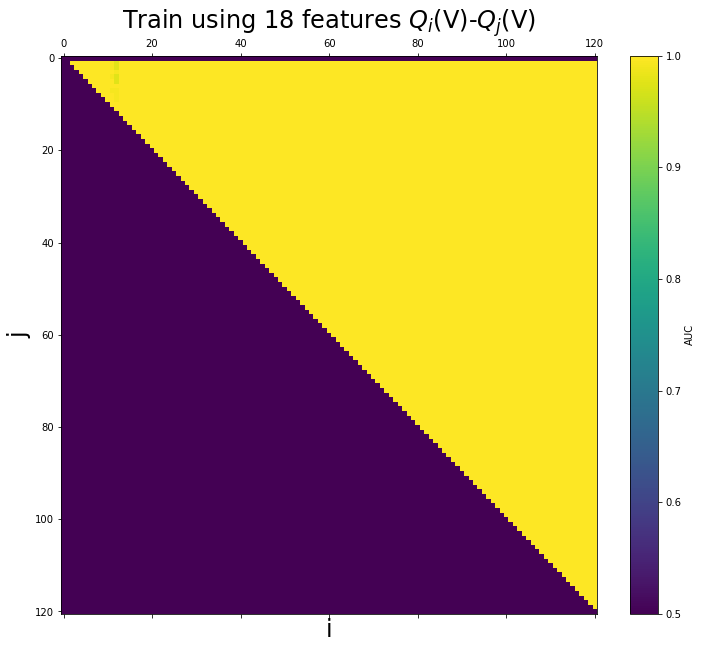

In [225]:
plt.figure(figsize=(12,10))
plt.matshow(mx_train, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Train using 18 features $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

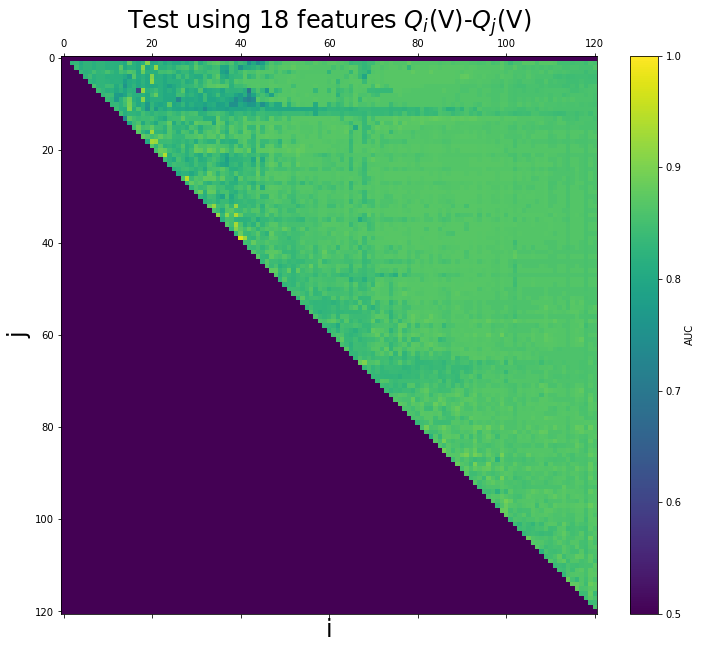

In [227]:
plt.figure(figsize=(12,10))
plt.matshow(mx_test, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Test using 18 features $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

In [218]:
np.where(mx_test==np.max(mx_test))

(array([39], dtype=int64), array([40], dtype=int64))

In [219]:
mx_test[np.where(mx_test==np.max(mx_test))]

array([0.97453704])

In [222]:
mx_acc_at[np.where(mx_test==np.max(mx_test))],mx_acc_apt[np.where(mx_test==np.max(mx_test))],mx_acc_ast[np.where(mx_test==np.max(mx_test))]

(array([1.]), array([0.9047619]), array([0.97222222]))

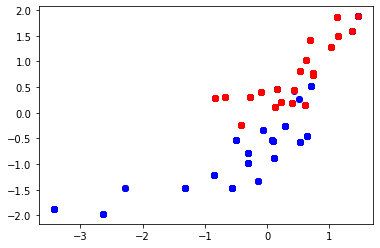

In [137]:
changecolor=cm.coolwarm_r(train_label)
for i in range(len(train_label)):
    if train_label[i]==0:
        changecolor='red'
    else:
        changecolor='blue'
    plt.scatter(Train_data_standard[i:,1],Train_data_standard[i:,2],color=changecolor)
    

In [147]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
X,y=Train_data_standard[:,1:3],train_label
Logistic_clf = Pipeline([
    ('Log_reg', LogisticRegression(random_state=42))
])

Logistic_clf.fit(X, y)

Pipeline(steps=[('Log_reg', LogisticRegression(random_state=42))])

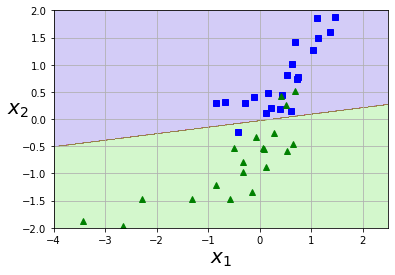

In [150]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "red")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "blue")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel("mean", fontsize=20)
    plt.ylabel("variance", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 1000)
    x1s = np.linspace(axes[2], axes[3], 1000)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    #plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(Logistic_clf, [-4, 2.5, -2, 2])
plot_dataset(X, y, [-4, 2.5, -2, 2])
plt.show()

In [1]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "red")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "blue")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel("mean", fontsize=20)
    plt.ylabel("variance", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 1000)
    x1s = np.linspace(axes[2], axes[3], 1000)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    #plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(Logistic_clf, [-4, 2.5, -2, 2])
plot_dataset(X, y, [-4, 2.5, -2, 2])
plt.show()

NameError: name 'Logistic_clf' is not defined

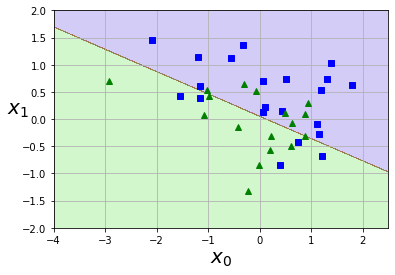

decision_function [ 0.04208675 -0.54916392  3.315393    0.48525729 -0.17783441  0.54730196
  3.55262018  0.70034064  0.7229365   4.86392804 -0.5967883   0.36307781
  1.89501213  1.17331322 -0.08206331 -0.34168639  0.01186563  0.4006977
 -0.8028335  -0.52323584 -0.71651644 -1.5414696  -0.36179784  0.16833488
 -0.09813062 -0.18888245 -1.08942378 -0.76998691 -2.00744576 -0.39594055
 -1.25644943 -1.15478706 -0.11977213  0.33682122 -0.27847209  0.94553805
  0.30691759  0.2136699  -0.86992712 -1.69748405 -1.59520909]
coef_ [[-0.53336016 -1.29868502]]
intercept_ [0.0690198]


In [201]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
X,y=Train_data_standard[:,:2],train_label
Logistic_clf = Pipeline([
    ('Log_reg', LogisticRegression(random_state=42))
])

Logistic_clf.fit(X, y)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 1000)
    x1s = np.linspace(axes[2], axes[3], 1000)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    #plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(Logistic_clf, [-4, 2.5, -2, 2])
plot_dataset(X, y, [-4, 2.5, -2, 2])
plt.show()
print('decision_function',Logistic_clf.decision_function(X))
print('coef_',Logistic_clf.named_steps['Log_reg'].coef_)
print('intercept_',Logistic_clf.named_steps['Log_reg'].intercept_)

In [21]:
bat_dict['b1c0']['summary']['chargetime'][1]+12

25.341250000000006

In [16]:
bat_dict['b1c0']['cycles']['1']['t']

array([0.00000000e+00, 2.41666667e-03, 2.91166667e-03, ...,
       5.43651150e+01, 5.43726733e+01, 5.43748267e+01])

In [ ]:
bat_dict['b1c0']['summary']['IR'][1]

논문에서는 처음 5개 Cycle만 사용해서 full classification을 만들었다 (18개 feature, 91 to 100 slope, intercept 제외함.)
여기서는 150 * 60 의 결과를 볼 수 있다. Min, Mean, Var, Skewness, Kurtosis , value at 2V 모두 log 적용해야함.

In [34]:
len(bat_dict['b1c0']['cycles']['2']['V'])

1117

In [39]:
ex=bat_dict['b1c0']['cycles']['2']['Qdlin']-bat_dict['b1c0']['cycles']['100']['Qdlin']

In [32]:
bat_dict['b1c0']['cycles']['2'].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

In [40]:
ex[-1]

-0.0035099706632932826

In [41]:
ex

array([-2.10745263e-04, -2.07301784e-04, -2.03465784e-04, -1.99305603e-04,
       -1.94889579e-04, -1.90286052e-04, -1.85563361e-04, -1.80789844e-04,
       -1.76033841e-04, -1.71363691e-04, -1.66847732e-04, -1.62554304e-04,
       -1.58551745e-04, -1.54908395e-04, -1.51692738e-04, -1.48975722e-04,
       -1.46830368e-04, -1.45329759e-04, -1.44546978e-04, -1.44555111e-04,
       -1.45389272e-04, -1.46907737e-04, -1.48884674e-04, -1.51069019e-04,
       -1.53209115e-04, -1.55053300e-04, -1.56349916e-04, -1.56914605e-04,
       -1.56876195e-04, -1.56422724e-04, -1.55729747e-04, -1.54972807e-04,
       -1.54327446e-04, -1.53968671e-04, -1.53983756e-04, -1.54290322e-04,
       -1.54832824e-04, -1.55566335e-04, -1.56445924e-04, -1.57426665e-04,
       -1.58463758e-04, -1.59515631e-04, -1.60537434e-04, -1.61473767e-04,
       -1.62268288e-04, -1.62864656e-04, -1.63206530e-04, -1.63238882e-04,
       -1.62938343e-04, -1.62329640e-04, -1.61455465e-04, -1.60359213e-04,
       -1.59084279e-04, -

In [59]:
x=bat_dict['b1c0']['summary']['QD']
while True:
    if np.max(x)>1.2:
        print('max=',np.max(x))
        print(np.where(np.max(x)==x))
        delete=np.where(np.max(x)==x)[0][0]
        x=np.delete(x, delete)
    if np.max(x)<=1.2:
        break
print(np.max(x))

max= 1.5390544
(array([11], dtype=int64),)
1.0770824


In [53]:
bat_dict['b1c0']['summary']['QD'][12]

1.0738269

In [60]:
bat_dict[k]['summary']['QD'][2]

1.0791167

In [64]:
np.max(bat_dict['b1c0']['cycles']['1']['T'])

35.652016

In [73]:
def maxT(k,i):
    if i==2:
        b=np.array(np.max(bat_dict[k]['cycles']['{}'.format(i)]['T'])
    if not i==2:
        maxt=[]
        for k_ in range(2,i+1):
            c=np.max(bat_dict[k]['cycles']['{}'.format(k_)]['T'])
            maxt.append(c)  
        b=np.max(np.array(maxt))
    return b

SyntaxError: invalid syntax (<ipython-input-73-78836c37a8a8>, line 4)